# Multiple Regression Project

* Student name: Max Steele
* Student pace: Full Time
* Scheduled project review date/time: Monday August 7 at 1 PM
* Instructor name: James Irving
* Blog post URL: <a href="https://zero731.github.io/dealing_with_outliers">https://zero731.github.io/dealing_with_outliers</a>


## Table of Contents

<font size=3rem>
    
- **[Introduction](#Introduction)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[INTERPRET](#INTERPRET)**<br>
- **[Conclusions/Recommendations](#Conclusions/Recommendations)<br>**
</font>

# Introduction

My goal for this project was to build a multiple linear regression model to predict house prices in King County as accurately as possible, focusing on homes that are representative of the majority within the county. The main purpose of this model is to be able to inform homeowners looking to sell their homes within this specific area of Washington. Because I was interested in building a model that can best predict house price, I included predictors which homeowners have no control over (such as aspects of location), in addition to factors that homeowners can attempt to manipulate to maximize their profit when selling their house. In this way, homeowners can get a better idea of the range of prices they might reasonably expect their home to command within the housing market. Homeowners can then use the interpretation of my final model to decide which aspects of their homes they can afford to alter, and focus on those that are most likely to increase their profit while avoiding changes that might negatively impact their selling price.

I followed the OSEMN data science process to approach this problem. To focus on the best predictors of house price to include in a multiple linear regression model, I first investigated which variables were most clearly linearly associated with price (Question 1, Answer in Section 4.5). I also determined how each feature should be treated -- whether as a continuous, ordinal or nominal categorical variable -- if it were to be included in the models (Question 2, Answer in Section 4.7). This required an iterative process of data scrubbing and exploring until the data were ready for inclusion in initial models. To maximize the predictive accuracy of my final model for houses representative of the majority within the county, I examined how 2 methods of outlier removal (based on z-scores or on IQR) impacted model performance and model residuals (Question 3, Answer in Section 6.4). While doing so I also examined how the different methods of outlier removal impacted the range of house types that the resulting model would be able to directly address. The removal of outliers for the final model decreased noise in the dataset, improving overall model performance. Outlier removal also had the added benefit of reducing correlations among variables that were all useful predictors of house price. This allowed for the inclusion of most of these variables as predictors without introducing unacceptably high levels of multicollinearity, which improved overall model performance and predictive ability for houses representative of nearly 95% of those sold in the county between May 2014 and May 2015.

# OBTAIN

In [2]:
import pandas as pd

pd.set_option('display.max_columns',0)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
## read in csv file
data = pd.read_csv('kc_house_data.csv')

## display first 5 rows of DataFrame
data.head()

id        date      price  bedrooms  bathrooms  sqft_living  sqft_lot  ...  yr_built  yr_renovated  zipcode    lat     long  sqft_living15 sqft_lot15
0  7129300520  10/13/2014 221900.000         3      1.000         1180      5650  ...      1955         0.000    98178 47.511 -122.257           1340       5650
1  6414100192   12/9/2014 538000.000         3      2.250         2570      7242  ...      1951      1991.000    98125 47.721 -122.319           1690       7639
2  5631500400   2/25/2015 180000.000         2      1.000          770     10000  ...      1933           nan    98028 47.738 -122.233           2720       8062
3  2487200875   12/9/2014 604000.000         4      3.000         1960      5000  ...      1965         0.000    98136 47.521 -122.393           1360       5000
4  1954400510   2/18/2015 510000.000         3      2.000         1680      8080  ...      1987         0.000    98074 47.617 -122.045           1800       7503

[5 rows x 21 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

There are several things of note based on this initial inspection of the DataFrame. Date will likely be more useful if we can separate out the year the house was sold.  The yr_renovated column is likely to be zero-inflated as a result of houses that haven't ever been renovated. The sqft_basement column is also likely to be zero-inflated and may be easier to work with as a categorical variable. However, sqft_basement is definitely a column that should be numeric, but it is currently object data type. That will require further investigation and cleaning to ensure the data are represented accurately regardless of whether we proceed with it as a categorical or continuous variable. 

Waterfront is stored as a float, but it is a category: either the propert is on the water (1.0) or it isn't (0.0). View is also stored as a float, but it is unclear what exactly this variable means. I will likely exclude it from the model.

It might be better to treat zipcode as a categorical variable since a higher or lower zipcode doesn't really imply anything about quantity and a model won't recognize this.

Most columns do not appear to have missing values at first glance (most columns are showing up as not containing NaN values); however, I'll still need to check for placeholder values in all columns.

# SCRUB

In [5]:
## display the number and percent of NaN's in each column
missing_values = pd.DataFrame()
missing_values['Number of Nulls'] = data.isna().sum()
missing_values['% Null'] = (data.isna().sum() / len(data)) * 100
missing_values

Number of Nulls  % Null
id                           0   0.000
date                         0   0.000
price                        0   0.000
bedrooms                     0   0.000
bathrooms                    0   0.000
sqft_living                  0   0.000
sqft_lot                     0   0.000
floors                       0   0.000
waterfront                2376  11.002
view                        63   0.292
condition                    0   0.000
grade                        0   0.000
sqft_above                   0   0.000
sqft_basement                0   0.000
yr_built                     0   0.000
yr_renovated              3842  17.790
zipcode                      0   0.000
lat                          0   0.000
long                         0   0.000
sqft_living15                0   0.000
sqft_lot15                   0   0.000

> -  Only 0.29% of the view column is missing.
- 11% of the waterfront column is missing.
- 17.8% of the yr_renovated column is missing.

In [6]:
## get summary statistics of the numeric columns
data.describe()

id       price  bedrooms  bathrooms  sqft_living    sqft_lot  ...  yr_renovated   zipcode       lat      long  sqft_living15  sqft_lot15
count      21597.000   21597.000 21597.000  21597.000    21597.000   21597.000  ...     17755.000 21597.000 21597.000 21597.000      21597.000   21597.000
mean  4580474287.771  540296.574     3.373      2.116     2080.322   15099.409  ...        83.637 98077.952    47.560  -122.214       1986.620   12758.284
std   2876735715.748  367368.140     0.926      0.769      918.106   41412.637  ...       399.946    53.513     0.139     0.141        685.230   27274.442
min      1000102.000   78000.000     1.000      0.500      370.000     520.000  ...         0.000 98001.000    47.156  -122.519        399.000     651.000
25%   2123049175.000  322000.000     3.000      1.750     1430.000    5040.000  ...         0.000 98033.000    47.471  -122.328       1490.000    5100.000
50%   3904930410.000  450000.000     3.000      2.250     1910.000    7618.000  ...         0.000 98065.000    47.572  -122.231       1840.000    7620.000
75%   7308900490.000  645000.000     4.000      2.500     2550.000   10685.000  ...         0.000 98118.000    47.678  -122.125       2360.000   10083.000
max   9900000190.000 7700000.000    33.000      8.000    13540.000 1651359.000  ...      2015.000 98199.000    47.778  -121.315       6210.000  871200.000

[8 rows x 19 columns]

In [7]:
## print out the counts of unique values appearing in each column, including counts of NaN
for col in data.columns:
    print(col, '\n', data[col].value_counts(dropna=False), '\n\n')

id 
 795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64 


date 
 6/23/2014     142
6/25/2014     131
6/26/2014     131
7/8/2014      127
4/27/2015     126
             ... 
11/30/2014      1
5/24/2015       1
5/15/2015       1
5/17/2014       1
1/31/2015       1
Name: date, Length: 372, dtype: int64 


price 
 350000.000    172
450000.000    172
550000.000    159
500000.000    152
425000.000    150
             ... 
870515.000      1
336950.000      1
386100.000      1
176250.000      1
884744.000      1
Name: price, Length: 3622, dtype: int64 


bedrooms 
 3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64 


bathrooms 
 2.500    5377
1.000    3851
1.750    3048
2.250    2047
2.000    1930
1.500    1445
2.750    118

> - The sqft_basement column has a placeholder value of '?'. This represents 2.1% of the column (454 / 21597).
- Several columns appear to be zero-inflated:
 - waterfront
 - view
 - sqft_basement
 - yr_renovated
> - The meaning behind the view column is unclear, so I have decided to drop the column entirely.


In [8]:
## drop view column from dataframe
data.drop(columns='view', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [9]:
## check for any identical rows in the dataset
data.duplicated().sum()

0

> - None of the rows are exact duplicates, but there are some houses that were sold more than once during this time period. This is made evident by the fact that some house id numbers appear multiple times (value counts). This will require some further investigation as this technically violates the assumption of independence among observations.

## Create Additional Columns

In [10]:
from pandas.api.types import is_numeric_dtype

def check_col(column):
    print('*** {} ***'.format(column.name))
    print('---------------')
    print('Data Type: {}'.format(column.dtype))
    print('% Null: {}'.format((column.isna().sum()/len(column)) * 100))
    print('---------------')
    print('Value Counts:\n {}'.format(column.value_counts(dropna=False)))
    print('---------------')
    if is_numeric_dtype(column):
          print('Min: {}\nMax:{}'.format(column.min(), column.max()))

In [11]:
## from date column, create a year sold column
data['yr_sold'] = data['date'].apply(lambda x: x.split('/')[-1]).astype('int64')
check_col(data['yr_sold'])

*** yr_sold ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 2014    14622
2015     6975
Name: yr_sold, dtype: int64
---------------
Min: 2014
Max:2015


In [12]:
## from date column, create a month sold column
data['month_sold'] = data['date'].apply(lambda x: x.split('/')[0]).astype('int64')
check_col(data['month_sold'])

*** month_sold ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month_sold, dtype: int64
---------------
Min: 1
Max:12


In [13]:
## create a season column based on month sold
def season(month):
    """Assign a season based on month according to Northern meteorological definition."""
    if month in [3,4,5]:
        return 'spring'
    elif month in [6,7,8]:
        return 'summer'
    elif month in [9,10,11]:
        return 'fall'
    else:
        return 'winter'

data['season_sold'] = data['month_sold'].apply(season)
check_col(data['season_sold'])

*** season_sold ***
---------------
Data Type: object
% Null: 0.0
---------------
Value Counts:
 spring    6518
summer    6328
fall      5056
winter    3695
Name: season_sold, dtype: int64
---------------


In [14]:
## create a column that represents the age of the house when it was sold
data['age'] = data['yr_sold'] - data['yr_built']
check_col(data['age'])

*** age ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
  9      472
 8      443
 11     431
 0      430
 10     428
       ... 
 113     28
 115     26
 81      23
 80      21
-1       12
Name: age, Length: 117, dtype: int64
---------------
Min: -1
Max:115


In [15]:
## it appears 12 houses were sold before they were finished being built
## this is pretty much the same as being sold at 0 years old (brand new), and homeowners selling their
##   homes won't have homes that are less than 0 years old, so replace -1 with 0 for these 12 homes
data['age'].replace({-1: 0}, inplace=True)
check_col(data['age'])

*** age ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 9      472
8      443
0      442
11     431
10     428
      ... 
112     33
113     28
115     26
81      23
80      21
Name: age, Length: 116, dtype: int64
---------------
Min: 0
Max:115


## Drop Duplicate Houses

In [16]:
## create a df that displays house id's that were sold more than once
id_counts = pd.DataFrame(data['id'].value_counts().
                         rename_axis('unique_values').
                         reset_index(name='counts'))
dup_ids = id_counts.loc[id_counts['counts']>1] 
dup_ids

unique_values  counts
0        795000620       3
1       1825069031       2
2       2019200220       2
3       7129304540       2
4       1781500435       2
..             ...     ...
171     7893805650       2
172     8161020060       2
173     1432400120       2
174     7701960990       2
175     1788900230       2

[176 rows x 2 columns]

> - It appears 176 houses were sold more than once during this time frame (May 2014 - May 2015).

In [17]:
## display rows for the one house that sold 3 times
data.loc[data['id']==795000620]

id        date      price  bedrooms  bathrooms  sqft_living  ...  sqft_living15  sqft_lot15  yr_sold  month_sold  season_sold  age
17588  795000620   9/24/2014 115000.000         3      1.000         1080  ...           1070        6250     2014           9         fall   64
17589  795000620  12/15/2014 124000.000         3      1.000         1080  ...           1070        6250     2014          12       winter   64
17590  795000620   3/11/2015 157000.000         3      1.000         1080  ...           1070        6250     2015           3       spring   65

[3 rows x 24 columns]

In [18]:
## create a list of id's for houses that sold more than once
dup_houses = list(dup_ids['unique_values'])

## create a df containing all records of houses sold more than once
dup_houses_df = data.loc[data['id'].isin(dup_houses)]
## sort the df by house id and then by year and month sold so records for each house id appear together
  # and in chronological order
dup_houses_df = dup_houses_df.sort_values(by=['id', 'yr_sold', 'month_sold'], axis=0)

print(dup_houses_df.info())

dup_houses_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 2494 to 1085
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             353 non-null    int64  
 1   date           353 non-null    object 
 2   price          353 non-null    float64
 3   bedrooms       353 non-null    int64  
 4   bathrooms      353 non-null    float64
 5   sqft_living    353 non-null    int64  
 6   sqft_lot       353 non-null    int64  
 7   floors         353 non-null    float64
 8   waterfront     307 non-null    float64
 9   condition      353 non-null    int64  
 10  grade          353 non-null    int64  
 11  sqft_above     353 non-null    int64  
 12  sqft_basement  353 non-null    object 
 13  yr_built       353 non-null    int64  
 14  yr_renovated   286 non-null    float64
 15  zipcode        353 non-null    int64  
 16  lat            353 non-null    float64
 17  long           353 non-null    float64
 18  sqft_l

id        date      price  bedrooms  bathrooms  sqft_living  ...  sqft_living15  sqft_lot15  yr_sold  month_sold  season_sold  age
2494     1000102   9/16/2014 280000.000         6      3.000         2400  ...           2060        7316     2014           9         fall   23
2495     1000102   4/22/2015 300000.000         6      3.000         2400  ...           2060        7316     2015           4       spring   24
16800    7200179  10/16/2014 150000.000         2      1.000          840  ...           1480        6969     2014          10         fall   89
16801    7200179   4/24/2015 175000.000         2      1.000          840  ...           1480        6969     2015           4       spring   90
11421  109200390   8/20/2014 245000.000         3      1.750         1480  ...           1830        6956     2014           8       summer   34
11422  109200390  10/20/2014 250000.000         3      1.750         1480  ...           1830        6956     2014          10         fall   34
12405  123039336   6/11/2014 148000.000         1      1.000          620  ...           1180        8244     2014           6       summer   75
12406  123039336   12/8/2014 244900.000         1      1.000          620  ...           1180        8244     2014          12       winter   75
7785   251300110   7/31/2014 225000.000         3      2.250         2510  ...           1870        8017     2014           7       summer   26
7786   251300110   1/14/2015 358000.000         3      2.250         2510  ...           1870        8017     2015           1       winter   27

[10 rows x 24 columns]

> - There are opportunities to fill in null or missing values for these duplicate houses based on the other record for the house.

In [19]:
## create a df of duplicate houses that have at least one null or otherwise missing value
null_dups = dup_houses_df.loc[dup_houses_df['waterfront'].isna() |
                  dup_houses_df['yr_renovated'].isna() |
                  (dup_houses_df['waterfront']=='?')]
null_dups

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


id        date       price  bedrooms  bathrooms  sqft_living  ...  sqft_living15  sqft_lot15  yr_sold  month_sold  season_sold  age
2494      1000102   9/16/2014  280000.000         6      3.000         2400  ...           2060        7316     2014           9         fall   23
16801     7200179   4/24/2015  175000.000         2      1.000          840  ...           1480        6969     2015           4       spring   90
12406   123039336   12/8/2014  244900.000         1      1.000          620  ...           1180        8244     2014          12       winter   75
14841   324000530    7/8/2014  201500.000         3      1.000         1320  ...           1320        4179     2014           7       summer  102
824     726049190   2/18/2015  431000.000         3      1.000         1810  ...           1810        8100     2015           2       winter   61
...           ...         ...         ...       ...        ...          ...  ...            ...         ...      ...         ...          ...  ...
2974   9136103130   12/1/2014  430000.000         2      1.500         1090  ...           1390        4013     2014          12       winter  114
2975   9136103130   5/12/2015  685000.000         2      1.500         1090  ...           1390        4013     2015           5       spring  115
6365   9222400605  11/15/2014  842500.000         5      4.000         2980  ...           1560        4225     2014          11         fall   93
16658  9250900104   4/10/2015  496000.000         5      1.750         2110  ...           2020        8500     2015           4       spring   53
4917   9809000020   5/13/2014 1900000.000         5      2.250         3120  ...           3740       17853     2014           5       spring   45

[110 rows x 24 columns]

In [20]:
null_dups['id'].value_counts()

3262300940    2
2892700041    2
4345000510    2
2212200100    2
1954420170    2
             ..
7524400250    1
1901600090    1
2019200220    1
2767602141    1
4435000705    1
Name: id, Length: 91, dtype: int64

> - Of the houses that sold more than once, 91 of them have null or otherwise missing values.

In [21]:
## sqft_basement uses a placeholder value
## check value counts to see how many records need to be fixed
null_dups['sqft_basement'].value_counts()

0.0       74
310.0      4
250.0      3
910.0      3
980.0      2
700.0      2
500.0      2
10.0       1
?          1
570.0      1
990.0      1
200.0      1
300.0      1
750.0      1
920.0      1
1010.0     1
1080.0     1
850.0      1
1000.0     1
730.0      1
430.0      1
1200.0     1
1380.0     1
280.0      1
900.0      1
350.0      1
680.0      1
Name: sqft_basement, dtype: int64

In [22]:
## find the one record missing the sqft_basement value in the null_dups df
null_dups.loc[null_dups['sqft_basement']=='?']

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  ...     long  sqft_living15  sqft_lot15  yr_sold  month_sold season_sold  age
19321  6021500970  4/7/2015 874950.000         2      1.000         1080      4000  ... -122.387           1530        4240     2015           4      spring   75

[1 rows x 24 columns]

In [23]:
## find the records of that house in the full dup_houses_df
dup_houses_df.loc[dup_houses_df['id']==(list(null_dups.loc[null_dups['sqft_basement']=='?']['id'])[0])]

id       date      price  bedrooms  bathrooms  sqft_living  ...  sqft_living15  sqft_lot15  yr_sold  month_sold  season_sold  age
19320  6021500970  5/28/2014 345000.000         2      1.000         1080  ...           1530        4240     2014           5       spring   74
19321  6021500970   4/7/2015 874950.000         2      1.000         1080  ...           1530        4240     2015           4       spring   75

[2 rows x 24 columns]

In [24]:
## the house in question has 0 sqft_basement, so fix the record that is missing this info
## IN THE ORIGINAL DATAFRAME
data.loc[19321, 'sqft_basement'] = 0
data.loc[19321]

id               6021500970
date               4/7/2015
price            874950.000
bedrooms                  2
bathrooms             1.000
sqft_living            1080
sqft_lot               4000
floors                1.000
waterfront            0.000
condition                 3
grade                     7
sqft_above             1080
sqft_basement             0
yr_built               1940
yr_renovated            NaN
zipcode               98117
lat                  47.690
long               -122.387
sqft_living15          1530
sqft_lot15             4240
yr_sold                2015
month_sold                4
season_sold          spring
age                      75
Name: 19321, dtype: object

In [25]:
## group houses by id and find the mean for each id
## most house id's will contain the same information (value / 1 = mean) because 
  ## most houses were only sold once
## if a house was sold twice and has a single null value in its record, the mean will show up as the value in 
  # the other record for the house and this can be used to replace the null value
## the values that we're replacing (waterfront and yr_renovated) are not extremely likely to have changed 
  # in the course of a year
mean_dup_houses = data.groupby('id').mean()
mean_dup_houses

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  ...    lat     long  sqft_living15  sqft_lot15  yr_sold  month_sold    age
id                                                                                     ...                                                                       
1000102    290000.000     6.000      3.000     2400.000  9373.000   2.000       0.000  ... 47.326 -122.214       2060.000    7316.000 2014.500       6.500 23.500
1200019    647500.000     4.000      1.750     2060.000 26036.000   1.000         nan  ... 47.444 -122.351       2590.000   21891.000 2014.000       5.000 67.000
1200021    400000.000     3.000      1.000     1460.000 43000.000   1.000       0.000  ... 47.443 -122.347       2250.000   20023.000 2014.000       8.000 62.000
2800031    235000.000     3.000      1.000     1430.000  7599.000   1.500       0.000  ... 47.478 -122.265       1290.000   10320.000 2015.000       4.000 85.000
3600057    402500.000     4.000      2.000     1650.000  3504.000   1.000       0.000  ... 47.580 -122.294       1480.000    3504.000 2015.000       3.000 64.000
...               ...       ...        ...          ...       ...     ...         ...  ...    ...      ...            ...         ...      ...         ...    ...
9842300095 365000.000     5.000      2.000     1600.000  4168.000   1.500       0.000  ... 47.530 -122.381       1190.000    4168.000 2014.000       7.000 87.000
9842300485 380000.000     2.000      1.000     1040.000  7372.000   1.000       0.000  ... 47.529 -122.378       1930.000    5150.000 2015.000       3.000 76.000
9842300540 339000.000     3.000      1.000     1100.000  4128.000   1.000       0.000  ... 47.530 -122.379       1510.000    4538.000 2014.000       6.000 72.000
9895000040 399900.000     2.000      1.750     1410.000  1005.000   1.500       0.000  ... 47.545 -122.018       1440.000    1188.000 2014.000       7.000  3.000
9900000190 268950.000     3.000      1.000     1320.000  8100.000   1.000       0.000  ... 47.470 -122.351       1000.000    8100.000 2014.000      10.000 71.000

[21420 rows x 20 columns]

In [26]:
## create a list of id's for houses that sold more than once that had a null value for waterfront
null_dups_waterfront = dup_houses_df.loc[dup_houses_df['waterfront'].isna()]
null_dups_waterfront_list = list(null_dups_waterfront['id'])

## create a list of id's for houses that sold more than once that had a null value for yr_renovated
null_dups_renov = dup_houses_df.loc[dup_houses_df['yr_renovated'].isna()]
null_dups_renov_list = list(null_dups_renov['id'])

In [27]:
## for each id in the list of duplicate houses with null values,
## replace values with the mean for waterfront
for house_id in null_dups_waterfront_list:
    data.loc[data['id']==house_id, 'waterfront'] = mean_dup_houses.loc[house_id, 'waterfront']
check_col(data['waterfront'])

*** waterfront ***
---------------
Data Type: float64
% Null: 10.816317081076075
---------------
Value Counts:
 0.000    19115
nan       2336
1.000      146
Name: waterfront, dtype: int64
---------------
Min: 0.0
Max:1.0


In [28]:
## for each id in the list of duplicate houses with null values,
## replace values with the mean for yr_renovated
for house_id in null_dups_renov_list:
    data.loc[data['id']==house_id, 'yr_renovated'] = mean_dup_houses.loc[house_id, 'yr_renovated']
check_col(data['yr_renovated'])

*** yr_renovated ***
---------------
Data Type: float64
% Null: 17.525582256794927
---------------
Value Counts:
 0.000       17068
nan          3785
2014.000       73
2003.000       31
2013.000       31
            ...  
1944.000        1
1948.000        1
1976.000        1
1934.000        1
1953.000        1
Name: yr_renovated, Length: 71, dtype: int64
---------------
Min: 0.0
Max:2015.0


In [29]:
len(data)

21597

In [30]:
## only want to keep the most recent entry for each house that was sold more than once in the final df
## if this works it should drop 177 rows, so 21597 - 177 = 21420
len(data.sort_values(by=['id', 'yr_sold', 'month_sold'], axis=0).drop_duplicates(subset='id', keep='last'))

21420

In [31]:
## sort the rows first by id to group any duplicates, then by year sold, then month to put the 
 ## duplicate sellers in chronological order so that we can drop all bu the last record for each id
data = data.sort_values(by=['id', 'yr_sold', 'month_sold'], axis=0).drop_duplicates(subset='id', keep='last')

## check that each house id now only shows up once
data['id'].value_counts()

2911700010    1
8732800090    1
1545808560    1
2078500210    1
1562000050    1
             ..
1189000492    1
1023059246    1
7202340820    1
4039300400    1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [32]:
## resort the df so it's back in the original order
data.sort_index(inplace=True)
data.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            21587, 21588, 21589, 21590, 21591, 21592, 21593, 21594, 21595,
            21596],
           dtype='int64', length=21420)

## QUESTION 1: Which variables have clear linear relationships with price?

It is unlikely that all the variables in the dataset have a strong linear relationship with the target variable (price). In the following sections I will seek to identify which variables are clearly linearly related with price, and which numerical variables clearly aren't and may need to be dropped from the model entirely.

## QUESTION 2: Which variables should be treated as continuous versus categorical?

I have already noted several columns that may need to be cast as different data types and treated as categorical/ binned for modelling purposes. In the following section I will examine each column individually to determine what sort of variable the column best represents. This will involve examining value counts, the amount of null and otherwise missing values (placeholders) within the column, the number of unique values, etc. As such, I will be recasting columns and dealing with null/missing values for each column in this section.

As a first step, I will examine histograms for all variables as they currently stand.

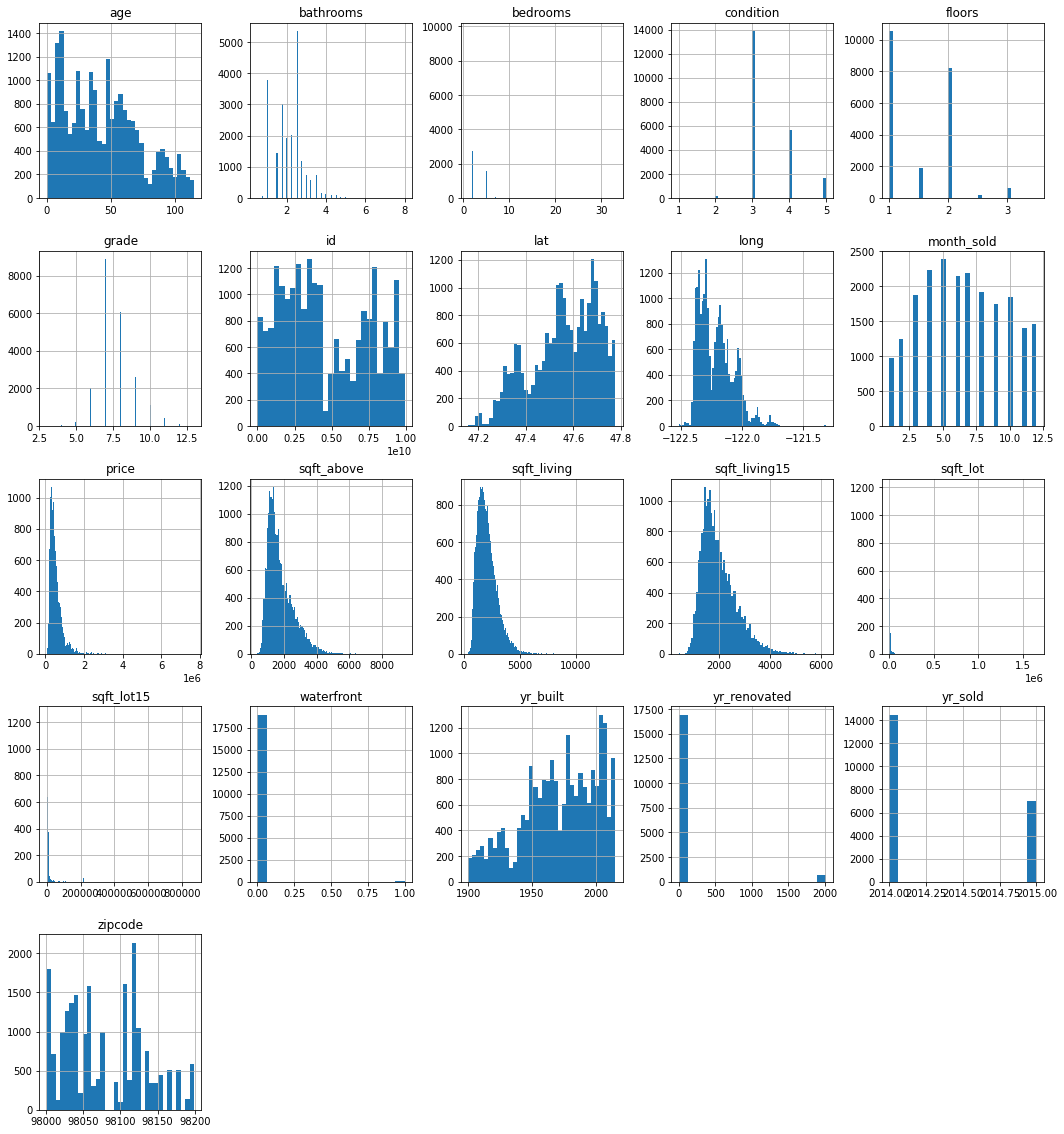

In [33]:
data.hist(figsize=(18, 20), bins='auto');

None of the variables look very normally distributed. Variables like price (the target variable), sqft_above, sqft_living, sqft_living15, and age/yr_built may need to be transformed in some way to be easier to work with. A log transformation may work well for most of those since they are mostly right skewed.

The variables may need to be standardized so that they have similar scales because they currently vary widely in magnitude.

There are definitely variables with outliers that require further investigation. The bedroom and price columns need to be checked, as well as the columns dealing with square footage.

### Target Variable: Price

> - The target variable, price, is very non-normally distributed and definitely contains outliers that will likely need to be removed.

In [34]:
check_col(data['price'])

*** price ***
---------------
Data Type: float64
% Null: 0.0
---------------
Value Counts:
 450000.000    172
350000.000    167
550000.000    157
500000.000    151
425000.000    149
             ... 
234975.000      1
804995.000      1
870515.000      1
336950.000      1
884744.000      1
Name: price, Length: 3595, dtype: int64
---------------
Min: 78000.0
Max:7700000.0


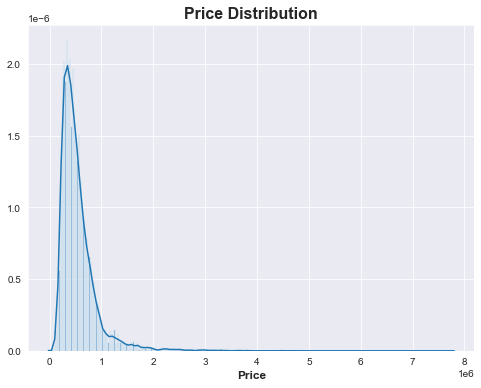

In [35]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
ax = sns.distplot(data['price'], bins='auto')
ax.set_title('Price Distribution', fontsize=16, weight ='bold')
ax.set_xlabel('Price', fontsize=12, weight ='bold');

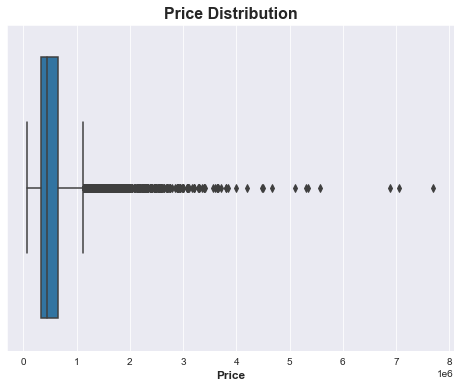

In [36]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(data['price'])
ax.set_title('Price Distribution', fontsize=16, weight ='bold')
ax.set_xlabel('Price', fontsize=12, weight ='bold');

### Age / yr_built

> - These two columns hold essentially the same information. I will use age in my models since this metric is something a homeowner can easily figure out for their own home, whereas if I reported on the year the house was built, they may not take into account that the houses in this dataset were all sold 5-6 years ago. If necessary, I can use a log transformation to adjust for some of the right skewedness of the data. However, I will need to add a constant (age + 1) because some houses were 0 years old when sold and the log of 0 is undefined.

In [37]:
check_col(data['yr_built'])

*** yr_built ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 2014    559
2006    453
2005    450
2004    429
2003    420
       ... 
1901     29
1933     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64
---------------
Min: 1900
Max:2015


In [38]:
check_col(data['age'])

*** age ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 9      472
8      443
0      442
11     431
10     424
      ... 
112     33
113     28
115     26
81      22
80      21
Name: age, Length: 116, dtype: int64
---------------
Min: 0
Max:115


> - There may be a very slight trend of decreasing price with increasing age. However it's difficult to tell whether this will become more or less pronounced with the removal of outliers.
- Age can clearly be treated as a continuous variable.

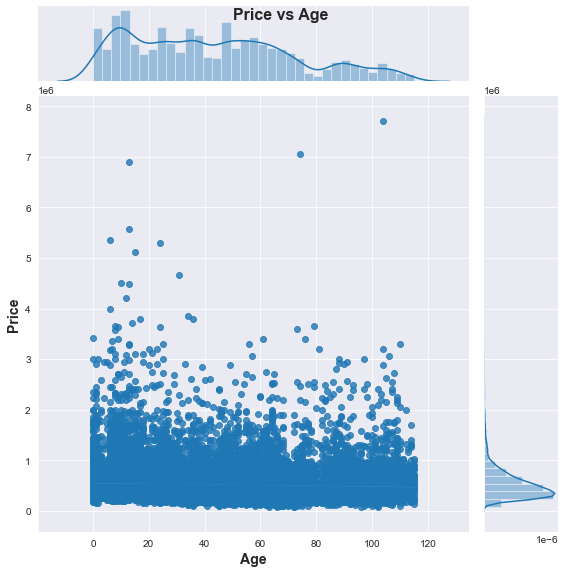

In [39]:
g = sns.jointplot(x='age', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Age', fontsize=16, weight='bold')
g.set_axis_labels('Age', 'Price', fontsize=14, weight='bold');

### Bathrooms

*** bathrooms ***
---------------
Data Type: float64
% Null: 0.0
---------------
Value Counts:
 2.500    5352
1.000    3794
1.750    3020
2.250    2031
2.000    1913
1.500    1429
2.750    1182
3.000     747
3.500     729
3.250     586
3.750     155
4.000     134
4.500      99
4.250      79
0.750      70
4.750      23
5.000      21
5.250      13
5.500      10
1.250       9
6.000       6
5.750       4
0.500       4
8.000       2
6.250       2
6.750       2
6.500       2
7.500       1
7.750       1
Name: bathrooms, dtype: int64
---------------
Min: 0.5
Max:8.0
None


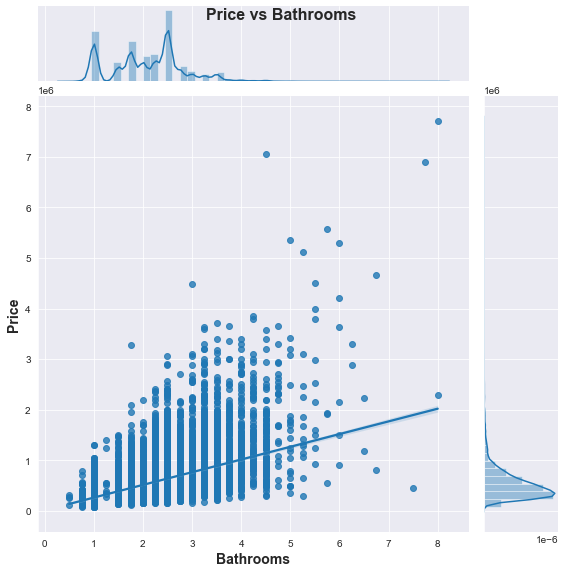

In [40]:
print(check_col(data['bathrooms']))
g = sns.jointplot(x='bathrooms', y='price', data=data, kind='reg', height=8);
g.fig.suptitle('Price vs Bathrooms', fontsize=16, weight='bold')
g.set_axis_labels('Bathrooms', 'Price', fontsize=14, weight='bold');

> - There appears to be at least a slightly linear relationship between price and number of bathrooms; however there also appear to be outliers that will need to be removed and this may affect the strength of the relationship.
- Number of bathrooms should be treated as an ordinal categorical variable.

### Bedrooms

*** bedrooms ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 3     9731
4     6849
2     2736
5     1586
6      265
1      191
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64
---------------
Min: 1
Max:33
None


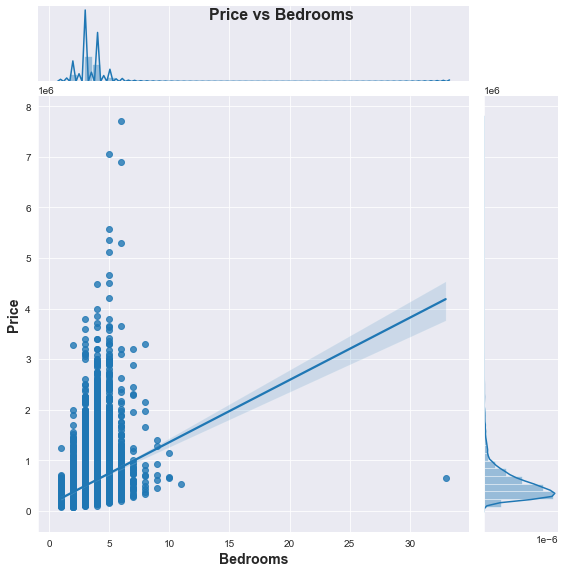

In [41]:
print(check_col(data['bedrooms']))
g = sns.jointplot(x='bedrooms', y='price', data=data, kind='reg', height=8);
g.fig.suptitle('Price vs Bedrooms', fontsize=16, weight='bold')
g.set_axis_labels('Bedrooms', 'Price', fontsize=14, weight='bold');

> - There is one extreme outlier for number of bedrooms, 33. It appears this entry may be a typo. The median and mode number of bedrooms for a house in this dataset is 3, and this particular house is not very large (300 sq ft less than the median of 1920 sq ft). As such, I am replacing this value of 33 with 3.

In [42]:
display(data.loc[data['bedrooms']==33])
data.describe()

id       date      price  bedrooms  bathrooms  sqft_living  ...  sqft_living15  sqft_lot15  yr_sold  month_sold  season_sold  age
15856  2402100895  6/25/2014 640000.000        33      1.750         1620  ...           1330        4700     2014           6       summer   67

[1 rows x 24 columns]

id       price  bedrooms  bathrooms  sqft_living    sqft_lot  ...      long  sqft_living15  sqft_lot15   yr_sold  month_sold       age
count      21420.000   21420.000 21420.000  21420.000    21420.000   21420.000  ... 21420.000      21420.000   21420.000 21420.000   21420.000 21420.000
mean  4580939869.158  541861.428     3.374      2.118     2083.133   15128.038  ...  -122.214       1988.384   12775.718  2014.325       6.564    43.233
std   2876761172.448  367556.938     0.925      0.769      918.808   41530.797  ...     0.141        685.537   27345.622     0.468       3.118    29.389
min      1000102.000   78000.000     1.000      0.500      370.000     520.000  ...  -122.519        399.000     651.000  2014.000       1.000     0.000
25%   2123537386.750  324950.000     3.000      1.750     1430.000    5040.000  ...  -122.328       1490.000    5100.000  2014.000       4.000    17.000
50%   3904921185.000  450550.000     3.000      2.250     1920.000    7614.000  ...  -122.230       1840.000    7620.000  2014.000       6.000    39.000
75%   7308900186.250  645000.000     4.000      2.500     2550.000   10690.500  ...  -122.125       2370.000   10086.250  2015.000       9.000    63.000
max   9900000190.000 7700000.000    33.000      8.000    13540.000 1651359.000  ...  -121.315       6210.000  871200.000  2015.000      12.000   115.000

[8 rows x 21 columns]

*** bedrooms ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 3     9732
4     6849
2     2736
5     1586
6      265
1      191
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64
---------------
Min: 1
Max:11
None


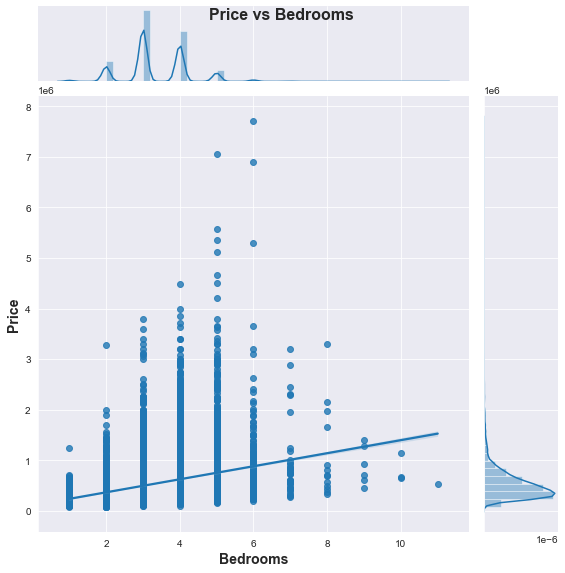

In [43]:
## replace the 33 with 3 (the median and mode for the variable 'bedrooms')
data.loc[data['bedrooms']==33, 'bedrooms'] = 3
print(check_col(data['bedrooms']))
g = sns.jointplot(x='bedrooms', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Bedrooms', fontsize=16, weight='bold')
g.set_axis_labels('Bedrooms', 'Price', fontsize=14, weight='bold');
# now the maximum number of bedrooms is more reasonable at 11

> - It appears that there may be a linear relationship between price and number of bedrooms, though there may be additional outliers in terms of numbers of bedrooms that need to be removed.
- Number of bedrooms should be treated as an ordinal categorical variable.

### Floors

*** floors ***
---------------
Data Type: float64
% Null: 0.0
---------------
Value Counts:
 1.000    10552
2.000     8203
1.500     1888
3.000      609
2.500      161
3.500        7
Name: floors, dtype: int64
---------------
Min: 1.0
Max:3.5
None


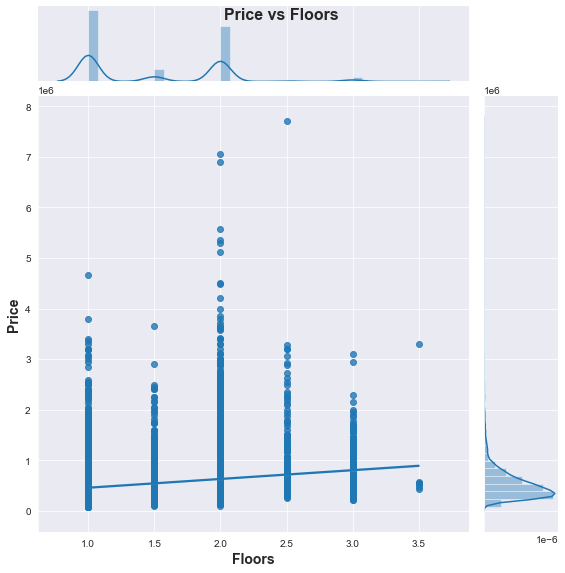

In [44]:
print(check_col(data['floors']))
g = sns.jointplot(x='floors', y='price', data=data, kind='reg', height=8);
g.fig.suptitle('Price vs Floors', fontsize=16, weight='bold')
g.set_axis_labels('Floors', 'Price', fontsize=14, weight='bold');

> - It is not clear that there is much of a relationship between price and the number of floors in a house.
- Only 7 houses have 3.5 floors, so these might be treated as outliers. However, number of floors is also likely to be highly correlated with other variables like sqft_living area which are much more strongly related to price, so this variable may not make it into the final model.
- If floors is retained, it will be treated as an ordinal categorical variable.

### Condition

*** condition ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 3    13900
4     5643
5     1687
2      162
1       28
Name: condition, dtype: int64
---------------
Min: 1
Max:5
None


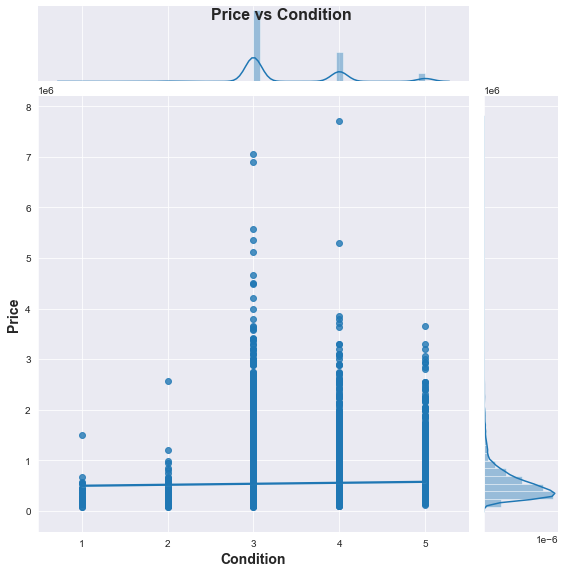

In [45]:
print(check_col(data['condition']))
g = sns.jointplot(x='condition', y='price', data=data, kind='reg', height=8);
g.fig.suptitle('Price vs Condition', fontsize=16, weight='bold')
g.set_axis_labels('Condition', 'Price', fontsize=14, weight='bold');

> - By assigning the condition of a house a number, one might expect houses in better condition to sell for higher prices. There is no linear relationship between increasing condition and price whatsoever. 
- This is assigned by the county and is designed to be relative to grade and age (<a href="https://www.kingcounty.gov/depts/assessor/Reports/area-reports/2017/residential-westcentral/~/media/depts/assessor/documents/AreaReports/2017/Residential/013.ashx">King County Assessments</a>). Thus the relationship with price was not a straightfoward linear relationship and this variable may be best treated as a category even though the numerical ranking implies an order to the categories.

### Grade

*** grade ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 7     8889
8     6041
9     2606
6     1995
10    1130
11     396
5      234
12      88
4       27
13      13
3        1
Name: grade, dtype: int64
---------------
Min: 3
Max:13
None


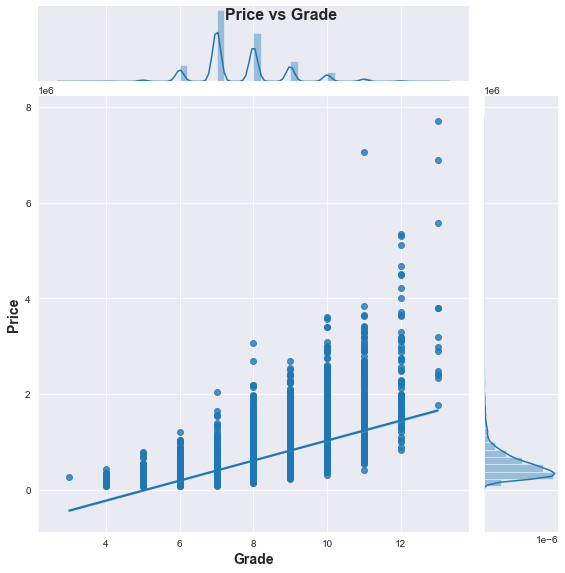

In [46]:
print(check_col(data['grade']))
g = sns.jointplot(x='grade', y='price', data=data, kind='reg', height=8);
g.fig.suptitle('Price vs Grade', fontsize=16, weight='bold')
g.set_axis_labels('Grade', 'Price', fontsize=14, weight='bold');

> - There does appear to be a linear relationship between price and grade.
- The 'grade' variable represents a score 1 - 13 assigned by the county to each home. This metric takes into account the design, construction quality, and workmanship of the house (<a href="https://www.kingcounty.gov/depts/assessor/Reports/area-reports/2017/residential-westcentral/~/media/depts/assessor/documents/AreaReports/2017/Residential/013.ashx">King County Assessments</a>). However it also awards higher grades for houses with more square footage. Thus this variable is highly correlated with sqft_living (see Section 4.6).
- This variable is best treated as an ordinal categorical variable.

### Month_sold

*** month_sold ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 5     2393
4     2229
7     2187
6     2151
8     1913
3     1875
10    1854
9     1747
12    1458
11    1396
2     1244
1      973
Name: month_sold, dtype: int64
---------------
Min: 1
Max:12
None


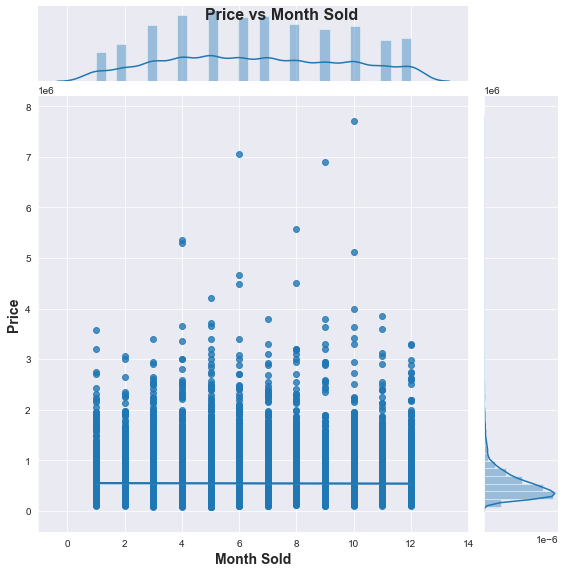

In [47]:
print(check_col(data['month_sold']))
g = sns.jointplot(x='month_sold', y='price', data=data, kind='reg', height=8);
g.fig.suptitle('Price vs Month Sold', fontsize=16, weight='bold')
g.set_axis_labels('Month Sold', 'Price', fontsize=14, weight='bold');

> - Month sold does not appear to affect house price.

### Season_sold

*** season_sold ***
---------------
Data Type: object
% Null: 0.0
---------------
Value Counts:
 spring    6497
summer    6251
fall      4997
winter    3675
Name: season_sold, dtype: int64
---------------
None


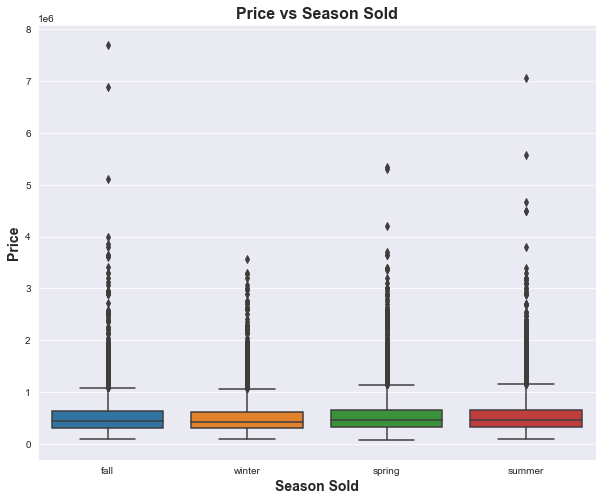

In [48]:
print(check_col(data['season_sold']))
plt.figure(figsize=(10,8))
ax = sns.boxplot(x='season_sold', y='price', data=data);
ax.set_title('Price vs Season Sold', fontsize=16, weight='bold')
ax.set_xlabel('Season Sold', fontsize=14, weight='bold')
ax.set_ylabel('Price', fontsize=14, weight='bold');

> - There appears to be no affect of season on selling price whatsoever.

### Yr_sold

*** yr_sold ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 2014    14453
2015     6967
Name: yr_sold, dtype: int64
---------------
Min: 2014
Max:2015
None


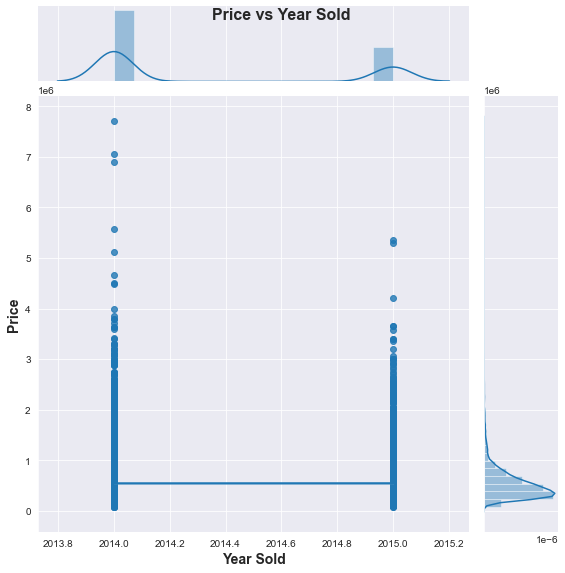

In [49]:
print(check_col(data['yr_sold']))
g = sns.jointplot(x='yr_sold', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Year Sold', fontsize=16, weight='bold')
g.set_axis_labels('Year Sold', 'Price', fontsize=14, weight='bold');

> - There is no relationship between year sold and price.

### Sqft_above

*** sqft_above ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 1300    210
1010    204
1200    203
1220    186
1140    183
       ... 
2665      1
2601      1
440       1
2473      1
1975      1
Name: sqft_above, Length: 942, dtype: int64
---------------
Min: 370
Max:9410
None


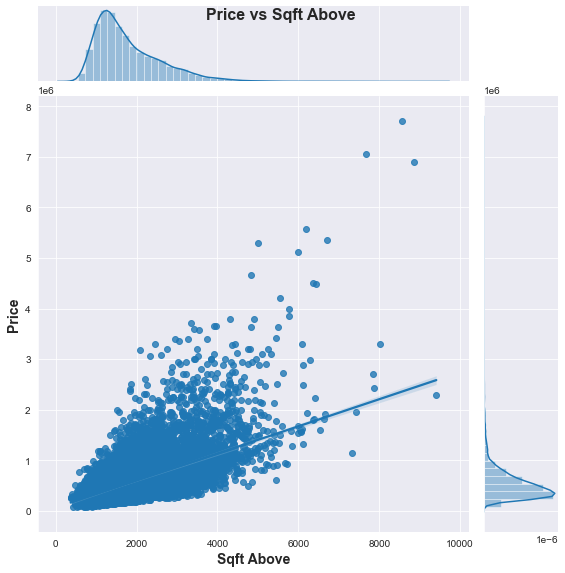

In [50]:
print(check_col(data['sqft_above']))
g = sns.jointplot(x='sqft_above', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Sqft Above', fontsize=16, weight='bold')
g.set_axis_labels('Sqft Above', 'Price', fontsize=14, weight='bold');

> - There appears to be a relatively linear relationship between price and square foot above ground, but there are also outliers that need to be removed.
- Sqft_above should definitely be treated as a continuous variable.

### Sqft_basement

In [51]:
check_col(data['sqft_basement'])

*** sqft_basement ***
---------------
Data Type: object
% Null: 0.0
---------------
Value Counts:
 0.0       12716
?           451
600.0       216
500.0       206
700.0       206
          ...  
2300.0        1
417.0         1
1275.0        1
1135.0        1
0             1
Name: sqft_basement, Length: 305, dtype: int64
---------------


In [52]:
(len(data.loc[data['sqft_basement']=='?']) / len(data)) * 100

2.1055088702147526

> - This column has a placeholder value of '?' which makes up 2.1% of the column. There are 451 records with this placeholder value.

In [53]:
## estimate the square footage of basements for all houses by subtracting sqft_above from sqft_living
data['est_sqft_basement'] = data['sqft_living'] - data['sqft_above']
check_col(data['est_sqft_basement'])

*** est_sqft_basement ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 0       12999
600       220
700       215
500       211
800       206
        ...  
1816        1
792         1
2590        1
935         1
248         1
Name: est_sqft_basement, Length: 306, dtype: int64
---------------
Min: 0
Max:4820


> - The above values and counts are very similar to those of the original sqft_basement column. Additionally, the original column contained a total of 12,717 zero values. If you add the 282 missing zero values calculated for houses with sqft_basement originally recorded as '?' to 12,717, that adds up to the total estimated above of 12999 zero values. None of the estimated values of sqft_basement for houses missing this information appear unreasonable, so I will use the column with the calculated values for analyses rather than the sqft_basement column provided since it has no missing values.

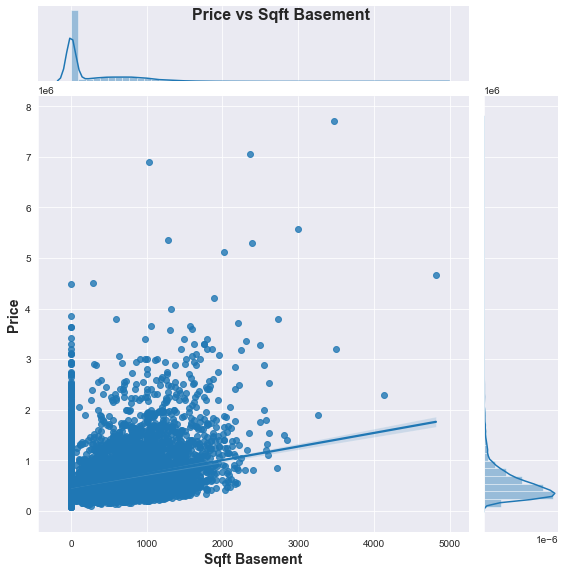

In [54]:
g = sns.jointplot(x='est_sqft_basement', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Sqft Basement', fontsize=16, weight='bold')
g.set_axis_labels('Sqft Basement', 'Price', fontsize=14, weight='bold');

> - There may be a linear relationship between price and basement square footage. However, there are definite outliers that may need to be removed.
- This variable is zero-inflated. 
- Sqft_basement may work as a continuous variable, but it could also be used as a binary categorical variable: either the house has a basement (1) or it doesn't (0).

In [55]:
def col_to_binary(series):
    """Takes in a column from a Pandas DataFrame and returns the column transformed so that values
       are binary - either 0 or 1 - based on whether the value was 0 or greater than 0, respectively. 
       Specifically intended for use with zero-inflated columns, so note that the function 
       does automatically convert NaN values to 0."""
    if series > 0:
        return 1
    else:
        return 0

In [56]:
## transform sqft_basement column to boolean basement or no basement and rename
data['basement'] = data['est_sqft_basement'].apply(lambda x: col_to_binary(x))
check_col(data['basement'])

*** basement ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 0    12999
1     8421
Name: basement, dtype: int64
---------------
Min: 0
Max:1


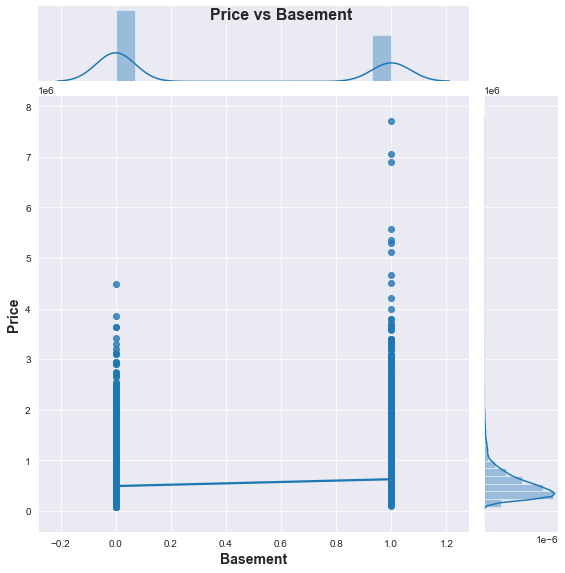

In [57]:
g = sns.jointplot(x='basement', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Basement', fontsize=16, weight='bold')
g.set_axis_labels('Basement', 'Price', fontsize=14, weight='bold');

> - Again it appears there may be a slight relationship between the price of a house and whether or not it has a basement.

### Sqft_living

*** sqft_living ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 1300    136
1440    133
1400    132
1660    128
1800    128
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64
---------------
Min: 370
Max:13540
None


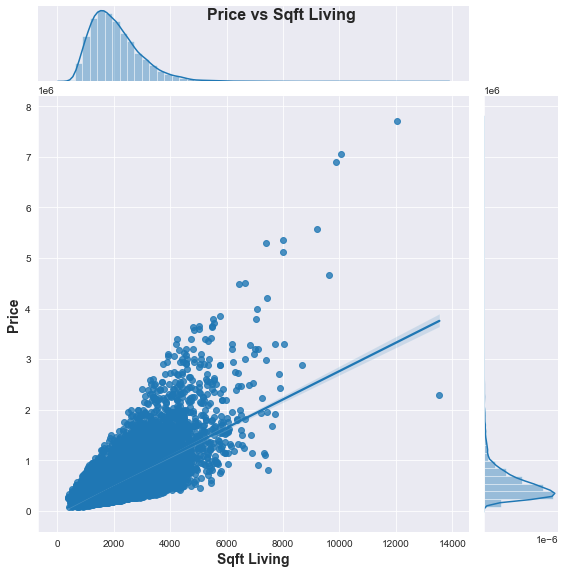

In [58]:
print(check_col(data['sqft_living']))
g = sns.jointplot(x='sqft_living', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Sqft Living', fontsize=16, weight='bold')
g.set_axis_labels('Sqft Living', 'Price', fontsize=14, weight='bold');

> - There does appear to be a linear relationship between price and square footage of living space, and there are definitely outliers here that may need to be removed.
- Sqft_living is a continuous variable and may be improved as a predictor through log transformation since this would reduce the right-skewedness of the data. Outliers should be removed prior to log transformation.

### Sqft_living15

*** sqft_living15 ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 1540    193
1560    190
1440    190
1500    178
1460    168
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64
---------------
Min: 399
Max:6210
None


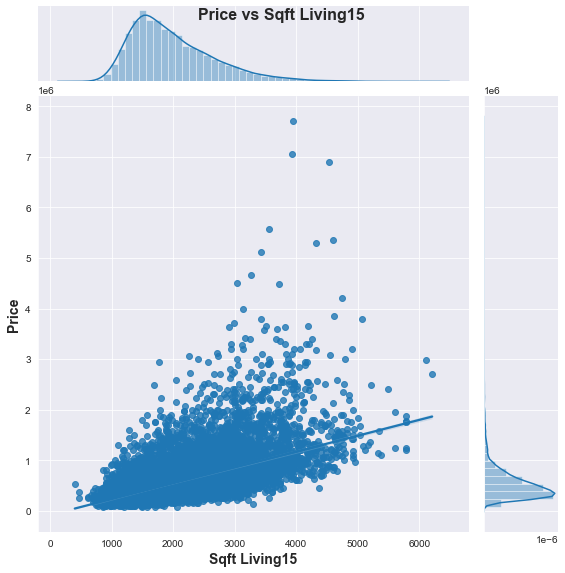

In [59]:
print(check_col(data['sqft_living15']))
g = sns.jointplot(x='sqft_living15', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Sqft Living15', fontsize=16, weight='bold')
g.set_axis_labels('Sqft Living15', 'Price', fontsize=14, weight='bold');

> - There is a relatively linear relationship between the average square footage of living space of the neighboring houses and price. This is not surprising since the sqft_living of neighboring houses is likely to be similar to that of the house in question and the section above demonstrated a relationship between price and sqft_living. Thus, this variable is likely highly correlated with sqft_living.

### Sqft_lot

*** sqft_lot ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 5000      355
6000      286
4000      249
7200      218
7500      118
         ... 
9133        1
64438       1
953         1
969         1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64
---------------
Min: 520
Max:1651359
None


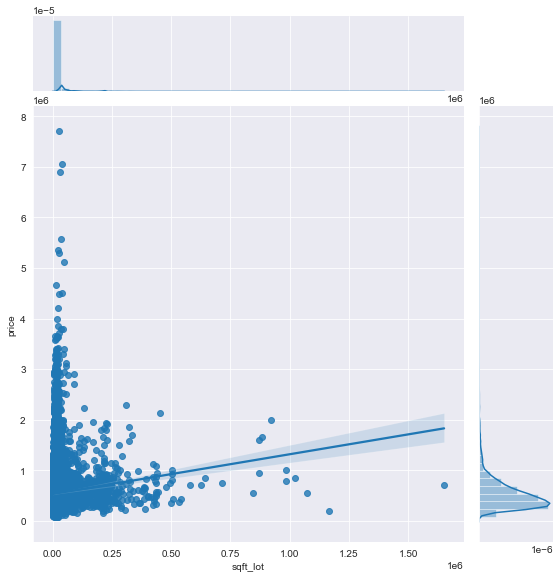

In [60]:
print(check_col(data['sqft_lot']))
sns.jointplot(x='sqft_lot', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Sqft Lot', fontsize=16, weight='bold')
g.set_axis_labels('Sqft Lot', 'Price', fontsize=14, weight='bold');

> - Price and the square footage of the lot on which a house resides do not appear to be strongly related.

### Sqft_lot15

*** sqft_lot15 ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 5000     425
4000     354
6000     285
7200     209
4800     144
        ... 
11068      1
21315      1
35656      1
13135      1
6147       1
Name: sqft_lot15, Length: 8682, dtype: int64
---------------
Min: 651
Max:871200
None


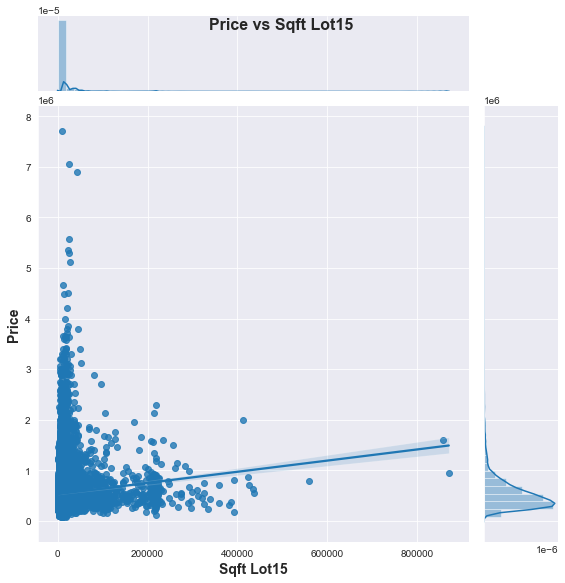

In [61]:
print(check_col(data['sqft_lot15']))
g = sns.jointplot(x='sqft_lot15', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Sqft Lot15', fontsize=16, weight='bold')
g.set_axis_labels('Sqft Lot15', 'Price', fontsize=14, weight='bold');

> - Price and the average square footage of neighboring lots do not appear to be strongly related. This is not surprising given that lot size is probably very similar among neighbors, and no trend was found between price and sqft_lot.

### Waterfront

*** waterfront ***
---------------
Data Type: float64
% Null: 10.891690009337069
---------------
Value Counts:
 0.000    18941
nan       2333
1.000      146
Name: waterfront, dtype: int64
---------------
Min: 0.0
Max:1.0
None


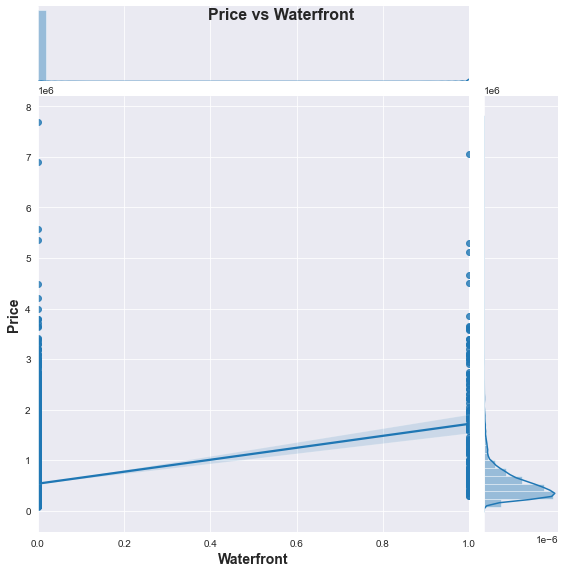

In [62]:
print(check_col(data['waterfront']))
g = sns.jointplot(x='waterfront', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Waterfront', fontsize=16, weight='bold')
g.set_axis_labels('Waterfront', 'Price', fontsize=14, weight='bold');

> - There is some evidence that price is higher for waterfront homes.
- This variable has 2333 missing values and is extremely zero-inflated. Imputing the mode (0, non-waterfront) for the missing values (below) does not seem to impact the observed trend.

*** waterfront ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 0    21274
1      146
Name: waterfront, dtype: int64
---------------
Min: 0
Max:1
None


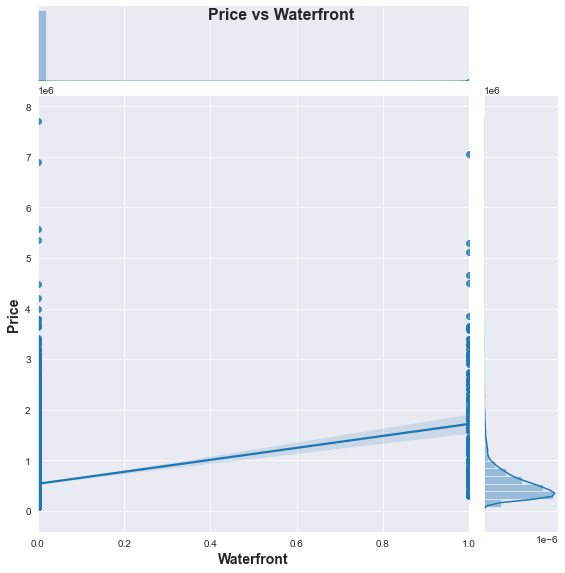

In [63]:
## replace NaN's in waterfront column with mode of 0
data['waterfront'] = data['waterfront'].apply(lambda x: col_to_binary(x))
print(check_col(data['waterfront']))
g = sns.jointplot(x='waterfront', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Waterfront', fontsize=16, weight='bold')
g.set_axis_labels('Waterfront', 'Price', fontsize=14, weight='bold');

> - Now virtually all the houses are not waterfront (which was basically already the case).
- This variable is by nature a binary categorical variable.

### Yr_renovated

*** yr_renovated ***
---------------
Data Type: float64
% Null: 17.647058823529413
---------------
Value Counts:
 0.000       16900
nan          3780
2014.000       73
2003.000       31
2013.000       31
            ...  
1944.000        1
1953.000        1
1951.000        1
1946.000        1
1950.000        1
Name: yr_renovated, Length: 71, dtype: int64
---------------
Min: 0.0
Max:2015.0
None


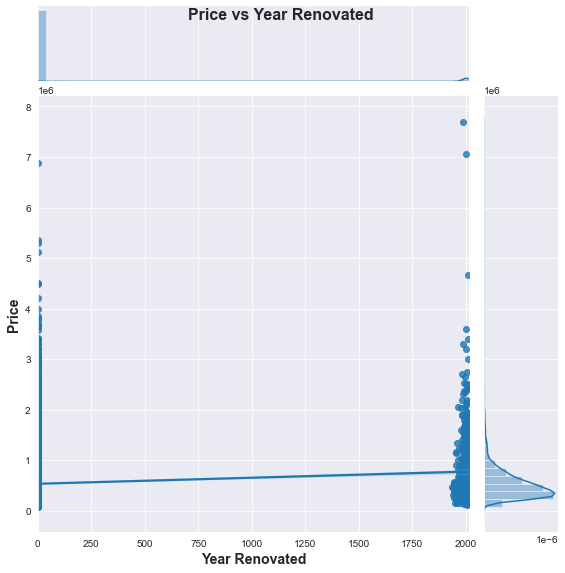

In [64]:
print(check_col(data['yr_renovated']))
g = sns.jointplot(x='yr_renovated', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Year Renovated', fontsize=16, weight='bold')
g.set_axis_labels('Year Renovated', 'Price', fontsize=14, weight='bold');

In [65]:
print('Null values: {}%'.format(round((data['yr_renovated'].isna().sum() / len(data)) * 100, 2)))
print('Zero values: {}%'.format(round((len(data.loc[data['yr_renovated']==0]) / len(data)) * 100, 2)))

Null values: 17.65%
Zero values: 78.9%


> - This variable is extremeley zero-inflated and has a substantial proportion of missing values (nearly 18%). 

Number of renovated houses: 740
Number of houses renovated since 2010: 150
Number of houses renovated since 2005: 265
Number of houses renovated since 2000: 379
Number of houses renovated since 1995: 445
Number of houses renovated since 1990: 521
Number of houses renovated since 1980: 643
Number of houses renovated since 1970: 685
Number of houses renovated since 1960: 715
Number of houses renovated since 1950: 731

*** yr_renovated ***
---------------
Data Type: float64
% Null: 83.6283185840708
---------------
Value Counts:
 nan         3780
2014.000      73
2013.000      31
2003.000      31
2007.000      30
            ... 
1946.000       1
1953.000       1
1954.000       1
1951.000       1
1934.000       1
Name: yr_renovated, Length: 70, dtype: int64
---------------
Min: 1934.0
Max:2015.0
None


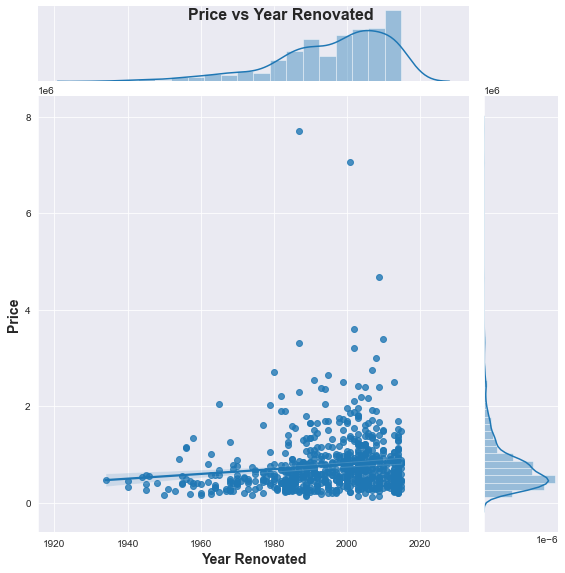

In [66]:
## check trends for the houses that have been renovated
print('Number of renovated houses: {}'.format(len(data.loc[data['yr_renovated']!=0].dropna())))
for year in [2010, 2005, 2000, 1995, 1990, 1980, 1970, 1960, 1950]:
    print('Number of houses renovated since {}: {}'.format(
                                                    year, 
                                                    len(data.loc[(data['yr_renovated']>=year)
                                                                ].dropna())))
print()
print(check_col(data.loc[data['yr_renovated']!=0]['yr_renovated']))
g = sns.jointplot(x='yr_renovated', y='price', data=data.loc[data['yr_renovated']!=0], kind='reg', height=8)
g.fig.suptitle('Price vs Year Renovated', fontsize=16, weight='bold')
g.set_axis_labels('Year Renovated', 'Price', fontsize=14, weight='bold');

> - There are some definite outliers here, but it does seem like price tends to increase the more recently a house was renovated. However, only 445 houses have been renovated in the past 2 decades. Does it really matter if a house was renovated if that occurred decades ago?

In [67]:
def bin_by_decade(year):
    """Assign a decade based on year."""
    if year > 2009:
        return 2010
    elif (year < 2010) & (year > 1999):
        return 2000
    elif (year < 2000) & (year > 1989):
        return 1990
    elif (year < 1990) & (year > 1979):
        return 1980
    elif (year < 1980) & (year > 1969):
        return 1970
    elif (year < 1970) & (year > 1959):
        return 1960
    elif (year < 1960) & (year > 1949):
        return 1950
    elif (year < 1950) & (year > 1939):
        return 1940
    elif (year < 1940) & (year > 1929):
        return 1930
    else:
        return year

In [68]:
data['dec_renovated'] = data['yr_renovated'].apply(bin_by_decade)
check_col(data['dec_renovated'])

*** dec_renovated ***
---------------
Data Type: float64
% Null: 17.647058823529413
---------------
Value Counts:
 0.000       16900
nan          3780
2000.000      229
2010.000      150
1990.000      142
1980.000      122
1970.000       42
1960.000       30
1950.000       16
1940.000        8
1930.000        1
Name: dec_renovated, dtype: int64
---------------
Min: 0.0
Max:2010.0


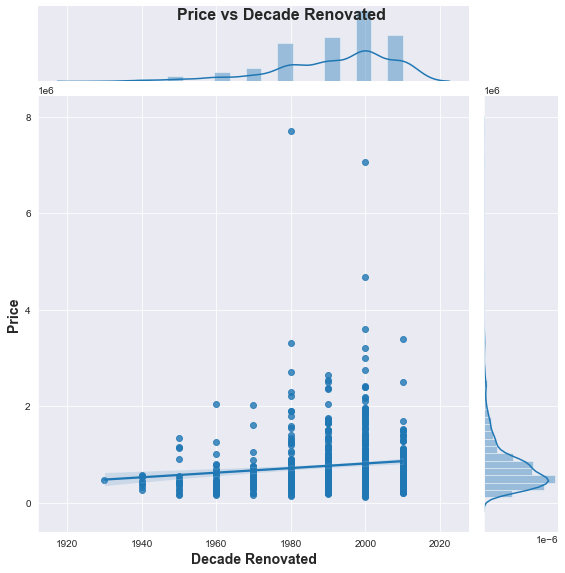

In [69]:
g = sns.jointplot(x='dec_renovated', y='price', data=data.loc[data['dec_renovated']!=0], kind='reg', height=8)
g.fig.suptitle('Price vs Decade Renovated', fontsize=16, weight='bold')
g.set_axis_labels('Decade Renovated', 'Price', fontsize=14, weight='bold');

> - There are still some definite outliers here, but it still seems like price tends to increase the more recently a house was renovated.

In [70]:
data['dec_reno_cat_unk'] = data['dec_renovated'].fillna(value='Unknown').astype('category')
check_col(data['dec_reno_cat_unk'])

*** dec_reno_cat_unk ***
---------------
Data Type: category
% Null: 0.0
---------------
Value Counts:
 0.0        16900
Unknown     3780
2000.0       229
2010.0       150
1990.0       142
1980.0       122
1970.0        42
1960.0        30
1950.0        16
1940.0         8
1930.0         1
Name: dec_reno_cat_unk, dtype: int64
---------------


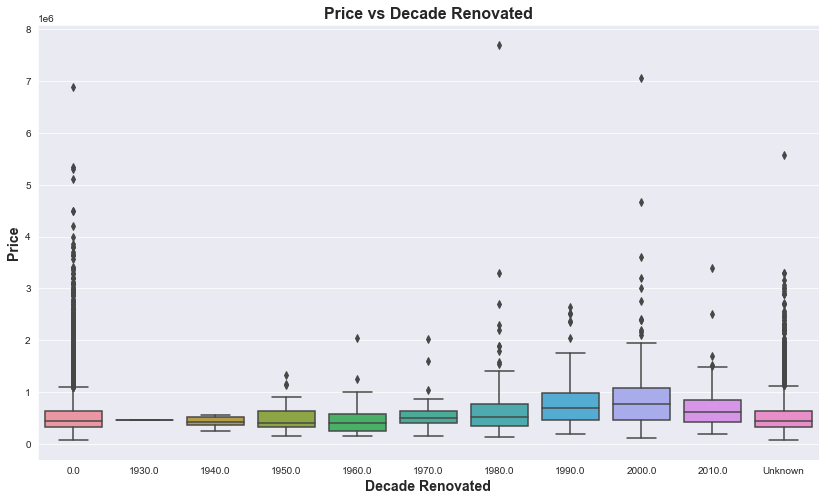

In [71]:
plt.figure(figsize=(14,8))
ax = sns.boxplot(x=data['dec_reno_cat_unk'], y=data['price'])
ax.set_title('Price vs Decade Renovated', fontsize=16, weight='bold')
ax.set_xlabel('Decade Renovated', fontsize=14, weight='bold')
ax.set_ylabel('Price', fontsize=14, weight='bold');

> - It still appears as if there may be some affect of more recent renovations on price. The distribution of the 'unknown' (missing value) category seen above looks very to that of the category for houses that were never renovated (0.0). The two categories are combined below.

In [72]:
data['dec_reno_cat_fill0'] = data['dec_renovated'].fillna(value=0).astype('category')
check_col(data['dec_reno_cat_fill0'])

*** dec_reno_cat_fill0 ***
---------------
Data Type: category
% Null: 0.0
---------------
Value Counts:
 0.000       20680
2000.000      229
2010.000      150
1990.000      142
1980.000      122
1970.000       42
1960.000       30
1950.000       16
1940.000        8
1930.000        1
Name: dec_reno_cat_fill0, dtype: int64
---------------


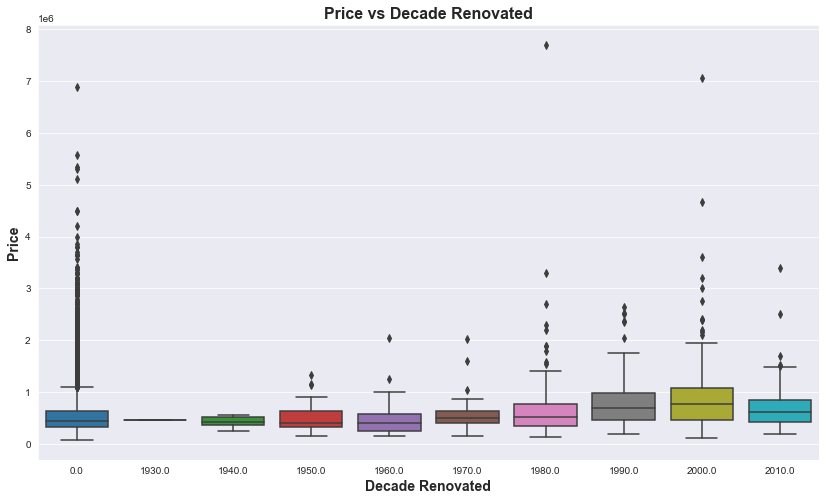

In [73]:
plt.figure(figsize=(14,8))
ax = sns.boxplot(x=data['dec_reno_cat_fill0'], y=data['price'])
ax.set_title('Price vs Decade Renovated', fontsize=16, weight='bold')
ax.set_xlabel('Decade Renovated', fontsize=14, weight='bold')
ax.set_ylabel('Price', fontsize=14, weight='bold');

> - The majority of the houses were never renovated, so it could also make sense to recast yr_renovated as a binary categorical variable: renovated (1) or never renovated (0).

*** renovated ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 0    20680
1      740
Name: renovated, dtype: int64
---------------
Min: 0
Max:1
None


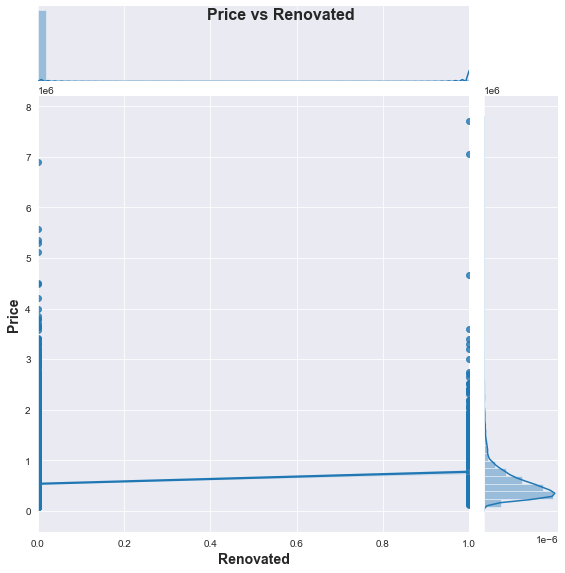

In [74]:
## create a column that bins yr_renovated as either renovated or never renovated 
data['renovated'] = data['yr_renovated'].apply(lambda x: col_to_binary(x))
print(check_col(data['renovated']))
g = sns.jointplot(x='renovated', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Renovated', fontsize=16, weight='bold')
g.set_axis_labels('Renovated', 'Price', fontsize=14, weight='bold');

> - There may be a slight increase in price for those houses that were renovated compared to those that weren't.

### Lat

*** lat ***
---------------
Data Type: float64
% Null: 0.0
---------------
Value Counts:
 47.662    17
47.532    17
47.549    17
47.685    17
47.671    16
          ..
47.749     1
47.655     1
47.398     1
47.599     1
47.272     1
Name: lat, Length: 5033, dtype: int64
---------------
Min: 47.1559
Max:47.7776
None


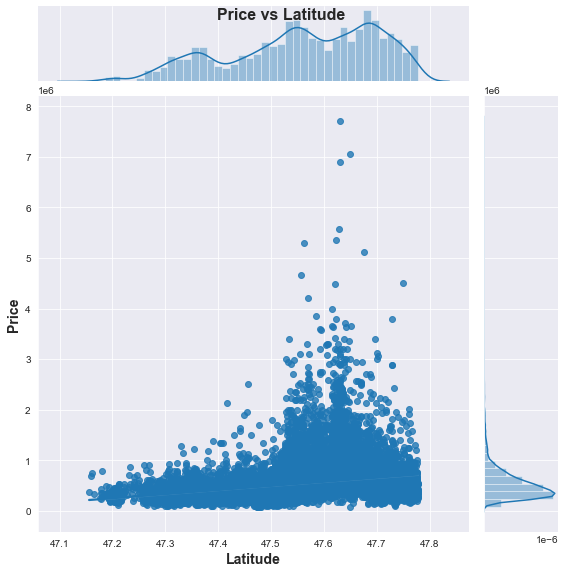

In [75]:
print(check_col(data['lat']))
g = sns.jointplot(x='lat', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Latitude', fontsize=16, weight='bold')
g.set_axis_labels('Latitude', 'Price', fontsize=14, weight='bold');

> - It's possible that price tends to increase with increasing latitude (further north), but this may be mostly driven by outliers.

### Long

*** long ***
---------------
Data Type: float64
% Null: 0.0
---------------
Value Counts:
 -122.290    113
-122.300    110
-122.362    102
-122.291    100
-122.363     99
           ... 
-122.467      1
-121.403      1
-121.804      1
-121.726      1
-121.893      1
Name: long, Length: 751, dtype: int64
---------------
Min: -122.51899999999999
Max:-121.315
None


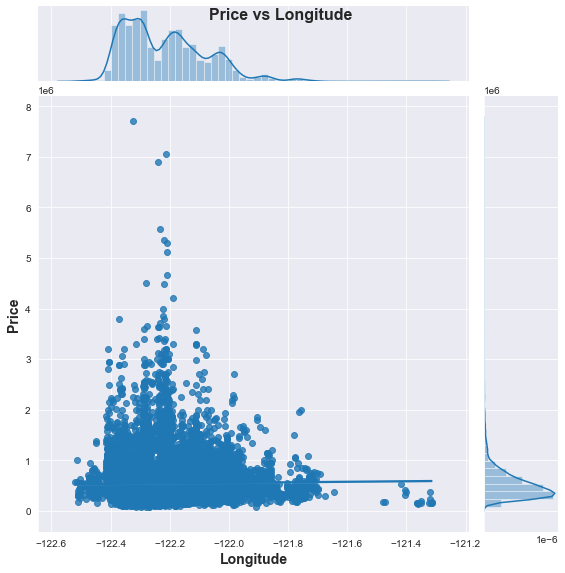

In [76]:
print(check_col(data['long']))
g = sns.jointplot(x='long', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Longitude', fontsize=16, weight='bold')
g.set_axis_labels('Longitude', 'Price', fontsize=14, weight='bold');

> - There is no clearly discernible relationship between price and longitude.

### Zipcode

*** zipcode ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 98103    600
98038    586
98115    576
98052    571
98117    548
        ... 
98102    104
98010     99
98024     79
98148     56
98039     49
Name: zipcode, Length: 70, dtype: int64
---------------
Min: 98001
Max:98199
None


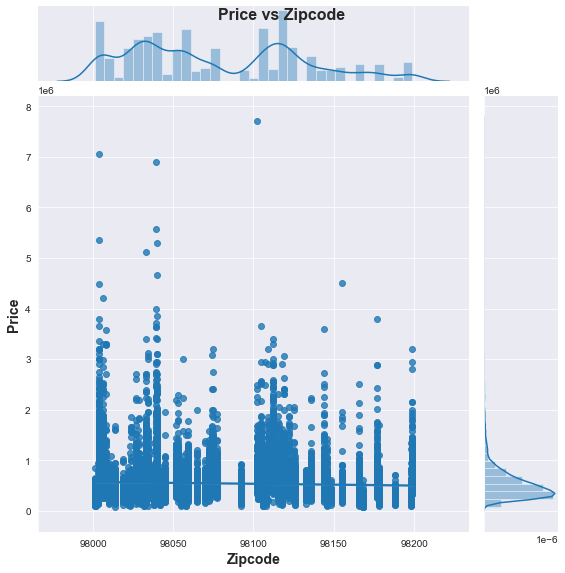

In [77]:
print(check_col(data['zipcode']))
g = sns.jointplot(x='zipcode', y='price', data=data, kind='reg', height=8)
g.fig.suptitle('Price vs Zipcode', fontsize=16, weight='bold')
g.set_axis_labels('Zipcode', 'Price', fontsize=14, weight='bold');

> - There is not a linear relationship between zipcode and price, but this is not surprising since zipcode is better treated as a categorical variable.

In [78]:
## change zipcode to string to use as categorical
data['zipcode'] = data['zipcode'].astype('str')

## ANSWER: QUESTION 1

> - The variables sqft_living, sqft_above, bathrooms, and grade show the clearest linear relationship with price. These are likely to be good predictors, but may be strongly intercorrelated with each other.

In [80]:
## set output filepath for saving figures
folder = %pwd
fig_filepath = folder+'/Figures/'

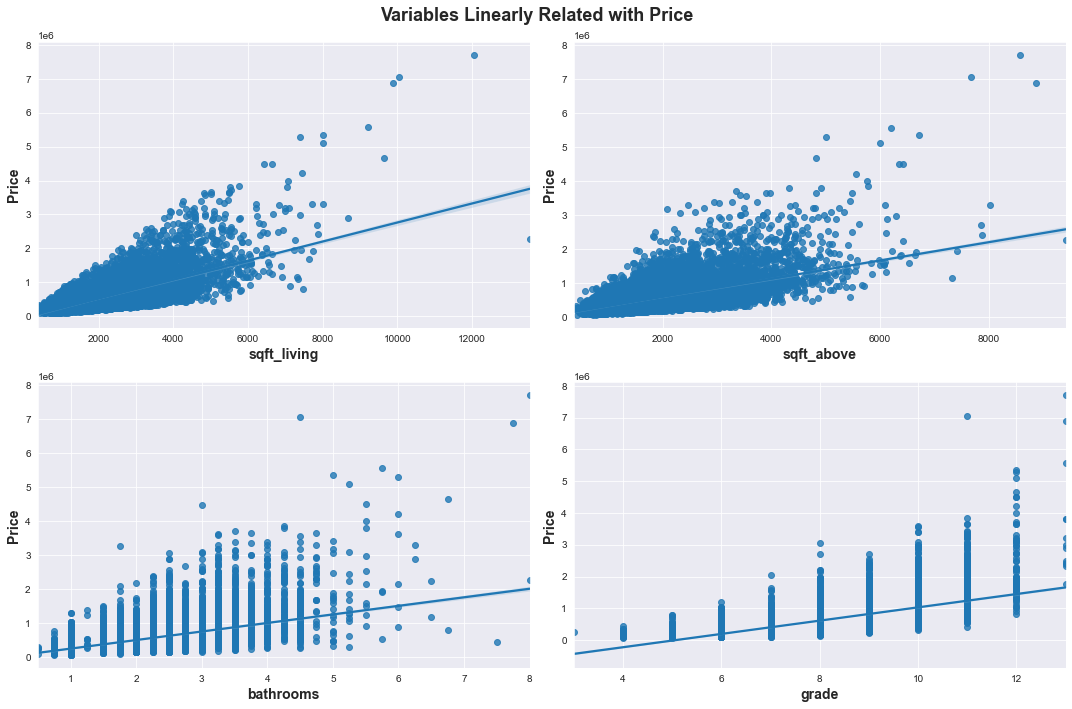

In [81]:
lin_vars = ['sqft_living', 'sqft_above', 'bathrooms', 'grade']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for ax, var in zip(axes.flatten(),lin_vars):
    sns.regplot(x=var, y='price', data=data, ax=ax)
    ax.set_xlabel(xlabel=var, fontsize=14, weight='bold')
    ax.set_ylabel(ylabel='Price', fontsize=14, weight='bold')
    
fig.suptitle('Variables Linearly Related with Price', fontsize=18, weight='bold') 

plt.tight_layout()

plt.savefig(fig_filepath+'Variables Linearly Related with Price')

plt.show()

> - The variables month_sold, yr_sold, sqft_lot (and sqft_lot15), and longitude (long) show no linear relationship with price. They will not be included in any models.

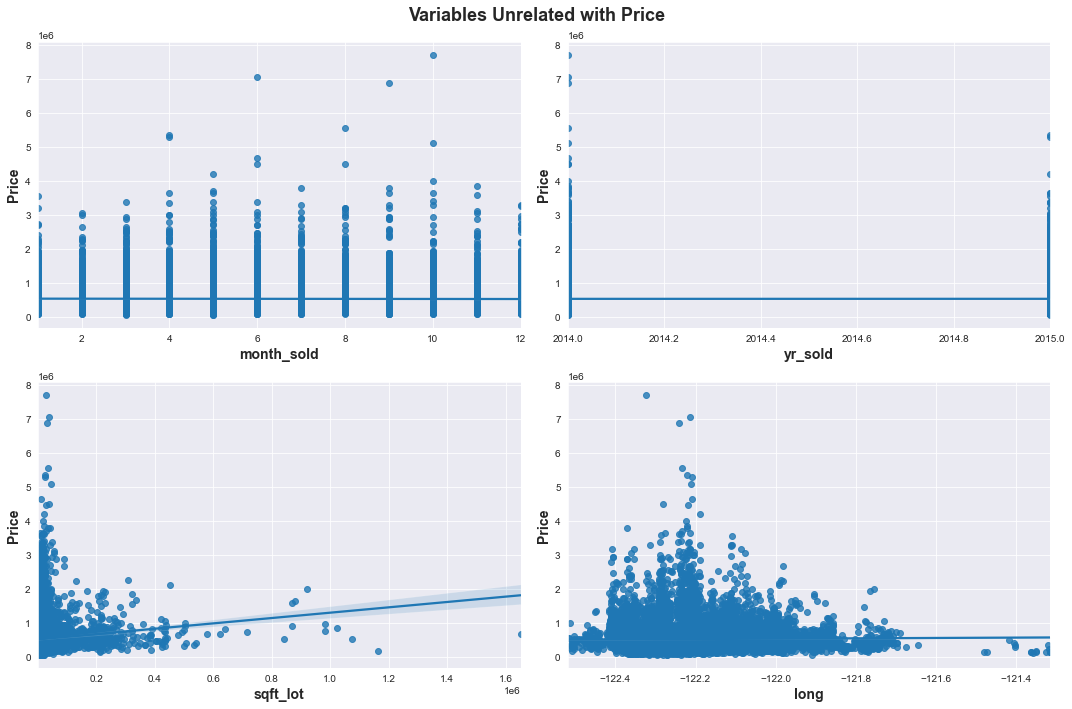

In [82]:
nonlin_vars = ['month_sold', 'yr_sold', 'sqft_lot', 'long']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for ax, var in zip(axes.flatten(), nonlin_vars):
    sns.regplot(x=var, y='price', data=data, ax=ax)
    ax.set_xlabel(xlabel=var, fontsize=14, weight='bold')
    ax.set_ylabel(ylabel='Price', fontsize=14, weight='bold')
    
fig.suptitle('Variables Unrelated with Price', fontsize=18, weight='bold')

plt.tight_layout()

plt.savefig(fig_filepath+'Variables Unrelated with Price')
plt.show()

## Check Correlations for All Variables

In [83]:
data.corr()

id  price  bedrooms  bathrooms  sqft_living  sqft_lot  ...  month_sold    age  est_sqft_basement  basement  dec_renovated  renovated
id                 1.000 -0.018     0.002      0.004       -0.013    -0.133  ...      -0.011 -0.021             -0.006     0.002         -0.012     -0.011
price             -0.018  1.000     0.317      0.525        0.701     0.089  ...      -0.008 -0.051              0.324     0.180          0.130      0.118
bedrooms           0.002  0.317     1.000      0.529        0.594     0.034  ...      -0.001 -0.161              0.309     0.164          0.019      0.018
bathrooms          0.004  0.525     0.529      1.000        0.756     0.088  ...       0.009 -0.507              0.283     0.163          0.052      0.047
sqft_living       -0.013  0.701     0.594      0.756        1.000     0.173  ...       0.014 -0.317              0.435     0.203          0.056      0.051
sqft_lot          -0.133  0.089     0.034      0.088        0.173     1.000  ...      -0.003 -0.052              0.015    -0.036          0.005      0.005
floors             0.018  0.255     0.184      0.502        0.353    -0.006  ...       0.016 -0.489             -0.246    -0.257          0.003      0.003
waterfront        -0.004  0.265    -0.002      0.064        0.105     0.021  ...       0.008  0.025              0.083     0.040          0.082      0.074
condition         -0.024  0.034     0.023     -0.129       -0.062    -0.009  ...       0.024  0.364              0.174     0.136         -0.062     -0.056
grade              0.006  0.667     0.368      0.666        0.762     0.114  ...       0.012 -0.447              0.167     0.050          0.017      0.015
sqft_above        -0.012  0.604     0.494      0.686        0.877     0.183  ...       0.012 -0.423             -0.053    -0.212          0.022      0.020
yr_built           0.021  0.051     0.160      0.506        0.317     0.052  ...      -0.004 -1.000             -0.135    -0.169         -0.226     -0.203
yr_renovated      -0.012  0.130     0.019      0.052        0.056     0.005  ...       0.009  0.225              0.075     0.052          1.000      1.000
lat               -0.003  0.306    -0.013      0.023        0.051    -0.086  ...       0.016  0.148              0.109     0.137          0.032      0.028
long               0.019  0.020     0.137      0.224        0.240     0.230  ...      -0.008 -0.409             -0.146    -0.238         -0.072     -0.065
sqft_living15     -0.004  0.584     0.406      0.569        0.756     0.144  ...       0.004 -0.325              0.199     0.043          0.000      0.001
sqft_lot15        -0.139  0.082     0.032      0.088        0.184     0.718  ...       0.003 -0.070              0.018    -0.041          0.004      0.004
yr_sold            0.010  0.001    -0.010     -0.029       -0.031     0.005  ...      -0.783  0.014             -0.016    -0.007         -0.023     -0.020
month_sold        -0.011 -0.008    -0.001      0.009        0.014    -0.003  ...       1.000 -0.008              0.007     0.006          0.009      0.008
age               -0.021 -0.051    -0.161     -0.507       -0.317    -0.052  ...      -0.008  1.000              0.134     0.169          0.225      0.203
est_sqft_basement -0.006  0.324     0.309      0.283        0.435     0.015  ...       0.007  0.134              1.000     0.819          0.075      0.068
basement           0.002  0.180     0.164      0.163        0.203    -0.036  ...       0.006  0.169              0.819     1.000          0.052      0.047
dec_renovated     -0.012  0.130     0.019      0.052        0.056     0.005  ...       0.009  0.225              0.075     0.052          1.000      1.000
renovated         -0.011  0.118     0.018      0.047        0.051     0.005  ...       0.008  0.203              0.068     0.047          1.000      1.000

[24 rows x 24 columns]

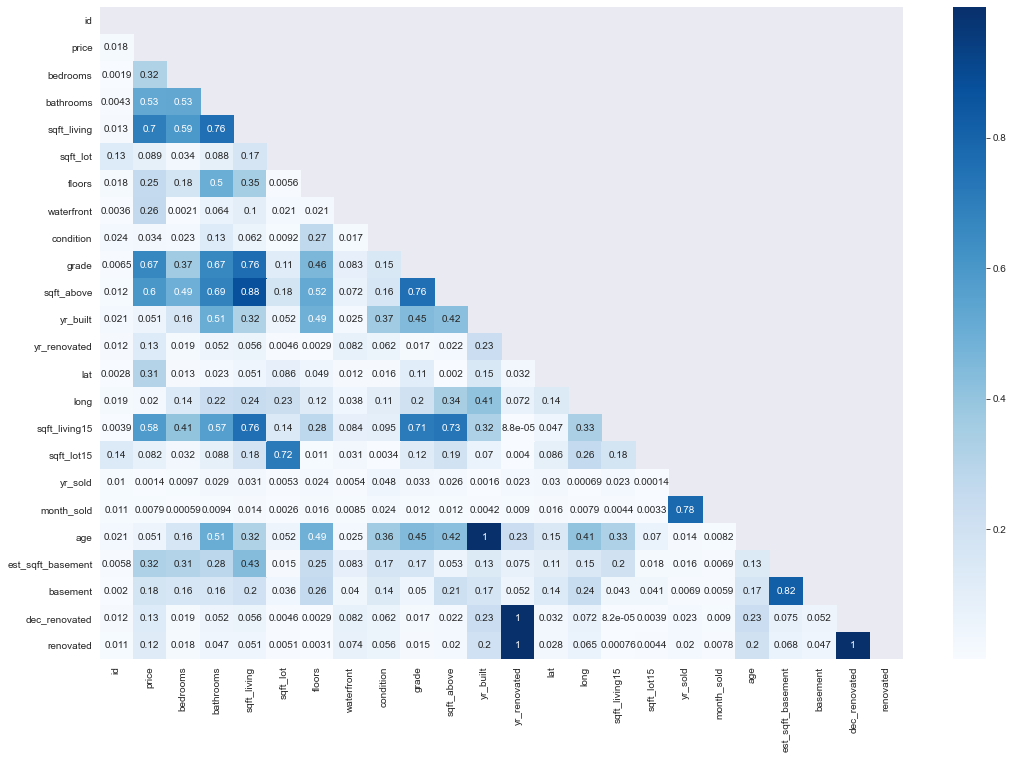

In [84]:
## plot correlations among variables as an annotated heatmap
corr = data.corr().abs()
mask = np.zeros_like(corr)
## mask the correlations of the variables with themselves along the diagonal and all duplicate
 ## correlations to the right of that line
mask[np.triu_indices_from(mask)] = True
mask
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True, cmap='Blues', mask=mask);

Variables that are highly correlated need to be dropped to reduce the problems associated with multicollinearity when building regression models.

The grade column is a summary statistic/ metric awarded by the county based on certain criteria. These criteria take into account the square footage of the living area, so grade is strongly correlated with sqft_living and sqft_above.

The square footage above-ground variable is highly correlated with the square footage of living space, especially since a substantial number of houses do not have basements. Square footage of living space is more highly correlated with price, so I will likely keep that variable in the model, as well as a basement variable, and drop sqft_above. Both the sqft_living and sqft_above variables are also highly correlated with the number of bathrooms, and with grade. I will test models that do not include variables with correlations of 0.75 or greater. Since price is most highly correlated with sqft_living out of all the variables I will try one model that includes sqft_living and excludes the variables with which sqft_living is highly correlated (>= 0.75: bathrooms, sqft_above, grade). I will compare this with another model that excludes price and includes bathrooms and sqft_above (grade will still be excluded because it is highly correlated with sqft_above [0.76]).

The sqft_lot15 and sqft_living15 variables (averages for 15 nearest neighbors) are highly correlated with the sqft_lot and sqft_living (respectively) of the house itself.

## ANSWER: QUESTION 2

The following variables will be included in the initial models as the following variable types:
- **Continuous**
 - sqft_living
 - sqft_above - (include when sqft_living dropped from model)
 - sqft_living15 - (include when sqft_living dropped from model)
 - est_sqft_basement
 - age
 - lat
 - grade -(include in final model when outliers have been dropped and correlation with sqft_living is not as strong)
 
 
- **Ordinal Categorical**
 - bedrooms
 - bathrooms - (include when sqft_living dropped from model)
 - floors
 

- **Categorical**
 - waterfront
 - condition
 - renovated
 - zipcode
 
 
The remaining variables will not be included in the model either because they were found to have no clear relationship with price (yr_sold, month_sold, season_sold, long, sqft_lot), they are highly correlated with sqft_living which is most highly correlated with price (sqft_living15, sqft_above), or they are an alternative form of a variable selected to use in the model (e.g. I chose the binary renovated variable, so I'm leaving out other forms of year renovated variable).

# EXPLORE

## QUESTION 3: How does the method of outlier removal influence model performance?

In [85]:
## Check for outliers
from scipy import stats

def z_outliers(variable, cutoff=3 , verbose=True):
    
    """Takes in a variable as a series/ dataframe column and calculates the absolute value of the 
       z-score for each observation. It returns a series with the same index as the data with True 
       if the observation is an outlier (defined as having a z-score of 3 standard deviations (default) 
       from the mean) or False if the observation is not an outlier."""
    
    z_scores = np.abs(stats.zscore(variable))
    z_scores = pd.Series(z_scores, index=variable.index)
    idx_outliers = z_scores > cutoff
    
    if verbose:
        print('Z-score method found {} outliers.'.format(idx_outliers.sum()))
    
    return idx_outliers





def IQR_outliers(variable, verbose=True):
    
    """Takes in a variable as a series/ dataframe column and calculates the absolute value of the 
       z-score for each observation. It returns a series with the same index as the data with True 
       if the observation is an outlier (defined as having a z-score of 3 standard deviations (default) 
       from the mean) or False if the observation is not an outlier."""
    
    upper_q = variable.quantile(q=0.75)
    lower_q = variable.quantile(q=0.25)
    IQR = upper_q - lower_q
    thresh = 1.5*IQR
    
    idx_outliers = (variable < lower_q-thresh) | (variable > upper_q+thresh)
    
    if verbose:
        print('IQR method found {} outliers.'.format(idx_outliers.sum()))
    
    return idx_outliers

### Price Outliers

In [86]:
## create a series that denotes outliers outliers based on z-scores (True if outlier, False if not)
price_z_outliers = z_outliers(data['price'])

## create a series that denotes outliers outliers based on IQR (True if outlier, False if not)
price_IQR_outliers = IQR_outliers(data['price'])

Z-score method found 404 outliers.
IQR method found 1152 outliers.


In [87]:
## create a dataset that drops all z-score outliers
data_z = data[~price_z_outliers]

## create a dataset that drops all IQR outliers
data_IQR = data[~price_IQR_outliers]

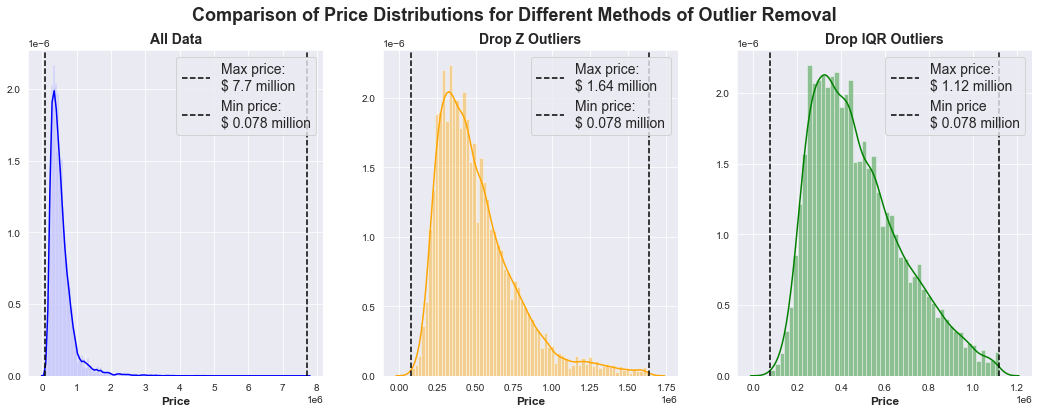

In [88]:
## plot distributions of price to compare full and cleaned datasets
fig, axes = plt.subplots(ncols=3, figsize=(18,6))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

sns.distplot(data['price'], bins='auto', color='b', ax=ax1)
ax1.set_title('All Data', fontsize=14, weight='bold')
ax1.set_xlabel('Price', fontsize=12, weight='bold')
ax1.axvline(x=data['price'].max(), color='k', linestyle='--',
            label='Max price:\n$ {} million'.format(data['price'].max() / 1000000))
ax1.axvline(x=data['price'].min(), color='k', linestyle='--',
            label='Min price:\n$ {} million'.format(data['price'].min() / 1000000))
ax1.legend(fontsize=14, loc='upper right')

sns.distplot(data_z['price'], bins='auto', color='orange', ax=ax2)
ax2.set_title('Drop Z Outliers', fontsize=14, weight='bold')
ax2.set_xlabel('Price', fontsize=12, weight='bold')
ax2.axvline(x=data_z['price'].max(), color='k', linestyle='--',
            label='Max price:\n$ {} million'.format(data_z['price'].max() / 1000000))
ax2.axvline(x=data_z['price'].min(), color='k', linestyle='--',
            label='Min price:\n$ {} million'.format(data_z['price'].min() / 1000000))
ax2.legend(fontsize=14, loc='upper right')

sns.distplot(data_IQR['price'], bins='auto', color='g', ax=ax3)
ax3.set_title('Drop IQR Outliers', fontsize=14, weight='bold')
ax3.set_xlabel('Price', fontsize=12, weight='bold')
ax3.axvline(x=data_IQR['price'].max(), color='k', linestyle='--',
            label='Max price:\n$ {} million'.format(data_IQR['price'].max() / 1000000))
ax3.axvline(x=data_IQR['price'].min(), color='k', linestyle='--',
            label='Min price\n$ {} million'.format(data_IQR['price'].min() / 1000000))
ax3.legend(fontsize=14, loc='upper right')

fig.suptitle('Comparison of Price Distributions for Different Methods of Outlier Removal',
             fontsize=18, weight='bold')

plt.savefig(fig_filepath+'Comparison of Price Distributions for Different Methods of Outlier Removal')
plt.show()

>- The IQR method is more stringent in terms of what it considers an outlier. It removed nearly 3 times the number of observations compared to removing outliers based on z-scores (1152 observations compared to 404).
- Removing price outliers has definitely reduced the skew of this variable, making the distributions appear closer to normal, though they are still right-skewed (the z-score cleaned data more so than the IQR cleaned data).
- The minimum price did not change across the datasets, but the maximum price dropped substantially from \\$7.7 million to $1.64 million when z-score outliers were removed, and then slightly again to \\$1.12 million. Interpretations of models run on the different datasets will need to be reported with this in mind.

In [89]:
data.describe()

id       price  bedrooms  bathrooms  sqft_living    sqft_lot  ...  month_sold       age  est_sqft_basement  basement  dec_renovated  renovated
count      21420.000   21420.000 21420.000  21420.000    21420.000   21420.000  ...   21420.000 21420.000          21420.000 21420.000      17640.000  21420.000
mean  4580939869.158  541861.428     3.373      2.118     2083.133   15128.038  ...       6.564    43.233            291.962     0.393         83.550      0.035
std   2876761172.448  367556.938     0.903      0.769      918.808   41530.797  ...       3.118    29.389            442.876     0.488        399.303      0.183
min      1000102.000   78000.000     1.000      0.500      370.000     520.000  ...       1.000     0.000              0.000     0.000          0.000      0.000
25%   2123537386.750  324950.000     3.000      1.750     1430.000    5040.000  ...       4.000    17.000              0.000     0.000          0.000      0.000
50%   3904921185.000  450550.000     3.000      2.250     1920.000    7614.000  ...       6.000    39.000              0.000     0.000          0.000      0.000
75%   7308900186.250  645000.000     4.000      2.500     2550.000   10690.500  ...       9.000    63.000            560.000     1.000          0.000      0.000
max   9900000190.000 7700000.000    11.000      8.000    13540.000 1651359.000  ...      12.000   115.000           4820.000     1.000       2010.000      1.000

[8 rows x 24 columns]

In [90]:
data_z.describe()

id       price  bedrooms  bathrooms  sqft_living    sqft_lot  ...  month_sold       age  est_sqft_basement  basement  dec_renovated  renovated
count      21016.000   21016.000 21016.000  21016.000    21016.000   21016.000  ...   21016.000 21016.000          21016.000 21016.000      17311.000  21016.000
mean  4593098963.197  508447.459     3.355      2.090     2035.155   14863.675  ...       6.568    43.304            281.148     0.388         79.265      0.033
std   2878358699.358  259118.064     0.893      0.736      837.254   40539.842  ...       3.117    29.299            425.524     0.487        389.352      0.178
min      1000102.000   78000.000     1.000      0.500      370.000     520.000  ...       1.000     0.000              0.000     0.000          0.000      0.000
25%   2126049139.500  320000.000     3.000      1.500     1420.000    5001.750  ...       4.000    18.000              0.000     0.000          0.000      0.000
50%   3905030260.000  449500.000     3.000      2.250     1900.000    7560.000  ...       6.000    39.000              0.000     0.000          0.000      0.000
75%   7334500097.500  630000.000     4.000      2.500     2510.000   10496.250  ...       9.000    63.000            540.000     1.000          0.000      0.000
max   9900000190.000 1640000.000    11.000      7.500     7480.000 1651359.000  ...      12.000   115.000           2850.000     1.000       2010.000      1.000

[8 rows x 24 columns]

In [91]:
data_IQR.describe()

id       price  bedrooms  bathrooms  sqft_living    sqft_lot  ...  month_sold       age  est_sqft_basement  basement  dec_renovated  renovated
count      20268.000   20268.000 20268.000  20268.000    20268.000   20268.000  ...   20268.000 20268.000          20268.000 20268.000      16702.000  20268.000
mean  4604434224.741  478114.357     3.330      2.054     1977.859   14621.276  ...       6.568    43.419            267.355     0.380         74.038      0.031
std   2877553234.694  207440.509     0.883      0.710      774.469   40148.186  ...       3.120    29.171            409.136     0.485        376.787      0.172
min      1000102.000   78000.000     1.000      0.500      370.000     520.000  ...       1.000     0.000              0.000     0.000          0.000      0.000
25%   2132807640.000  316000.000     3.000      1.500     1400.000    5000.000  ...       4.000    18.000              0.000     0.000          0.000      0.000
50%   3905081210.000  439000.000     3.000      2.000     1860.000    7500.000  ...       6.000    40.000              0.000     0.000          0.000      0.000
75%   7338200172.500  602000.000     4.000      2.500     2440.000   10320.000  ...       9.000    63.000            510.000     1.000          0.000      0.000
max   9900000190.000 1120000.000    11.000      7.500     7480.000 1651359.000  ...      12.000   115.000           2720.000     1.000       2010.000      1.000

[8 rows x 24 columns]

> Other than price, the range of most variables appears relatively unchanged. The minimum value was unchanged for all variables. 
- The maximum number of bathrooms dropped from 8 in the full dataset to 7.5 in both cleaned datasets. 
- The maximum sqft_living dropped from 13,540 to 7,480 in both cleaned datasets. 
- Maximum grade dropped from 13 to 12 in both cleaned datasets. 
- Maximum sqft_above dropped from 9,410 in the full dataset to 7,320 in the z-score cleaned data, and 5,710 in the IQR cleaned data. 
- Maximum sqft_living15 dropped from 6,210 in the full dataset to 5,790 in the z-score cleaned data, and 5,380 in the IQR cleaned data. 
- Maximum est_sqft_basement dropped from 4,820 in the full dataset to 2,850 in the z-score cleaned data, and 2,720 in the IQR cleaned data. 

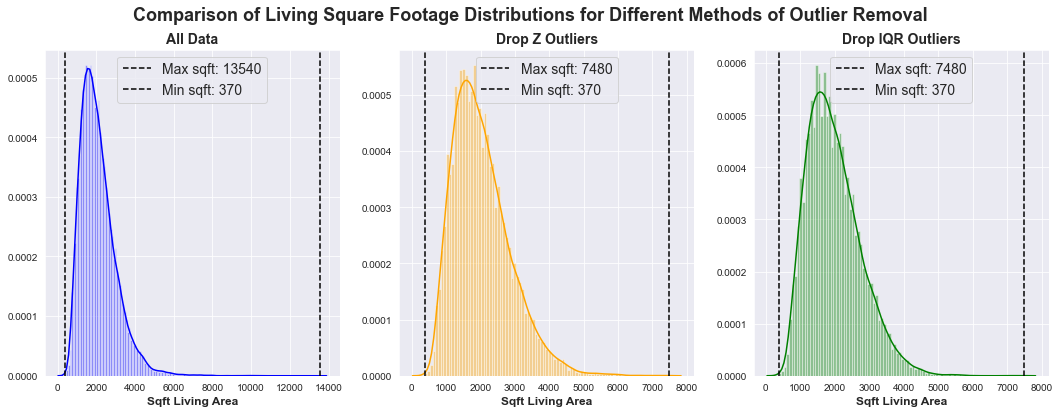

In [92]:
## plot distributions of sqft_living to compare full and cleaned datasets
fig, axes = plt.subplots(ncols=3, figsize=(18,6))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

sns.distplot(data['sqft_living'], bins='auto', color='b', ax=ax1)
ax1.set_title('All Data', fontsize=14, weight='bold')
ax1.set_xlabel('Sqft Living Area', fontsize=12, weight='bold')
ax1.axvline(x=data['sqft_living'].max(), color='k', linestyle='--',
            label='Max sqft: {}'.format(data['sqft_living'].max()))
ax1.axvline(x=data['sqft_living'].min(), color='k', linestyle='--',
            label='Min sqft: {}'.format(data['sqft_living'].min()))
ax1.legend(fontsize=14, loc='upper center')

sns.distplot(data_z['sqft_living'], bins='auto', color='orange', ax=ax2)
ax2.set_title('Drop Z Outliers', fontsize=14, weight='bold')
ax2.set_xlabel('Sqft Living Area', fontsize=12, weight='bold')
ax2.axvline(x=data_z['sqft_living'].max(), color='k', linestyle='--',
            label='Max sqft: {}'.format(data_z['sqft_living'].max()))
ax2.axvline(x=data_z['sqft_living'].min(), color='k', linestyle='--',
            label='Min sqft: {}'.format(data_z['sqft_living'].min()))
ax2.legend(fontsize=14, loc='upper center')

sns.distplot(data_IQR['sqft_living'], bins='auto', color='g', ax=ax3)
ax3.set_title('Drop IQR Outliers', fontsize=14, weight='bold')
ax3.set_xlabel('Sqft Living Area', fontsize=12, weight='bold')
ax3.axvline(x=data_IQR['sqft_living'].max(), color='k', linestyle='--',
            label='Max sqft: {}'.format(data_IQR['sqft_living'].max()))
ax3.axvline(x=data_IQR['sqft_living'].min(), color='k', linestyle='--',
            label='Min sqft: {}'.format(data_IQR['sqft_living'].min()))
ax3.legend(fontsize=14, loc='upper center')

fig.suptitle('Comparison of Living Square Footage Distributions for Different Methods of Outlier Removal',
             fontsize=18, weight='bold')

plt.savefig(fig_filepath+
            'Comparison of Living Square Footage Distributions for Different Methods of Outlier Removal')
plt.show()

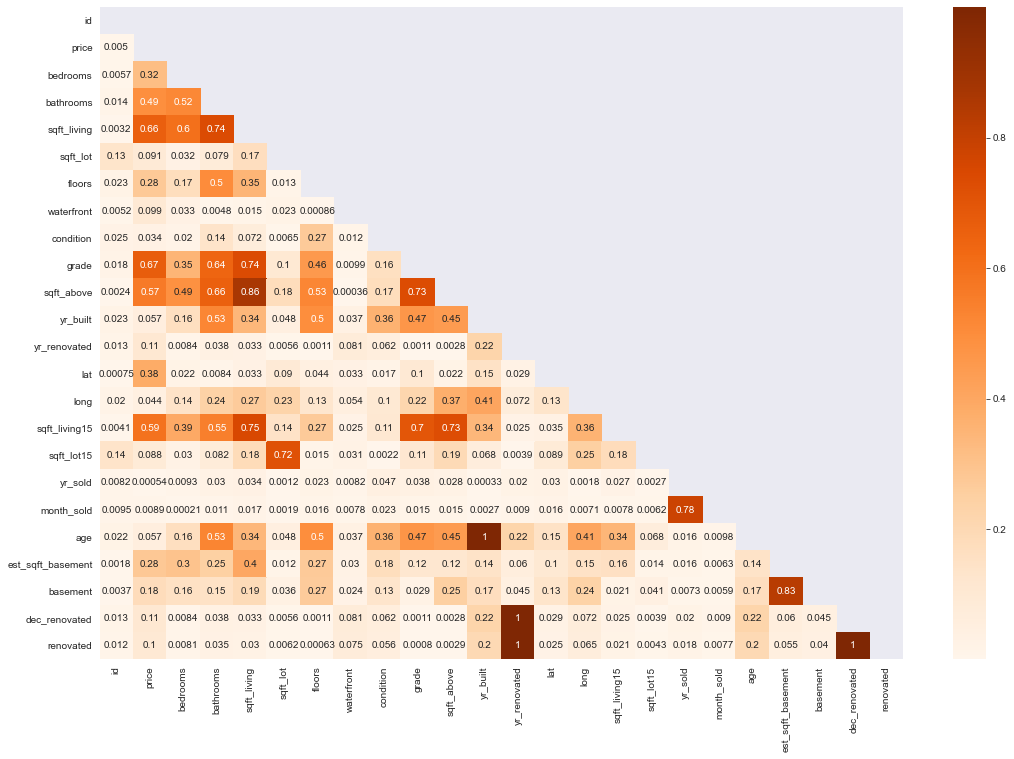

In [93]:
## plot correlations among variables in the z-score cleaned data as an annotated heatmap
corr = data_z.corr().abs()
mask = np.zeros_like(corr)
## mask the correlations of the variables with themselves along the diagonal and all duplicate
 ## correlations to the right of that line
mask[np.triu_indices_from(mask)] = True
mask
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True, cmap='Oranges', mask=mask);

> - Now grade is slightly more correlated with price than sqft_living (grade:0.67, sqft_living: 0.66) whereas prior to outlier removal sqft_living was more strongly correlated with price than grade (grade: 0.67, sqft_living: 0.70). 
- Grade and sqft_living are still strongly correlated (0.74), but this falls just below the cutoff for excluding one from the model. 
- Based on a cutoff of 0.75, sqft_living should not be included in the model with sqft_living15 or sqft_above.

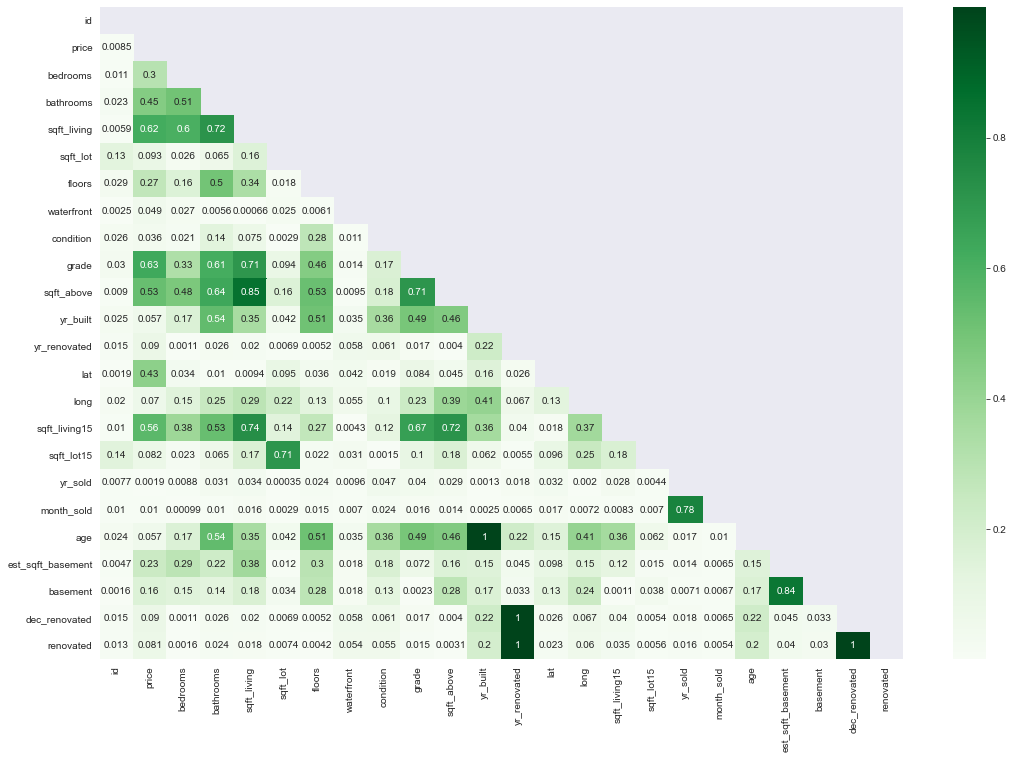

In [94]:
## plot correlations among variables in the IQR cleaned data as an annotated heatmap
corr = data_IQR.corr().abs()
mask = np.zeros_like(corr)
## mask the correlations of the variables with themselves along the diagonal and all duplicate
 ## correlations to the right of that line
mask[np.triu_indices_from(mask)] = True
mask
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True, cmap='Greens', mask=mask);

> - As seen above, grade is slightly more correlated with price than sqft_living (grade:0.63, sqft_living: 0.62) whereas prior to outlier removal sqft_living was more strongly correlated with price than grade (grade: 0.67, sqft_living: 0.70). 
- Grade and sqft_living are still strongly correlated (0.71), but this is slightly below the cutoff of 0.75.
- The strength of the correlations among these three variables is tending to decrease as more outliers are removed.
- Sqft_living and sqft_above should still not be included in the same model.

# MODEL

In [95]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [96]:
def build_model(target, numerical, categorical, data):
    
    """Takes in a target variable as a string (needs to be a column name in data), 
       a list of variables to be treated as numeric (must be column names in data),
       a list of variables to be treated as categories (must be column names in data - no one-hot encoded).
       Returns a Statsmodels OLS regression model."""
    
    model_vars = list(target) + numerical + categorical
    cat_features = [f'C({feat})' for feat in categorical]
    num_features = numerical
    feature_sum = '+'.join(num_features) + '+' + '+'.join(cat_features) 
    formula = target + '~' + feature_sum
    
    model = ols(formula=formula, data=data).fit()
    
    return model

In [97]:
def check_ols_assumptions(model, data, target, fig_filepath=None, model_name=None):
    
    """Takes in a Statsmodel OLS regression model, the dataframe from which that model was generated,
       and the target variable of that model as a string (needs to be a column name in data).
       Returns a Q-Q plot of the residuals as well as a plot of the residuals against the target
       variable to vizualize homoscedasticity of model errors."""
    
    fig, ax = plt.subplots(ncols=2,figsize=(14,5))
    ax1 = ax[0]
    ax2 = ax[1]
    
    if (len(data) < 21420) & (len(data) > 21000):
        color='orange'
    elif (len(data) < 21000):
        color='g'
    else:
        color='b'

    sm.graphics.qqplot(model.resid, fit=True, line='45', ax=ax1, color=color)
    ax1.set_title('Q-Q Plot of Model Residuals', weight='bold', fontsize='x-large')
    ax1.set_xlabel(ax1.get_xlabel(), weight='bold')
    ax1.set_ylabel(ax1.get_ylabel(), weight='bold')

    sns.scatterplot(x=data[target], y=model.resid, ax=ax2, color=color)
    ax2.axhline(y=0, color='r')
    ax2.set_title('Homoscedasticity of Model Residuals', weight='bold', fontsize='x-large')
    ax2.set_xlabel(ax2.get_xlabel(), weight='bold')
    ax2.set_ylabel('Residual Value', weight='bold')

    if model_name is not None:
        figtitle=model_name+'_residuals'
    if fig_filepath is not None:
        plt.savefig(fig_filepath+figtitle)
    
    return plt.show()

In [98]:
def find_nonsig_features(model, alpha=0.05):
    
    """Given a Statsmodels OLS regression model, returns a Pandas series containing any p-values 
       greater than the specified 
       alpha-level (default alpha = 0.05)."""
    
    return model.pvalues.loc[model.pvalues > alpha]

In [99]:
def find_coefficients(model, positive=False):
    
    """Given a Statsmodels OLS regression model, returns a Pandas series containing any coefficients 
       that are either positive or negative (default is negative)."""
    if positive:
        return model.params.loc[model.params > 0]
    else:
        return model.params.loc[model.params < 0]

## Initial Model - Retain Outliers, No Transformations or Scaling

### Initial Model 1.0  - includes sqft_living

The model below is an initial model without any outliers removed except the house entered as having 33 bedrooms. This was adjusted to have the mean / mode of that column which was 3 bedrooms. For houses that sold more than once during the time period the data were collected, only the most recent sale is retained in the dataset so as not to violate the assumption of independence of observations. None of the variables have been transformed or scaled.

In [100]:
target = 'price'
numerical = ['sqft_living', 'est_sqft_basement',
             'age', 'lat', 
             'bedrooms', 'floors']
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

init_model = build_model(target, numerical, categorical, data)
init_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     949.2
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:10   Log-Likelihood:            -2.8853e+05
No. Observations:               21420   AIC:                         5.772e+05
Df Residuals:                   21338   BIC:                         5.779e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.057e+07   3.21e+06     -3.294      0.001   -1.69e+07   -4.28e+06
C(waterfront)[T.1]   8.716e+05   1.47e+04     59.155      0.000    8.43e+05       9e+05
C(condition)[T.2]    8.469e+04   3.52e+04      2.405      0.016    1.57e+04    1.54e+05
C(condition)[T.3]    8.769e+04   3.26e+04      2.688      0.007    2.37e+04    1.52e+05
C(condition)[T.4]     1.07e+05   3.26e+04      3.280      0.001    4.31e+04    1.71e+05
C(condition)[T.5]    1.499e+05   3.28e+04      4.567      0.000    8.55e+04    2.14e+05
C(renovated)[T.1]    5.349e+04   6791.244      7.877      0.000    4.02e+04    6.68e+04
C(zipcode)[T.98002]  1.042e+04   1.53e+04      0.683      0.495   -1.95e+04    4.03e+04
C(zipcode)[T.98003]  6489.4671   1.38e+04      0.472      0.637   -2.05e+04    3.35e+04
C(zipcode)[T.98004]  7.432e+05   2.48e+04     30.017      0.000    6.95e+05    7.92e+05
C(zipcode)[T.98005]  2.693e+05   2.61e+04     10.314      0.000    2.18e+05     3.2e+05
C(zipcode)[T.98006]  2.691e+05   2.08e+04     12.960      0.000    2.28e+05     3.1e+05
C(zipcode)[T.98007]  2.073e+05   2.68e+04      7.748      0.000    1.55e+05     2.6e+05
C(zipcode)[T.98008]  2.178e+05   2.48e+04      8.784      0.000    1.69e+05    2.66e+05
C(zipcode)[T.98010]  5.145e+04   1.96e+04      2.627      0.009    1.31e+04    8.98e+04
C(zipcode)[T.98011]  2.884e+04   3.39e+04      0.851      0.395   -3.76e+04    9.53e+04
C(zipcode)[T.98014]  1.718e+04   3.05e+04      0.564      0.573   -4.25e+04    7.69e+04
C(zipcode)[T.98019] -1.875e+04   3.29e+04     -0.570      0.568   -8.32e+04    4.57e+04
C(zipcode)[T.98022]  4.296e+04   1.59e+04      2.697      0.007    1.17e+04    7.42e+04
C(zipcode)[T.98023] -1.989e+04   1.19e+04     -1.667      0.096   -4.33e+04    3497.405
C(zipcode)[T.98024]  1.086e+05   2.73e+04      3.985      0.000    5.52e+04    1.62e+05
C(zipcode)[T.98027]  1.363e+05   1.91e+04      7.150      0.000     9.9e+04    1.74e+05
C(zipcode)[T.98028]  3.235e+04   3.32e+04      0.974      0.330   -3.27e+04    9.74e+04
C(zipcode)[T.98029]  1.843e+05   2.16e+04      8.543      0.000    1.42e+05    2.27e+05
C(zipcode)[T.98030] -8753.6653   1.47e+04     -0.597      0.551   -3.75e+04       2e+04
C(zipcode)[T.98031] -4230.0492   1.53e+04     -0.277      0.782   -3.41e+04    2.57e+04
C(zipcode)[T.98032]  1084.5816   1.85e+04      0.059      0.953   -3.52e+04    3.73e+04
C(zipcode)[T.98033]  3.093e+05    2.8e+04     11.037      0.000    2.54e+05    3.64e+05
C(zipcode)[T.98034]  1.297e+05   3.03e+04      4.284      0.000    7.04e+04    1.89e+05
C(zipcode)[T.98038]  8858.6608   1.23e+04      0.722      0.471   -1.52e+04    3.29e+04
C(zipcode)[T.98039]   1.29e+06    3.4e+04     37.941      0.000    1.22e+06    1.36e+06
C(zipcode)[T.98040]   5.18e+05    2.2e+04     23.581      0.000    4.75e+05    5.61e+05
C(z

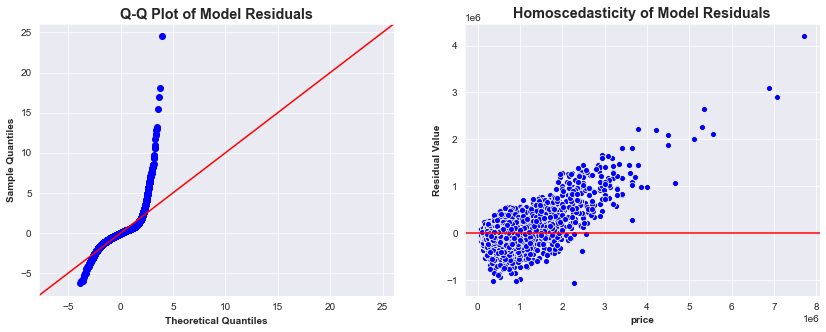

In [101]:
check_ols_assumptions(init_model, data, 'price')

> - The model residuals are definitely extremely non-normally distributed, but this isn't surprising given that no outliers have been removed.
- The residuals also clearly violate the assumption of homoscedasticity. There is a clear trend that the model tends to consistently overestimate the price of less expensive houses and underestimate the price of more expensive houses.

In [102]:
find_nonsig_features(init_model)

C(zipcode)[T.98002]   0.495
C(zipcode)[T.98003]   0.637
C(zipcode)[T.98011]   0.395
C(zipcode)[T.98014]   0.573
C(zipcode)[T.98019]   0.568
C(zipcode)[T.98023]   0.096
C(zipcode)[T.98028]   0.330
C(zipcode)[T.98030]   0.551
C(zipcode)[T.98031]   0.782
C(zipcode)[T.98032]   0.953
C(zipcode)[T.98038]   0.471
C(zipcode)[T.98042]   0.350
C(zipcode)[T.98055]   0.263
C(zipcode)[T.98058]   0.830
C(zipcode)[T.98065]   0.252
C(zipcode)[T.98070]   0.943
C(zipcode)[T.98077]   0.240
C(zipcode)[T.98092]   0.060
C(zipcode)[T.98148]   0.098
C(zipcode)[T.98168]   0.156
C(zipcode)[T.98178]   0.525
C(zipcode)[T.98188]   0.592
C(zipcode)[T.98198]   0.475
age                   0.162
dtype: float64

> - Though 23 of the 70 zipcode categories are not useful as predictors, the majority of zipcodes are useful predictors, so this variable will be retained in the model. 
- Age is not a significant predictor, so it needs to be dropped. 

#### Initial Model 1.1 - Drop Age

The model below is an initial model very similar to the one above, except that the nonsignificant predictor age has been dropped. No outliers have been removed except the house entered as having 33 bedrooms. This was adjusted to have the mean / mode of that column which was 3 bedrooms. For houses that sold more than once during the time period the data were collected, only the most recent sale is retained in the dataset so as not to violate the assumption of independence of observations. None of the variables have been transformed or scaled. 

In [103]:
target = 'price'
numerical = ['sqft_living', 'est_sqft_basement', 'lat', 
             'bedrooms', 'floors']
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

init_model1 = build_model(target, numerical, categorical, data)
init_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     961.0
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:11   Log-Likelihood:            -2.8853e+05
No. Observations:               21420   AIC:                         5.772e+05
Df Residuals:                   21339   BIC:                         5.779e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.054e+07   3.21e+06     -3.282      0.001   -1.68e+07   -4.24e+06
C(waterfront)[T.1]   8.725e+05   1.47e+04     59.272      0.000    8.44e+05    9.01e+05
C(condition)[T.2]    8.363e+04   3.52e+04      2.376      0.018    1.46e+04    1.53e+05
C(condition)[T.3]    8.511e+04   3.26e+04      2.613      0.009    2.13e+04    1.49e+05
C(condition)[T.4]    1.057e+05   3.26e+04      3.240      0.001    4.18e+04     1.7e+05
C(condition)[T.5]    1.491e+05   3.28e+04      4.545      0.000    8.48e+04    2.13e+05
C(renovated)[T.1]    5.605e+04   6541.257      8.568      0.000    4.32e+04    6.89e+04
C(zipcode)[T.98002]  1.084e+04   1.53e+04      0.711      0.477   -1.91e+04    4.07e+04
C(zipcode)[T.98003]  6633.6081   1.38e+04      0.482      0.630   -2.03e+04    3.36e+04
C(zipcode)[T.98004]   7.44e+05   2.48e+04     30.061      0.000    6.96e+05    7.93e+05
C(zipcode)[T.98005]  2.699e+05   2.61e+04     10.339      0.000    2.19e+05    3.21e+05
C(zipcode)[T.98006]  2.694e+05   2.08e+04     12.975      0.000    2.29e+05     3.1e+05
C(zipcode)[T.98007]   2.08e+05   2.68e+04      7.775      0.000    1.56e+05     2.6e+05
C(zipcode)[T.98008]  2.185e+05   2.48e+04      8.812      0.000     1.7e+05    2.67e+05
C(zipcode)[T.98010]  5.134e+04   1.96e+04      2.622      0.009     1.3e+04    8.97e+04
C(zipcode)[T.98011]  2.938e+04   3.39e+04      0.866      0.386   -3.71e+04    9.58e+04
C(zipcode)[T.98014]  1.775e+04   3.04e+04      0.583      0.560   -4.19e+04    7.74e+04
C(zipcode)[T.98019] -1.852e+04   3.29e+04     -0.563      0.573    -8.3e+04    4.59e+04
C(zipcode)[T.98022]  4.298e+04   1.59e+04      2.698      0.007    1.18e+04    7.42e+04
C(zipcode)[T.98023] -1.996e+04   1.19e+04     -1.673      0.094   -4.34e+04    3425.284
C(zipcode)[T.98024]  1.096e+05   2.73e+04      4.023      0.000    5.62e+04    1.63e+05
C(zipcode)[T.98027]  1.366e+05   1.91e+04      7.163      0.000    9.92e+04    1.74e+05
C(zipcode)[T.98028]  3.305e+04   3.32e+04      0.996      0.320    -3.2e+04    9.81e+04
C(zipcode)[T.98029]  1.844e+05   2.16e+04      8.546      0.000    1.42e+05    2.27e+05
C(zipcode)[T.98030] -8868.1853   1.47e+04     -0.604      0.546   -3.76e+04    1.99e+04
C(zipcode)[T.98031] -4332.2819   1.53e+04     -0.284      0.776   -3.42e+04    2.56e+04
C(zipcode)[T.98032]  1749.9416   1.85e+04      0.095      0.925   -3.45e+04     3.8e+04
C(zipcode)[T.98033]  3.098e+05    2.8e+04     11.055      0.000    2.55e+05    3.65e+05
C(zipcode)[T.98034]  1.302e+05   3.03e+04      4.300      0.000    7.08e+04     1.9e+05
C(zipcode)[T.98038]  8404.2727   1.23e+04      0.685      0.493   -1.56e+04    3.25e+04
C(zipcode)[T.98039]  1.291e+06    3.4e+04     37.973      0.000    1.22e+06    1.36e+06
C(zipcode)[T.98040]  5.187e+05    2.2e+04     23.619      0.000    4.76e+05    5.62e+05
C(z

- Most of the coefficients for zipcodes are positive, indicating that most zipcodes are associated with increased price, but there are 6 zipcodes that are associated with lower house prices.
- Est_sqft_basement also appears to have a negative effect on price such that larger basements are associated with lower selling prices. However, this effect is very small such that a 1 sqft increase in basement size is associated with an \\$89 decrease in home price.
- Somewhat surprisingly, it also appears that increasing the number of bedrooms and floors is also associated with much more substantial decreases in home price.


The rest of the variables are associated with increasing home price:
- A 1 sqft increase in living space is associated with a $296 increase in selling price.
- Homes at higher latitudes (further north) tend to sell for more.
- Waterfront homes sell for more than non-waterfront homes.
- Renovated homes sell for more than homes that have never been renovated.
- Homes that are in better condition relative to their age tend to sell for higher prices.

In [104]:
## find variables that negatively impact price
find_coefficients(init_model1)

Intercept             -10536078.122
C(zipcode)[T.98019]      -18515.446
C(zipcode)[T.98023]      -19964.289
C(zipcode)[T.98030]       -8868.185
C(zipcode)[T.98031]       -4332.282
C(zipcode)[T.98042]      -12026.279
C(zipcode)[T.98092]      -24674.270
est_sqft_basement           -88.929
bedrooms                 -39199.200
floors                   -37868.984
dtype: float64

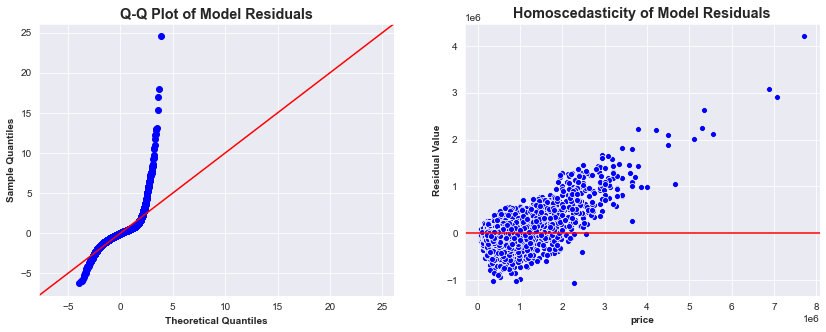

In [105]:
check_ols_assumptions(init_model1, data, 'price', fig_filepath=fig_filepath, model_name='Initial Model 1-0')

> - The plots of the residuals appear the same as before age was dropped from the model.
- The model residuals are definitely extremely non-normally distributed, but this isn't surprising given that no outliers have been removed.
- The residuals also clearly violate the assumption of homoscedasticity. There is a clear trend that the model tends to consistently overestimate the price of less expensive houses and underestimate the price of more expensive houses.

In [106]:
find_nonsig_features(init_model1)

C(zipcode)[T.98002]   0.477
C(zipcode)[T.98003]   0.630
C(zipcode)[T.98011]   0.386
C(zipcode)[T.98014]   0.560
C(zipcode)[T.98019]   0.573
C(zipcode)[T.98023]   0.094
C(zipcode)[T.98028]   0.320
C(zipcode)[T.98030]   0.546
C(zipcode)[T.98031]   0.776
C(zipcode)[T.98032]   0.925
C(zipcode)[T.98038]   0.493
C(zipcode)[T.98042]   0.328
C(zipcode)[T.98055]   0.240
C(zipcode)[T.98058]   0.827
C(zipcode)[T.98065]   0.252
C(zipcode)[T.98070]   0.921
C(zipcode)[T.98077]   0.235
C(zipcode)[T.98092]   0.056
C(zipcode)[T.98148]   0.088
C(zipcode)[T.98168]   0.125
C(zipcode)[T.98178]   0.460
C(zipcode)[T.98188]   0.554
C(zipcode)[T.98198]   0.447
dtype: float64

> - While the 23 zipcodes listed above are not significant predictors of price, the remaining 47 zipcodes are, so this variable will be kept in the model.

### Initial Model 2.0  - excludes sqft_living, replaces with sqft_above, sqft_living15, and bathrooms

The model below is an alternative version of the initial model (1.0) where sqft_living has been replaced with three variables with which it was highly correlated. Everything else remains the same. No outliers have been removed except the house entered as having 33 bedrooms. This was adjusted to have the mean / mode of that column which was 3 bedrooms. For houses that sold more than once during the time period the data were collected, only the most recent sale is retained in the dataset so as not to violate the assumption of independence of observations. None of the variables have been transformed or scaled.

The performance of this model appears to have improved negligibly from an R-squared of 0.783 in the first initial model to 0.787 in this model. The extreme homoscedasticity and non-normality of residuals is the same as that found in the first version of the initial model.

In [107]:
target = 'price'
numerical = ['sqft_above', 'sqft_living15',
             'bathrooms', 'est_sqft_basement',
             'age', 'lat', 
             'bedrooms', 'floors',]
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

init_model2 = build_model(target, numerical, categorical, data)
init_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     951.6
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:12   Log-Likelihood:            -2.8830e+05
No. Observations:               21420   AIC:                         5.768e+05
Df Residuals:                   21336   BIC:                         5.774e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -9.848e+06   3.18e+06     -3.100      0.002   -1.61e+07   -3.62e+06
C(waterfront)[T.1]    8.62e+05   1.46e+04     59.094      0.000    8.33e+05    8.91e+05
C(condition)[T.2]    9.757e+04   3.48e+04      2.800      0.005    2.93e+04    1.66e+05
C(condition)[T.3]    9.755e+04   3.23e+04      3.021      0.003    3.43e+04    1.61e+05
C(condition)[T.4]    1.186e+05   3.23e+04      3.671      0.000    5.53e+04    1.82e+05
C(condition)[T.5]    1.584e+05   3.25e+04      4.875      0.000    9.47e+04    2.22e+05
C(renovated)[T.1]    4.835e+04   6781.845      7.130      0.000    3.51e+04    6.16e+04
C(zipcode)[T.98002]  1.869e+04   1.51e+04      1.236      0.216   -1.09e+04    4.83e+04
C(zipcode)[T.98003]  1393.7091   1.36e+04      0.102      0.919   -2.53e+04    2.81e+04
C(zipcode)[T.98004]  7.267e+05   2.45e+04     29.647      0.000    6.79e+05    7.75e+05
C(zipcode)[T.98005]  2.494e+05   2.59e+04      9.645      0.000    1.99e+05       3e+05
C(zipcode)[T.98006]  2.456e+05   2.06e+04     11.929      0.000    2.05e+05    2.86e+05
C(zipcode)[T.98007]  2.002e+05   2.65e+04      7.563      0.000    1.48e+05    2.52e+05
C(zipcode)[T.98008]  2.145e+05   2.45e+04      8.744      0.000    1.66e+05    2.63e+05
C(zipcode)[T.98010]   5.23e+04   1.94e+04      2.699      0.007    1.43e+04    9.03e+04
C(zipcode)[T.98011]  2.124e+04   3.36e+04      0.633      0.527   -4.45e+04     8.7e+04
C(zipcode)[T.98014]  2.616e+04   3.01e+04      0.868      0.385   -3.29e+04    8.52e+04
C(zipcode)[T.98019] -1.887e+04   3.25e+04     -0.580      0.562   -8.26e+04    4.49e+04
C(zipcode)[T.98022]  4.004e+04   1.58e+04      2.540      0.011    9144.538    7.09e+04
C(zipcode)[T.98023] -2.677e+04   1.18e+04     -2.266      0.023   -4.99e+04   -3613.338
C(zipcode)[T.98024]  1.082e+05    2.7e+04      4.011      0.000    5.53e+04    1.61e+05
C(zipcode)[T.98027]  1.239e+05   1.89e+04      6.562      0.000    8.69e+04    1.61e+05
C(zipcode)[T.98028]  2.998e+04   3.29e+04      0.912      0.362   -3.44e+04    9.44e+04
C(zipcode)[T.98029]  1.734e+05   2.14e+04      8.119      0.000    1.32e+05    2.15e+05
C(zipcode)[T.98030] -1.347e+04   1.45e+04     -0.927      0.354   -4.19e+04     1.5e+04
C(zipcode)[T.98031] -1.027e+04   1.51e+04     -0.680      0.496   -3.99e+04    1.93e+04
C(zipcode)[T.98032]  7514.5534   1.83e+04      0.411      0.681   -2.84e+04    4.34e+04
C(zipcode)[T.98033]  3.049e+05   2.77e+04     10.992      0.000     2.5e+05    3.59e+05
C(zipcode)[T.98034]  1.297e+05      3e+04      4.328      0.000    7.09e+04    1.88e+05
C(zipcode)[T.98038]  -608.0648   1.22e+04     -0.050      0.960   -2.44e+04    2.32e+04
C(zipcode)[T.98039]  1.267e+06   3.37e+04     37.621      0.000     1.2e+06    1.33e+06
C(zipcode)[T.98040]  4.913e+05   2.18e+04     22.560      0.000    4.49e+05    5.34e+05
C(z

In [108]:
## find variables that negatively impact price
find_coefficients(init_model2)

Intercept             -9848335.320
C(zipcode)[T.98019]     -18865.078
C(zipcode)[T.98023]     -26766.450
C(zipcode)[T.98030]     -13469.537
C(zipcode)[T.98031]     -10269.860
C(zipcode)[T.98038]       -608.065
C(zipcode)[T.98042]     -15660.232
C(zipcode)[T.98092]     -31892.902
bedrooms                -41037.287
floors                  -40596.608
dtype: float64

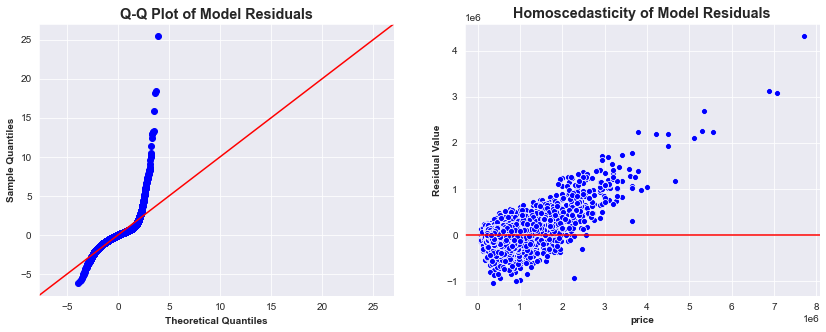

In [109]:
check_ols_assumptions(init_model2, data, 'price', fig_filepath=fig_filepath, model_name='Initial Model 2-0')

In [110]:
find_nonsig_features(init_model2)

C(zipcode)[T.98002]   0.216
C(zipcode)[T.98003]   0.919
C(zipcode)[T.98011]   0.527
C(zipcode)[T.98014]   0.385
C(zipcode)[T.98019]   0.562
C(zipcode)[T.98028]   0.362
C(zipcode)[T.98030]   0.354
C(zipcode)[T.98031]   0.496
C(zipcode)[T.98032]   0.681
C(zipcode)[T.98038]   0.960
C(zipcode)[T.98042]   0.199
C(zipcode)[T.98055]   0.304
C(zipcode)[T.98058]   0.984
C(zipcode)[T.98059]   0.107
C(zipcode)[T.98065]   0.665
C(zipcode)[T.98070]   0.761
C(zipcode)[T.98072]   0.066
C(zipcode)[T.98077]   0.463
C(zipcode)[T.98148]   0.074
C(zipcode)[T.98178]   0.340
C(zipcode)[T.98188]   0.357
C(zipcode)[T.98198]   0.369
dtype: float64

>- Unlike the initial model which included sqft_living, this model indicates that only zipcode needs to be considered for being dropped as a predictor because 22 of the 70 zipcodes are not significant predictors. However, since the majority of zipcodes are useful as predictors, I will retain the overall zipcode variable in the model.

## Z-score Outliers Removed

### Z Model 1.0 - Retain All Variables from First Initial Model

This is the same model as the first initial model, but fit to the dataset from which z-score outliers have been dropped. Note that, for purposes of direct comparison, the model below has not had any additional variables added in even though some were found to be less highly correlated after outlier removal.

Model performance in terms of R-squared increased slightly compared to that model (increased to 0.796 compared to 0.783). The normality and homoscedasticity of model residuals also improved substantially over the initial model, but those assumptions still appear to have been violated. Age and zipcode should still be dropped from the model.

In [111]:
target = 'price'
numerical = ['sqft_living', 'est_sqft_basement',
             'age', 'lat', 
             'bedrooms', 'floors',]
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

z_model = build_model(target, numerical, categorical, data_z)
z_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1007.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:13   Log-Likelihood:            -2.7509e+05
No. Observations:               21016   AIC:                         5.503e+05
Df Residuals:                   20934   BIC:                         5.510e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -8.799e+06   2.21e+06     -3.978      0.000   -1.31e+07   -4.46e+06
C(waterfront)[T.1]   4.274e+05   1.36e+04     31.411      0.000    4.01e+05    4.54e+05
C(condition)[T.2]    5.748e+04   2.41e+04      2.387      0.017    1.03e+04    1.05e+05
C(condition)[T.3]    7.977e+04   2.23e+04      3.577      0.000    3.61e+04    1.23e+05
C(condition)[T.4]    9.718e+04   2.23e+04      4.357      0.000    5.35e+04    1.41e+05
C(condition)[T.5]    1.346e+05   2.24e+04      5.999      0.000    9.06e+04    1.79e+05
C(renovated)[T.1]    4.954e+04   4789.308     10.344      0.000    4.02e+04    5.89e+04
C(zipcode)[T.98002] -3344.0412   1.04e+04     -0.321      0.749   -2.38e+04    1.71e+04
C(zipcode)[T.98003]  9857.8509   9407.499      1.048      0.295   -8581.574    2.83e+04
C(zipcode)[T.98004]  5.959e+05   1.74e+04     34.265      0.000    5.62e+05     6.3e+05
C(zipcode)[T.98005]  3.052e+05    1.8e+04     16.980      0.000     2.7e+05     3.4e+05
C(zipcode)[T.98006]  2.874e+05   1.43e+04     20.051      0.000    2.59e+05    3.15e+05
C(zipcode)[T.98007]    2.3e+05   1.84e+04     12.520      0.000    1.94e+05    2.66e+05
C(zipcode)[T.98008]  2.215e+05   1.71e+04     12.955      0.000    1.88e+05    2.55e+05
C(zipcode)[T.98010]  7.111e+04   1.34e+04      5.312      0.000    4.49e+04    9.74e+04
C(zipcode)[T.98011]   6.36e+04   2.33e+04      2.727      0.006    1.79e+04    1.09e+05
C(zipcode)[T.98014]  4.899e+04    2.1e+04      2.337      0.019    7904.976    9.01e+04
C(zipcode)[T.98019]  1.107e+04   2.26e+04      0.490      0.624   -3.32e+04    5.54e+04
C(zipcode)[T.98022]  4.394e+04   1.09e+04      4.030      0.000    2.26e+04    6.53e+04
C(zipcode)[T.98023] -1.106e+04   8156.999     -1.356      0.175    -2.7e+04    4926.756
C(zipcode)[T.98024]  1.266e+05   1.89e+04      6.706      0.000    8.96e+04    1.64e+05
C(zipcode)[T.98027]   1.69e+05   1.31e+04     12.891      0.000    1.43e+05    1.95e+05
C(zipcode)[T.98028]  6.158e+04   2.28e+04      2.695      0.007    1.68e+04    1.06e+05
C(zipcode)[T.98029]  2.038e+05   1.48e+04     13.740      0.000    1.75e+05    2.33e+05
C(zipcode)[T.98030] -5568.4759      1e+04     -0.555      0.579   -2.52e+04    1.41e+04
C(zipcode)[T.98031] -1829.0860   1.04e+04     -0.175      0.861   -2.23e+04    1.86e+04
C(zipcode)[T.98032] -5514.4992   1.26e+04     -0.436      0.663   -3.03e+04    1.93e+04
C(zipcode)[T.98033]  3.079e+05   1.93e+04     15.926      0.000     2.7e+05    3.46e+05
C(zipcode)[T.98034]   1.32e+05   2.09e+04      6.332      0.000    9.12e+04    1.73e+05
C(zipcode)[T.98038]  2.253e+04   8399.361      2.682      0.007    6064.726     3.9e+04
C(zipcode)[T.98039]  7.947e+05   3.27e+04     24.295      0.000    7.31e+05    8.59e+05
C(zipcode)[T.98040]  4.958e+05   1.53e+04     32.317      0.000    4.66e+05    5.26e+05
C(z

In [112]:
## find variables that negatively impact price
find_coefficients(z_model)

Intercept             -8799369.326
C(zipcode)[T.98002]      -3344.041
C(zipcode)[T.98023]     -11061.592
C(zipcode)[T.98030]      -5568.476
C(zipcode)[T.98031]      -1829.086
C(zipcode)[T.98032]      -5514.499
C(zipcode)[T.98042]      -4311.709
C(zipcode)[T.98092]      -8483.351
est_sqft_basement          -70.986
bedrooms                -20401.243
floors                  -19201.795
dtype: float64

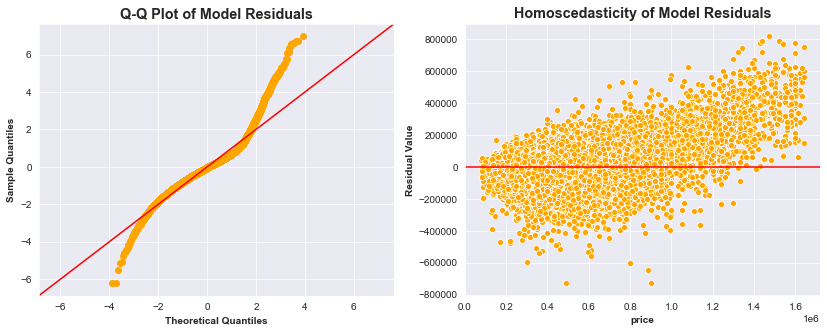

In [113]:
check_ols_assumptions(z_model, data_z, 'price')

> - The model residuals now appear much more homoscedastic than for the initial model before the removal of any outliers. There is a trend that errors tend to increase in the positive direction for more expensive houses, so there is still some heteroscedasticity.
- While the residuals appear much more normally distributed than in the initial model, the assumption of normality still does not appear to have been met.

In [114]:
find_nonsig_features(z_model)

C(zipcode)[T.98002]   0.749
C(zipcode)[T.98003]   0.295
C(zipcode)[T.98019]   0.624
C(zipcode)[T.98023]   0.175
C(zipcode)[T.98030]   0.579
C(zipcode)[T.98031]   0.861
C(zipcode)[T.98032]   0.663
C(zipcode)[T.98042]   0.609
C(zipcode)[T.98055]   0.076
C(zipcode)[T.98058]   0.109
C(zipcode)[T.98092]   0.337
C(zipcode)[T.98168]   0.232
C(zipcode)[T.98178]   0.071
C(zipcode)[T.98188]   0.468
age                   0.830
dtype: float64

> - This is consistent with the results of the first initial model, indicating that age should be dropped as predictor from the model.
- Zipcode appears to be a better predictor in this model than in the models trained on the full dataset (without any outliers removed). Now only 14 of the 70 zipcodes are non-significant, whereas the previous models indicated that 22-23 of the zipcodes were not useful for predicting.

#### Z Model 1.1 - Drop Age

In [115]:
target = 'price'
numerical = ['sqft_living', 'est_sqft_basement', 'lat', 
             'bedrooms', 'floors',]
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

z_model1 = build_model(target, numerical, categorical, data_z)
z_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1020.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:14   Log-Likelihood:            -2.7509e+05
No. Observations:               21016   AIC:                         5.503e+05
Df Residuals:                   20935   BIC:                         5.510e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -8.795e+06   2.21e+06     -3.977      0.000   -1.31e+07   -4.46e+06
C(waterfront)[T.1]   4.275e+05   1.36e+04     31.440      0.000    4.01e+05    4.54e+05
C(condition)[T.2]    5.737e+04   2.41e+04      2.383      0.017    1.02e+04    1.05e+05
C(condition)[T.3]     7.95e+04   2.23e+04      3.570      0.000    3.59e+04    1.23e+05
C(condition)[T.4]    9.704e+04   2.23e+04      4.352      0.000    5.33e+04    1.41e+05
C(condition)[T.5]    1.345e+05   2.24e+04      5.997      0.000    9.06e+04    1.79e+05
C(renovated)[T.1]    4.981e+04   4621.809     10.777      0.000    4.08e+04    5.89e+04
C(zipcode)[T.98002] -3299.0589   1.04e+04     -0.316      0.752   -2.37e+04    1.71e+04
C(zipcode)[T.98003]  9873.3113   9407.009      1.050      0.294   -8565.154    2.83e+04
C(zipcode)[T.98004]   5.96e+05   1.74e+04     34.289      0.000    5.62e+05     6.3e+05
C(zipcode)[T.98005]  3.052e+05    1.8e+04     16.987      0.000     2.7e+05     3.4e+05
C(zipcode)[T.98006]  2.874e+05   1.43e+04     20.055      0.000    2.59e+05    3.16e+05
C(zipcode)[T.98007]  2.301e+05   1.84e+04     12.527      0.000    1.94e+05    2.66e+05
C(zipcode)[T.98008]  2.215e+05   1.71e+04     12.962      0.000    1.88e+05    2.55e+05
C(zipcode)[T.98010]   7.11e+04   1.34e+04      5.311      0.000    4.49e+04    9.73e+04
C(zipcode)[T.98011]  6.366e+04   2.33e+04      2.730      0.006    1.79e+04    1.09e+05
C(zipcode)[T.98014]  4.905e+04    2.1e+04      2.340      0.019    7971.605    9.01e+04
C(zipcode)[T.98019]   1.11e+04   2.26e+04      0.491      0.623   -3.32e+04    5.54e+04
C(zipcode)[T.98022]  4.394e+04   1.09e+04      4.030      0.000    2.26e+04    6.53e+04
C(zipcode)[T.98023] -1.107e+04   8156.742     -1.357      0.175   -2.71e+04    4918.934
C(zipcode)[T.98024]  1.267e+05   1.89e+04      6.714      0.000    8.97e+04    1.64e+05
C(zipcode)[T.98027]   1.69e+05   1.31e+04     12.894      0.000    1.43e+05    1.95e+05
C(zipcode)[T.98028]  6.166e+04   2.28e+04      2.699      0.007    1.69e+04    1.06e+05
C(zipcode)[T.98029]  2.038e+05   1.48e+04     13.741      0.000    1.75e+05    2.33e+05
C(zipcode)[T.98030] -5580.4343      1e+04     -0.556      0.578   -2.53e+04    1.41e+04
C(zipcode)[T.98031] -1839.1268   1.04e+04     -0.176      0.860   -2.23e+04    1.86e+04
C(zipcode)[T.98032] -5443.1190   1.26e+04     -0.431      0.667   -3.02e+04    1.93e+04
C(zipcode)[T.98033]  3.079e+05   1.93e+04     15.930      0.000     2.7e+05    3.46e+05
C(zipcode)[T.98034]  1.321e+05   2.08e+04      6.336      0.000    9.12e+04    1.73e+05
C(zipcode)[T.98038]  2.248e+04   8396.245      2.677      0.007    6023.225    3.89e+04
C(zipcode)[T.98039]  7.949e+05   3.27e+04     24.310      0.000    7.31e+05    8.59e+05
C(zipcode)[T.98040]  4.959e+05   1.53e+04     32.332      0.000    4.66e+05    5.26e+05
C(z

In [116]:
## find variables that negatively impact price
find_coefficients(z_model1)

Intercept             -8795167.875
C(zipcode)[T.98002]      -3299.059
C(zipcode)[T.98023]     -11068.911
C(zipcode)[T.98030]      -5580.434
C(zipcode)[T.98031]      -1839.127
C(zipcode)[T.98032]      -5443.119
C(zipcode)[T.98042]      -4366.004
C(zipcode)[T.98092]      -8522.649
est_sqft_basement          -71.054
bedrooms                -20385.864
floors                  -19426.381
dtype: float64

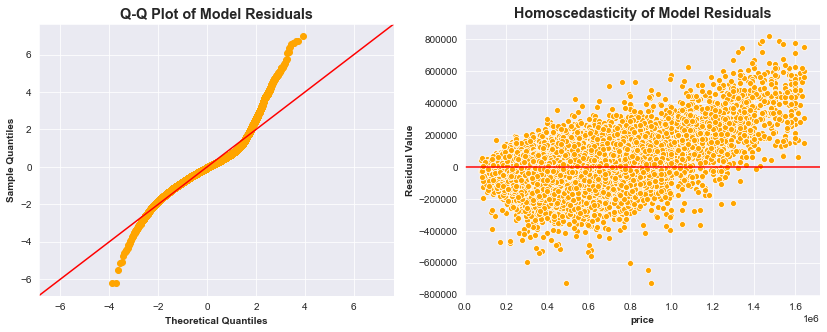

In [117]:
check_ols_assumptions(z_model1, data_z, 'price', fig_filepath=fig_filepath, model_name='Z Model 1-0')

> - These plots do not appear different from the previous model which included the non-significant age feature.
- The model residuals still appear much more homoscedastic than for the initial model before the removal of any outliers. There is a trend that errors tend to increase in the positive direction for more expensive houses, so there is still some heteroscedasticity.
- While the residuals appear much more normally distributed than in the initial model, the assumption of normality still does not appear to have been met.

In [118]:
find_nonsig_features(z_model1)

C(zipcode)[T.98002]   0.752
C(zipcode)[T.98003]   0.294
C(zipcode)[T.98019]   0.623
C(zipcode)[T.98023]   0.175
C(zipcode)[T.98030]   0.578
C(zipcode)[T.98031]   0.860
C(zipcode)[T.98032]   0.667
C(zipcode)[T.98042]   0.604
C(zipcode)[T.98055]   0.074
C(zipcode)[T.98058]   0.109
C(zipcode)[T.98092]   0.334
C(zipcode)[T.98168]   0.224
C(zipcode)[T.98178]   0.067
C(zipcode)[T.98188]   0.463
dtype: float64

### Z Model 2.0 - excludes sqft_living, replaces with sqft_above, sqft_living15, and bathrooms

This model uses the same set of features as initial model 2.0, but it fit to the z-score cleaned data. Compared to the initial model, this model performs better (R-squared increased from 0.787 to 0.808). The residuals are also much more normal and homoscedastic than the equivalent initial model, although they still aren't perfect.

This model also performs slighlty better than the previous model fit to the z-score cleaned data which included sqft_living rather than sqft_above, sqft_living15, and bathrooms (R-squared increased from 0.796 to 0.808). Additionally, age is retained as a significant predictor in this model.

In [119]:
target = 'price'
numerical = ['sqft_above', 'sqft_living15',
             'bathrooms', 'est_sqft_basement',
             'age', 'lat', 
             'bedrooms', 'floors',]
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

z_model2 = build_model(target, numerical, categorical, data_z)
z_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1058.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:16   Log-Likelihood:            -2.7447e+05
No. Observations:               21016   AIC:                         5.491e+05
Df Residuals:                   20932   BIC:                         5.498e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -7.809e+06   2.15e+06     -3.636      0.000    -1.2e+07    -3.6e+06
C(waterfront)[T.1]   4.058e+05   1.32e+04     30.691      0.000     3.8e+05    4.32e+05
C(condition)[T.2]     7.45e+04   2.34e+04      3.186      0.001    2.87e+04     1.2e+05
C(condition)[T.3]    9.371e+04   2.17e+04      4.327      0.000    5.13e+04    1.36e+05
C(condition)[T.4]    1.139e+05   2.17e+04      5.260      0.000    7.15e+04    1.56e+05
C(condition)[T.5]    1.506e+05   2.18e+04      6.909      0.000    1.08e+05    1.93e+05
C(renovated)[T.1]    5.035e+04   4696.786     10.720      0.000    4.11e+04    5.96e+04
C(zipcode)[T.98002]  8464.7979   1.01e+04      0.835      0.404   -1.14e+04    2.83e+04
C(zipcode)[T.98003]  5000.5722   9134.893      0.547      0.584   -1.29e+04    2.29e+04
C(zipcode)[T.98004]  5.698e+05   1.69e+04     33.714      0.000    5.37e+05    6.03e+05
C(zipcode)[T.98005]  2.836e+05   1.75e+04     16.243      0.000    2.49e+05    3.18e+05
C(zipcode)[T.98006]  2.599e+05   1.39e+04     18.644      0.000    2.33e+05    2.87e+05
C(zipcode)[T.98007]  2.222e+05   1.78e+04     12.457      0.000    1.87e+05    2.57e+05
C(zipcode)[T.98008]  2.177e+05   1.66e+04     13.120      0.000    1.85e+05     2.5e+05
C(zipcode)[T.98010]  7.091e+04    1.3e+04      5.455      0.000    4.54e+04    9.64e+04
C(zipcode)[T.98011]  5.555e+04   2.26e+04      2.453      0.014    1.12e+04    9.99e+04
C(zipcode)[T.98014]  6.257e+04   2.04e+04      3.074      0.002    2.27e+04    1.02e+05
C(zipcode)[T.98019]   1.23e+04    2.2e+04      0.560      0.575   -3.07e+04    5.53e+04
C(zipcode)[T.98022]  4.086e+04   1.06e+04      3.860      0.000    2.01e+04    6.16e+04
C(zipcode)[T.98023]  -1.91e+04   7922.052     -2.412      0.016   -3.46e+04   -3576.566
C(zipcode)[T.98024]  1.269e+05   1.83e+04      6.922      0.000     9.1e+04    1.63e+05
C(zipcode)[T.98027]  1.535e+05   1.27e+04     12.061      0.000    1.29e+05    1.78e+05
C(zipcode)[T.98028]   5.97e+04   2.22e+04      2.691      0.007    1.62e+04    1.03e+05
C(zipcode)[T.98029]  1.935e+05   1.44e+04     13.429      0.000    1.65e+05    2.22e+05
C(zipcode)[T.98030] -1.015e+04   9745.142     -1.042      0.297   -2.93e+04    8947.066
C(zipcode)[T.98031] -7888.9479   1.01e+04     -0.778      0.437   -2.78e+04     1.2e+04
C(zipcode)[T.98032]   810.4935   1.23e+04      0.066      0.947   -2.33e+04    2.49e+04
C(zipcode)[T.98033]  3.028e+05   1.88e+04     16.136      0.000    2.66e+05     3.4e+05
C(zipcode)[T.98034]  1.347e+05   2.02e+04      6.654      0.000     9.5e+04    1.74e+05
C(zipcode)[T.98038]  1.211e+04   8159.622      1.484      0.138   -3884.431    2.81e+04
C(zipcode)[T.98039]  7.489e+05   3.18e+04     23.563      0.000    6.87e+05    8.11e+05
C(zipcode)[T.98040]   4.62e+05   1.49e+04     30.959      0.000    4.33e+05    4.91e+05
C(z

In [120]:
## find variables that negatively impact price
find_coefficients(z_model2)

Intercept             -7808875.265
C(zipcode)[T.98023]     -19104.400
C(zipcode)[T.98030]     -10154.167
C(zipcode)[T.98031]      -7888.948
C(zipcode)[T.98042]      -9309.419
C(zipcode)[T.98092]     -17986.144
bedrooms                -19461.959
floors                  -19957.677
dtype: float64

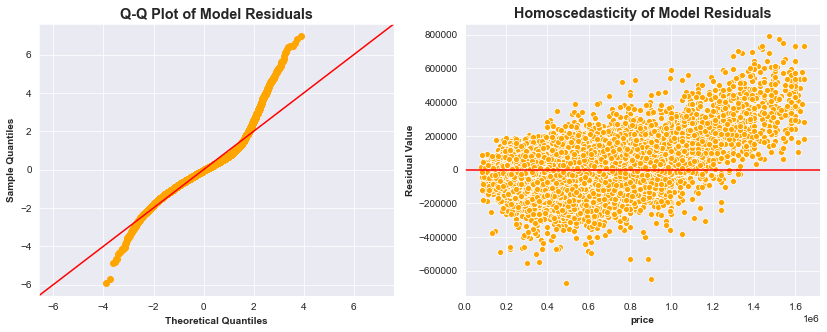

In [121]:
check_ols_assumptions(z_model2, data_z, 'price', fig_filepath=fig_filepath, model_name='Z Model 2-0')

In [122]:
find_nonsig_features(z_model2)

C(zipcode)[T.98002]   0.404
C(zipcode)[T.98003]   0.584
C(zipcode)[T.98019]   0.575
C(zipcode)[T.98030]   0.297
C(zipcode)[T.98031]   0.437
C(zipcode)[T.98032]   0.947
C(zipcode)[T.98038]   0.138
C(zipcode)[T.98042]   0.255
C(zipcode)[T.98055]   0.071
C(zipcode)[T.98058]   0.183
C(zipcode)[T.98188]   0.123
dtype: float64

## IQR Outliers Removed

### IQR Model 1.0 - Retain All Variables from First Initial Model

This is the same model as the first initial model, but fit to the dataset from which IQR outliers have been dropped. Note that, for purposes of direct comparison, the model below has not had any additional variables added in even though some were found to be less highly correlated after outlier removal.

Model performance in terms of R-squared increased slightly compared to that model (increased to 0.794 compared to 0.783 for the same model with outliers retained and 0.786 for the model with z-score outliers removed). The normality and homoscedasticity of model residuals also improved substantially over the initial model. Age should still be dropped from the model.

In [123]:
target = 'price'
numerical = ['sqft_living', 'est_sqft_basement',
             'age', 'lat', 
             'bedrooms', 'floors',]
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

IQR_model = build_model(target, numerical, categorical, data_IQR)
IQR_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     960.2
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:17   Log-Likelihood:            -2.6088e+05
No. Observations:               20268   AIC:                         5.219e+05
Df Residuals:                   20186   BIC:                         5.226e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -9.06e+06   1.81e+06     -5.008      0.000   -1.26e+07   -5.51e+06
C(waterfront)[T.1]   2.698e+05   1.38e+04     19.614      0.000    2.43e+05    2.97e+05
C(condition)[T.2]    6.683e+04   1.97e+04      3.395      0.001    2.82e+04    1.05e+05
C(condition)[T.3]     9.82e+04   1.83e+04      5.374      0.000    6.24e+04    1.34e+05
C(condition)[T.4]    1.153e+05   1.83e+04      6.310      0.000    7.95e+04    1.51e+05
C(condition)[T.5]    1.481e+05   1.84e+04      8.055      0.000    1.12e+05    1.84e+05
C(renovated)[T.1]    4.033e+04   4035.241      9.994      0.000    3.24e+04    4.82e+04
C(zipcode)[T.98002] -1.147e+04   8391.218     -1.367      0.172   -2.79e+04    4975.442
C(zipcode)[T.98003]  1.065e+04   7566.262      1.408      0.159   -4177.371    2.55e+04
C(zipcode)[T.98004]  4.821e+05   1.47e+04     32.687      0.000    4.53e+05    5.11e+05
C(zipcode)[T.98005]  3.058e+05   1.47e+04     20.795      0.000    2.77e+05    3.35e+05
C(zipcode)[T.98006]  2.672e+05   1.18e+04     22.641      0.000    2.44e+05     2.9e+05
C(zipcode)[T.98007]  2.246e+05    1.5e+04     14.998      0.000    1.95e+05    2.54e+05
C(zipcode)[T.98008]  2.077e+05    1.4e+04     14.868      0.000     1.8e+05    2.35e+05
C(zipcode)[T.98010]   8.08e+04   1.08e+04      7.502      0.000    5.97e+04    1.02e+05
C(zipcode)[T.98011]  7.133e+04    1.9e+04      3.751      0.000    3.41e+04    1.09e+05
C(zipcode)[T.98014]  5.001e+04   1.71e+04      2.924      0.003    1.65e+04    8.35e+04
C(zipcode)[T.98019]   1.74e+04   1.84e+04      0.944      0.345   -1.87e+04    5.35e+04
C(zipcode)[T.98022]  4.574e+04   8796.110      5.200      0.000    2.85e+04     6.3e+04
C(zipcode)[T.98023] -8585.5533   6566.120     -1.308      0.191   -2.15e+04    4284.577
C(zipcode)[T.98024]  1.186e+05   1.54e+04      7.680      0.000    8.83e+04    1.49e+05
C(zipcode)[T.98027]  1.729e+05   1.07e+04     16.230      0.000    1.52e+05    1.94e+05
C(zipcode)[T.98028]  6.151e+04   1.86e+04      3.300      0.001     2.5e+04    9.81e+04
C(zipcode)[T.98029]  2.079e+05   1.21e+04     17.217      0.000    1.84e+05    2.32e+05
C(zipcode)[T.98030] -4888.8919   8082.780     -0.605      0.545   -2.07e+04     1.1e+04
C(zipcode)[T.98031] -2654.2065   8424.512     -0.315      0.753   -1.92e+04    1.39e+04
C(zipcode)[T.98032] -1.173e+04   1.02e+04     -1.152      0.249   -3.17e+04    8228.504
C(zipcode)[T.98033]  2.697e+05   1.59e+04     17.001      0.000    2.39e+05    3.01e+05
C(zipcode)[T.98034]  1.193e+05    1.7e+04      7.001      0.000    8.59e+04    1.53e+05
C(zipcode)[T.98038]  2.746e+04   6773.215      4.055      0.000    1.42e+04    4.07e+04
C(zipcode)[T.98039]  6.158e+05   4.43e+04     13.915      0.000    5.29e+05    7.02e+05
C(zipcode)[T.98040]  4.157e+05   1.32e+04     31.603      0.000     3.9e+05    4.42e+05
C(z

In [124]:
## find variables that negatively impact price
find_coefficients(IQR_model)

Intercept             -9060102.077
C(zipcode)[T.98002]     -11472.030
C(zipcode)[T.98023]      -8585.553
C(zipcode)[T.98030]      -4888.892
C(zipcode)[T.98031]      -2654.207
C(zipcode)[T.98032]     -11731.993
C(zipcode)[T.98042]      -1570.740
est_sqft_basement          -64.581
bedrooms                -12714.538
floors                  -15465.629
dtype: float64

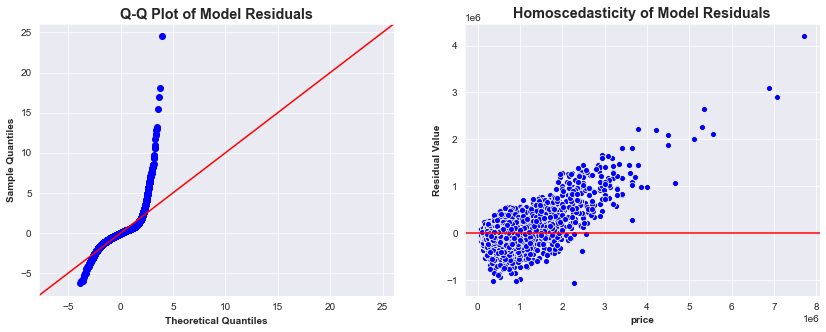

In [125]:
check_ols_assumptions(init_model, data, 'price')

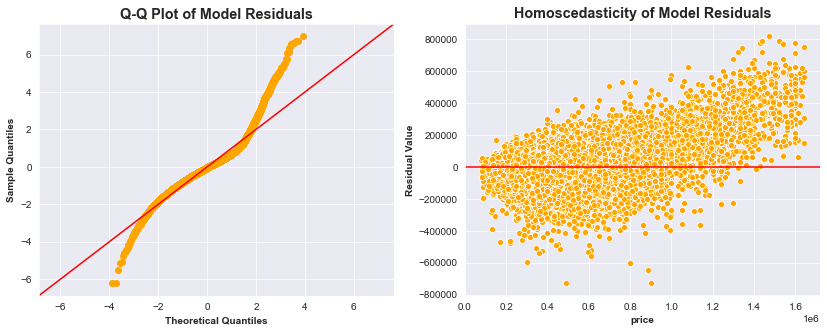

In [126]:
check_ols_assumptions(z_model, data_z, 'price')

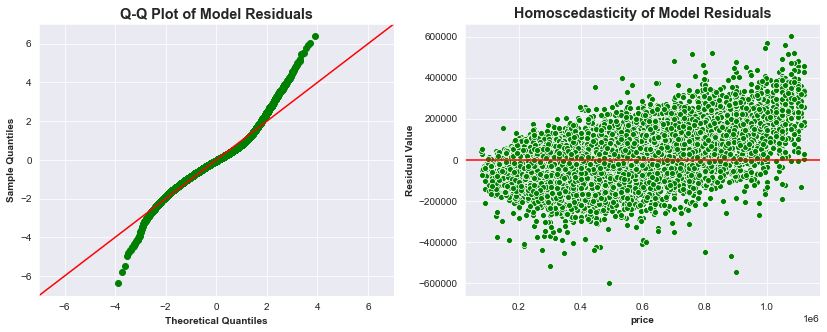

In [127]:
check_ols_assumptions(IQR_model, data_IQR, 'price')

> - The trends seen here are very similar to those observed for the same model fitted to the z-score cleaned data. 
- The model residuals now appear much more homoscedastic than for the initial model before the removal of any outliers. There is a trend that errors tend to increase in the positive direction for more expensive houses, so there is still some heteroscedasticity. However the degree of heteroscedasticity seems lower than that of the z-score model, and the q-q plot seems slightly more normal.
- While the residuals appear much more normally distributed than in the initial model, the assumption of normality still does not appear to have been met. This is not surprising, especially given that multicollinearity is likely to be an issue in this model.

In [128]:
find_nonsig_features(IQR_model)

C(zipcode)[T.98002]   0.172
C(zipcode)[T.98003]   0.159
C(zipcode)[T.98019]   0.345
C(zipcode)[T.98023]   0.191
C(zipcode)[T.98030]   0.545
C(zipcode)[T.98031]   0.753
C(zipcode)[T.98032]   0.249
C(zipcode)[T.98042]   0.817
C(zipcode)[T.98055]   0.070
C(zipcode)[T.98092]   0.918
C(zipcode)[T.98168]   0.790
C(zipcode)[T.98188]   0.641
age                   0.722
dtype: float64

> - This model indicates that age is not a useful predictor.
- A number of the zipcode categories are not useful as predictors, but the majority are, so the overall zipcode category will be retained as a predictor.

#### IQR Model 1.1 - Drop Age

In [129]:
target = 'price'
numerical = ['sqft_living', 'est_sqft_basement', 'lat', 
             'bedrooms', 'floors']
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

IQR_model1 = build_model(target, numerical, categorical, data_IQR)
IQR_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     972.2
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:19   Log-Likelihood:            -2.6088e+05
No. Observations:               20268   AIC:                         5.219e+05
Df Residuals:                   20187   BIC:                         5.226e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -9.055e+06   1.81e+06     -5.005      0.000   -1.26e+07   -5.51e+06
C(waterfront)[T.1]   2.699e+05   1.37e+04     19.636      0.000    2.43e+05    2.97e+05
C(condition)[T.2]    6.667e+04   1.97e+04      3.388      0.001    2.81e+04    1.05e+05
C(condition)[T.3]    9.783e+04   1.82e+04      5.363      0.000    6.21e+04    1.34e+05
C(condition)[T.4]    1.151e+05   1.83e+04      6.302      0.000    7.93e+04    1.51e+05
C(condition)[T.5]     1.48e+05   1.84e+04      8.050      0.000    1.12e+05    1.84e+05
C(renovated)[T.1]     4.07e+04   3899.436     10.437      0.000    3.31e+04    4.83e+04
C(zipcode)[T.98002] -1.141e+04   8389.149     -1.360      0.174   -2.79e+04    5034.656
C(zipcode)[T.98003]  1.067e+04   7565.875      1.411      0.158   -4155.949    2.55e+04
C(zipcode)[T.98004]  4.823e+05   1.47e+04     32.719      0.000    4.53e+05    5.11e+05
C(zipcode)[T.98005]  3.059e+05   1.47e+04     20.806      0.000    2.77e+05    3.35e+05
C(zipcode)[T.98006]  2.672e+05   1.18e+04     22.647      0.000    2.44e+05     2.9e+05
C(zipcode)[T.98007]  2.247e+05    1.5e+04     15.008      0.000    1.95e+05    2.54e+05
C(zipcode)[T.98008]  2.078e+05    1.4e+04     14.879      0.000     1.8e+05    2.35e+05
C(zipcode)[T.98010]  8.078e+04   1.08e+04      7.501      0.000    5.97e+04    1.02e+05
C(zipcode)[T.98011]  7.141e+04    1.9e+04      3.756      0.000    3.41e+04    1.09e+05
C(zipcode)[T.98014]  5.009e+04   1.71e+04      2.929      0.003    1.66e+04    8.36e+04
C(zipcode)[T.98019]  1.743e+04   1.84e+04      0.946      0.344   -1.87e+04    5.35e+04
C(zipcode)[T.98022]  4.575e+04   8795.908      5.201      0.000    2.85e+04     6.3e+04
C(zipcode)[T.98023] -8596.4910   6565.906     -1.309      0.190   -2.15e+04    4273.219
C(zipcode)[T.98024]  1.188e+05   1.54e+04      7.694      0.000    8.85e+04    1.49e+05
C(zipcode)[T.98027]   1.73e+05   1.07e+04     16.235      0.000    1.52e+05    1.94e+05
C(zipcode)[T.98028]  6.162e+04   1.86e+04      3.305      0.001    2.51e+04    9.82e+04
C(zipcode)[T.98029]  2.079e+05   1.21e+04     17.219      0.000    1.84e+05    2.32e+05
C(zipcode)[T.98030] -4905.3049   8082.473     -0.607      0.544   -2.07e+04    1.09e+04
C(zipcode)[T.98031] -2667.4318   8424.247     -0.317      0.752   -1.92e+04    1.38e+04
C(zipcode)[T.98032] -1.163e+04   1.02e+04     -1.143      0.253   -3.16e+04    8318.810
C(zipcode)[T.98033]  2.698e+05   1.59e+04     17.007      0.000    2.39e+05    3.01e+05
C(zipcode)[T.98034]  1.193e+05    1.7e+04      7.006      0.000    8.59e+04    1.53e+05
C(zipcode)[T.98038]   2.74e+04   6770.567      4.047      0.000    1.41e+04    4.07e+04
C(zipcode)[T.98039]  6.159e+05   4.42e+04     13.919      0.000    5.29e+05    7.03e+05
C(zipcode)[T.98040]  4.159e+05   1.32e+04     31.620      0.000     3.9e+05    4.42e+05
C(z

In [130]:
## find variables that negatively impact price
find_coefficients(IQR_model1)

Intercept             -9054633.452
C(zipcode)[T.98002]     -11408.760
C(zipcode)[T.98023]      -8596.491
C(zipcode)[T.98030]      -4905.305
C(zipcode)[T.98031]      -2667.432
C(zipcode)[T.98032]     -11633.931
C(zipcode)[T.98042]      -1644.228
est_sqft_basement          -64.675
bedrooms                -12694.446
floors                  -15779.077
dtype: float64

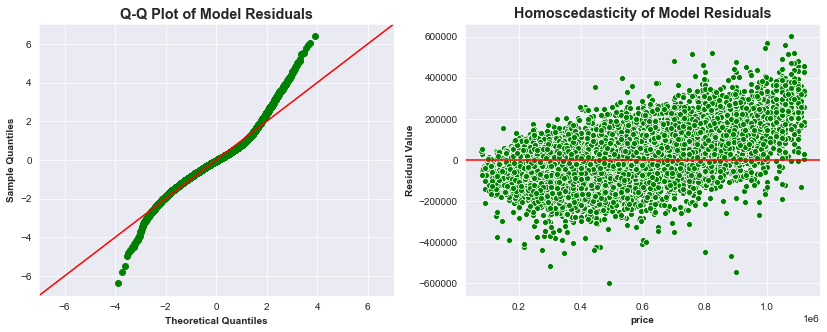

In [131]:
check_ols_assumptions(IQR_model1, data_IQR, 'price', fig_filepath=fig_filepath, model_name='IQR Model 1-0')

> - The residuals are now much more normally distributed.
- There is still some heteroscedasticity of the residuals, but this is a definite improvement over the initial models before outliers were removed.

In [132]:
find_nonsig_features(IQR_model1)

C(zipcode)[T.98002]   0.174
C(zipcode)[T.98003]   0.158
C(zipcode)[T.98019]   0.344
C(zipcode)[T.98023]   0.190
C(zipcode)[T.98030]   0.544
C(zipcode)[T.98031]   0.752
C(zipcode)[T.98032]   0.253
C(zipcode)[T.98042]   0.808
C(zipcode)[T.98055]   0.067
C(zipcode)[T.98092]   0.924
C(zipcode)[T.98168]   0.768
C(zipcode)[T.98188]   0.631
dtype: float64

### IQR Model 2.0 - exclude sqft_living, replaces with sqft_above, sqft_living15, and bathrooms

This model uses the same set of features as initial model 2.0, but it fit to the IQR cleaned data. Compared to the initial model, this model performs better (R-squared increased from 0.787 to 0.808). The residuals are also much more normal and homoscedastic than the equivalent initial model, although they still aren't perfect.

This model also performs slighlty better than the previous model fit to the IQR cleaned data which included sqft_living rather than sqft_above, sqft_living15, and bathrooms (R-squared increased from 0.794 to 0.808). Additionally, age is retained as a significant predictor in this model.

In [133]:
target = 'price'
numerical = ['sqft_above', 'sqft_living15', 'est_sqft_basement',
             'age', 'lat', 'bedrooms', 'floors', 'bathrooms', 'waterfront', 'renovated']
categorical = ['condition', 'zipcode']

IQR_model2 = build_model(target, numerical, categorical, data_IQR)
IQR_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1020.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:20   Log-Likelihood:            -2.6019e+05
No. Observations:               20268   AIC:                         5.206e+05
Df Residuals:                   20184   BIC:                         5.212e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -8.188e+06   1.75e+06     -4.682      0.000   -1.16e+07   -4.76e+06
C(condition)[T.2]    8.278e+04    1.9e+04      4.350      0.000    4.55e+04     1.2e+05
C(condition)[T.3]    1.118e+05   1.77e+04      6.328      0.000    7.72e+04    1.46e+05
C(condition)[T.4]    1.315e+05   1.77e+04      7.444      0.000    9.69e+04    1.66e+05
C(condition)[T.5]     1.64e+05   1.78e+04      9.225      0.000    1.29e+05    1.99e+05
C(zipcode)[T.98002]  -711.6894   8118.045     -0.088      0.930   -1.66e+04    1.52e+04
C(zipcode)[T.98003]  6410.2594   7314.598      0.876      0.381   -7926.950    2.07e+04
C(zipcode)[T.98004]  4.585e+05   1.43e+04     32.134      0.000    4.31e+05    4.86e+05
C(zipcode)[T.98005]  2.859e+05   1.42e+04     20.105      0.000    2.58e+05    3.14e+05
C(zipcode)[T.98006]  2.461e+05   1.14e+04     21.545      0.000    2.24e+05    2.68e+05
C(zipcode)[T.98007]  2.181e+05   1.45e+04     15.068      0.000     1.9e+05    2.46e+05
C(zipcode)[T.98008]  2.042e+05   1.35e+04     15.123      0.000    1.78e+05    2.31e+05
C(zipcode)[T.98010]  8.027e+04   1.04e+04      7.711      0.000    5.99e+04    1.01e+05
C(zipcode)[T.98011]  6.388e+04   1.84e+04      3.476      0.001    2.79e+04    9.99e+04
C(zipcode)[T.98014]  6.105e+04   1.65e+04      3.693      0.000    2.87e+04    9.35e+04
C(zipcode)[T.98019]  1.848e+04   1.78e+04      1.038      0.299   -1.64e+04    5.34e+04
C(zipcode)[T.98022]  4.297e+04   8501.956      5.054      0.000    2.63e+04    5.96e+04
C(zipcode)[T.98023] -1.602e+04   6349.248     -2.523      0.012   -2.85e+04   -3573.211
C(zipcode)[T.98024]  1.212e+05   1.49e+04      8.118      0.000    9.19e+04     1.5e+05
C(zipcode)[T.98027]  1.594e+05   1.03e+04     15.468      0.000    1.39e+05     1.8e+05
C(zipcode)[T.98028]  5.949e+04    1.8e+04      3.301      0.001    2.42e+04    9.48e+04
C(zipcode)[T.98029]  1.986e+05   1.17e+04     17.008      0.000    1.76e+05    2.21e+05
C(zipcode)[T.98030] -8797.3360   7813.392     -1.126      0.260   -2.41e+04    6517.550
C(zipcode)[T.98031] -7936.9766   8144.476     -0.975      0.330   -2.39e+04    8026.860
C(zipcode)[T.98032] -6566.6150   9843.913     -0.667      0.505   -2.59e+04    1.27e+04
C(zipcode)[T.98033]  2.645e+05   1.53e+04     17.248      0.000    2.34e+05    2.95e+05
C(zipcode)[T.98034]  1.216e+05   1.65e+04      7.382      0.000    8.93e+04    1.54e+05
C(zipcode)[T.98038]  1.833e+04   6551.042      2.798      0.005    5489.990    3.12e+04
C(zipcode)[T.98039]  5.885e+05   4.28e+04     13.757      0.000    5.05e+05    6.72e+05
C(zipcode)[T.98040]  3.836e+05   1.27e+04     30.104      0.000    3.59e+05    4.09e+05
C(zipcode)[T.98042] -6010.1365   6557.894     -0.916      0.359   -1.89e+04    6843.871
C(zipcode)[T.98045]  9.717e+04   9928.810      9.787      0.000    7.77e+04    1.17e+05
C(z

In [134]:
## find variables that negatively impact price
find_coefficients(IQR_model2)

Intercept             -8187655.423
C(zipcode)[T.98002]       -711.689
C(zipcode)[T.98023]     -16018.254
C(zipcode)[T.98030]      -8797.336
C(zipcode)[T.98031]      -7936.977
C(zipcode)[T.98032]      -6566.615
C(zipcode)[T.98042]      -6010.136
C(zipcode)[T.98092]      -7786.041
bedrooms                -11556.516
floors                  -15188.088
dtype: float64

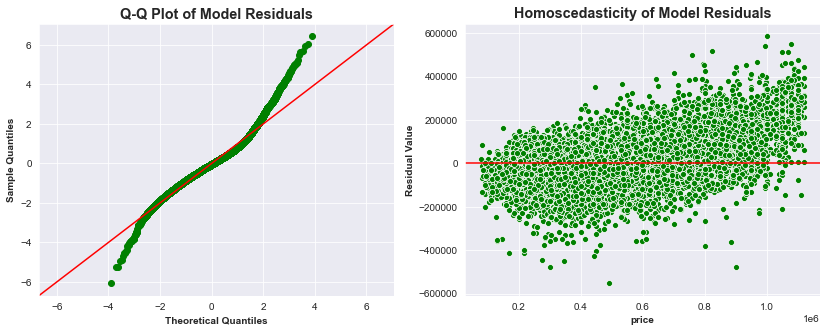

In [135]:
check_ols_assumptions(IQR_model2, data_IQR, 'price', fig_filepath=fig_filepath, model_name='IQR Model 2-0')

In [136]:
find_nonsig_features(IQR_model2)

C(zipcode)[T.98002]   0.930
C(zipcode)[T.98003]   0.381
C(zipcode)[T.98019]   0.299
C(zipcode)[T.98030]   0.260
C(zipcode)[T.98031]   0.330
C(zipcode)[T.98032]   0.505
C(zipcode)[T.98042]   0.359
C(zipcode)[T.98055]   0.064
C(zipcode)[T.98092]   0.257
C(zipcode)[T.98168]   0.122
C(zipcode)[T.98188]   0.173
dtype: float64

## ANSWER: QUESTION 3

Model performance improved (R-squared increased) when outliers were removed for both versions of the initial model that were tested (Model 1.0 and 2.0). Model performance was virtually equivalent between the two methods of outlier removal.

| Model 1.0 | Full Dataset | Z-Score | IQR |
| :-: | :-: | :-: | :-: |
| R-squared | 0.783 | 0.796 | 0.794  |

| Model 2.0 | Full Dataset | Z-Score | IQR |
| :-: | :-: | :-: | :-: |
| R-squared | 0.787 | 0.808 | 0.808  |

Outlier removal also greatly improved the normality and homoscedasticity of the model residuals for both versions of the initial model. Removing outliers based on the harsher IQR method improved the normality and homoscedasticity of the model more than the z-score method. 

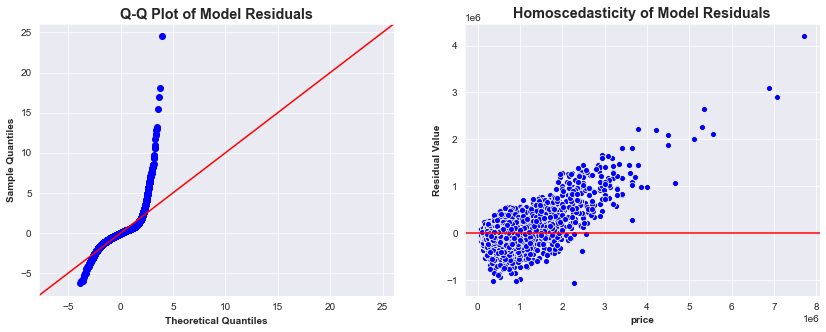

None

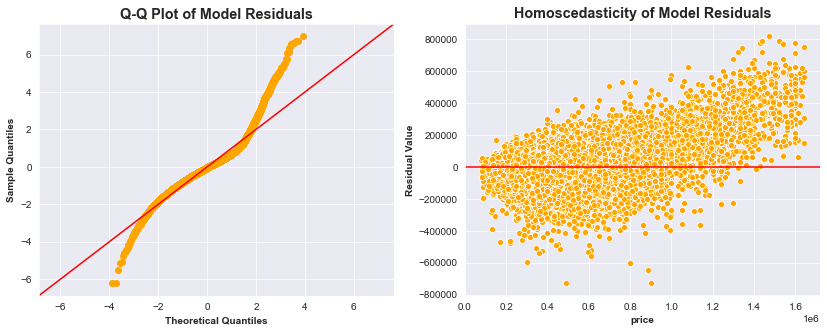

None

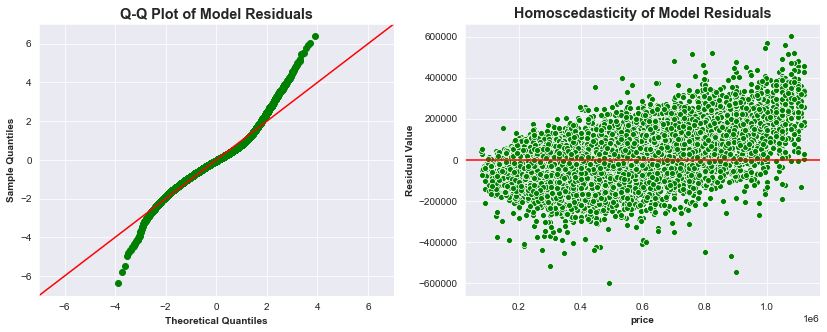

None

In [137]:
## display residual q-q and homoscedasticity plots for Model 1.0 
display(check_ols_assumptions(init_model, data, 'price'))
display(check_ols_assumptions(z_model, data_z, 'price'))
display(check_ols_assumptions(IQR_model, data_IQR, 'price'))

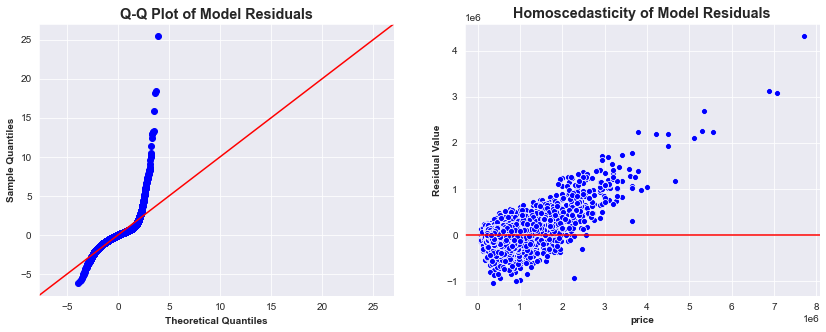

None

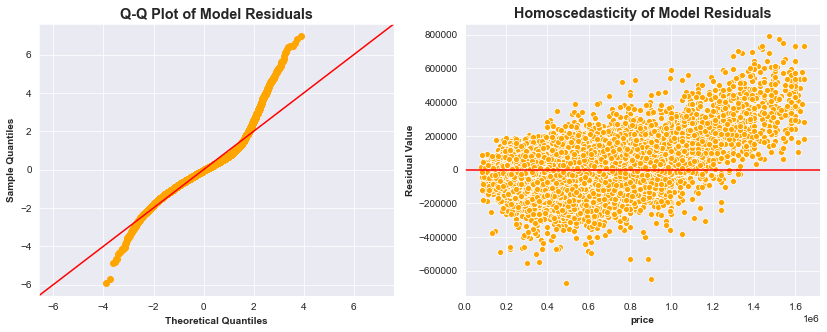

None

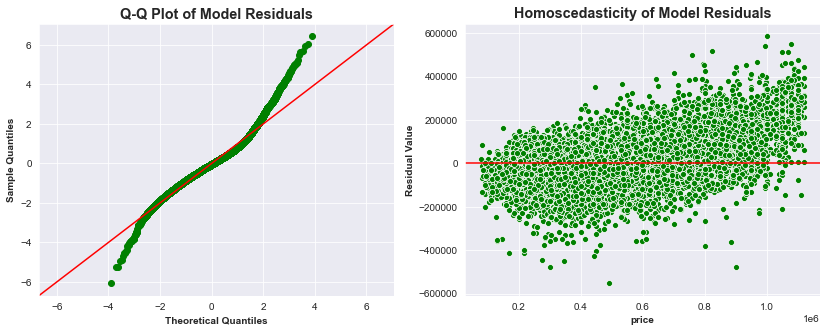

None

In [138]:
## display residual q-q and homoscedasticity plots for Model 2.0 
display(check_ols_assumptions(init_model2, data, 'price'))
display(check_ols_assumptions(z_model2, data_z, 'price'))
display(check_ols_assumptions(IQR_model2, data_IQR, 'price'))

## FINAL MODEL

Because I am aiming to make the best predictions of price for houses that a representative of the majority of houses in the county and because IQR outlier removal made the most dramatic improvements on residual normality and homoscedasticity, I will focus on tuning the best predictive model to the IQR cleaned data. 

First, I reintroduce predictors that were originally excluded due to high correlations. Several of the correlations dropped below the threshold of 0.75 when outliers were removed. Based on that threshold, only sqft_living and sqft_above should not be included together. I will include sqft_living since it is more highly correlated with price.

My next step will be to address multicollinearity in the model, and then investigate how model performance may be further improved through transformations. Predictors will be removed from the model if they have variance inflation factors of 6 or greater.

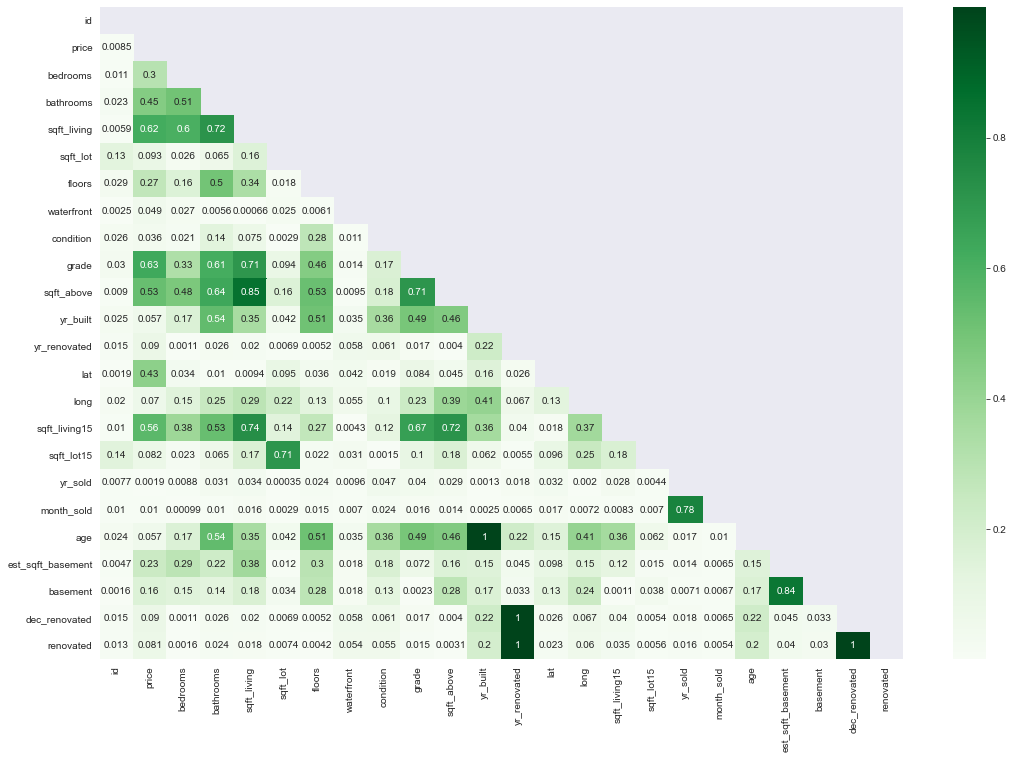

In [139]:
## check correlations among variables in IQR cleaned data
corr = data_IQR.corr().abs()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True, cmap='Greens', mask=mask);

In [140]:
target = 'price'
numerical = ['sqft_living', 'est_sqft_basement',
             'age', 'lat', 'grade', 'sqft_living15',
             'bedrooms', 'floors', 'bathrooms']
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

final_model = build_model(target, numerical, categorical, data_IQR)
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     1123.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:26   Log-Likelihood:            -2.5930e+05
No. Observations:               20268   AIC:                         5.188e+05
Df Residuals:                   20183   BIC:                         5.194e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -6.822e+06   1.67e+06     -4.076      0.000   -1.01e+07   -3.54e+06
C(waterfront)[T.1]   2.551e+05   1.27e+04     20.048      0.000     2.3e+05     2.8e+05
C(condition)[T.2]    5.579e+04   1.82e+04      3.061      0.002    2.01e+04    9.15e+04
C(condition)[T.3]    7.412e+04   1.69e+04      4.379      0.000    4.09e+04    1.07e+05
C(condition)[T.4]    9.353e+04   1.69e+04      5.524      0.000    6.03e+04    1.27e+05
C(condition)[T.5]    1.261e+05    1.7e+04      7.403      0.000    9.27e+04     1.6e+05
C(renovated)[T.1]    3.522e+04   3773.309      9.333      0.000    2.78e+04    4.26e+04
C(zipcode)[T.98002]  6600.3601   7770.434      0.849      0.396   -8630.324    2.18e+04
C(zipcode)[T.98003] -6244.8415   7005.877     -0.891      0.373      -2e+04    7487.248
C(zipcode)[T.98004]  4.521e+05   1.37e+04     33.104      0.000    4.25e+05    4.79e+05
C(zipcode)[T.98005]   2.71e+05   1.36e+04     19.906      0.000    2.44e+05    2.98e+05
C(zipcode)[T.98006]  2.298e+05   1.09e+04     21.017      0.000    2.08e+05    2.51e+05
C(zipcode)[T.98007]  2.051e+05   1.39e+04     14.804      0.000    1.78e+05    2.32e+05
C(zipcode)[T.98008]  1.978e+05   1.29e+04     15.311      0.000    1.72e+05    2.23e+05
C(zipcode)[T.98010]  8.846e+04   9963.785      8.878      0.000    6.89e+04    1.08e+05
C(zipcode)[T.98011]  7.451e+04   1.76e+04      4.236      0.000       4e+04    1.09e+05
C(zipcode)[T.98014]  8.003e+04   1.58e+04      5.057      0.000     4.9e+04    1.11e+05
C(zipcode)[T.98019]  4.322e+04   1.71e+04      2.535      0.011    9797.752    7.67e+04
C(zipcode)[T.98022]  4.044e+04   8136.178      4.971      0.000    2.45e+04    5.64e+04
C(zipcode)[T.98023] -2.678e+04   6081.059     -4.405      0.000   -3.87e+04   -1.49e+04
C(zipcode)[T.98024]  1.329e+05   1.43e+04      9.303      0.000    1.05e+05    1.61e+05
C(zipcode)[T.98027]  1.563e+05   9860.209     15.855      0.000    1.37e+05    1.76e+05
C(zipcode)[T.98028]  6.831e+04   1.72e+04      3.961      0.000    3.45e+04    1.02e+05
C(zipcode)[T.98029]  1.869e+05   1.12e+04     16.725      0.000    1.65e+05    2.09e+05
C(zipcode)[T.98030] -6678.9830   7477.205     -0.893      0.372   -2.13e+04    7976.949
C(zipcode)[T.98031] -6512.8169   7793.945     -0.836      0.403   -2.18e+04    8763.951
C(zipcode)[T.98032] -1.552e+04   9422.443     -1.647      0.100    -3.4e+04    2953.706
C(zipcode)[T.98033]   2.65e+05   1.47e+04     18.060      0.000    2.36e+05    2.94e+05
C(zipcode)[T.98034]  1.268e+05   1.58e+04      8.044      0.000    9.59e+04    1.58e+05
C(zipcode)[T.98038]    2.9e+04   6273.920      4.622      0.000    1.67e+04    4.13e+04
C(zipcode)[T.98039]  5.776e+05   4.09e+04     14.109      0.000    4.97e+05    6.58e+05
C(zipcode)[T.98040]  3.667e+05   1.22e+04     30.057      0.000    3.43e+05    3.91e+05
C(z

In [141]:
## find variables that negatively impact price
find_coefficients(final_model)

Intercept             -6821810.173
C(zipcode)[T.98003]      -6244.842
C(zipcode)[T.98023]     -26784.044
C(zipcode)[T.98030]      -6678.983
C(zipcode)[T.98031]      -6512.817
C(zipcode)[T.98032]     -15515.051
C(zipcode)[T.98042]      -1725.074
C(zipcode)[T.98092]     -13770.671
est_sqft_basement          -38.683
bedrooms                 -6872.751
floors                  -16156.134
dtype: float64

**Most of the predictors are associated with increasing home price, but a few of the predictors appear to have a negative impact on price:**

**Negative**
- **Zipcode**: The zipcodes 98023 and 98092 are significant predictors associated with decreased home prices (98003, 98030, 98031, 98032, and 98042 have negative coefficients as well, but they are non-significant predictors).
- **Est_sqft_basement**: The area of the basement in square feet is actually associated with a very slight (\\$38.68 per square foot) decrease in home price.
- **Bedrooms**: Increasing the number of bedrooms by 1 is associated with a \\$6,872.75 decrease in price.
- **Floors**: Increasing the number of floors by 1 is associated with a \\$16,156.13 drop in price.

**Positive**
- **Waterfront**: Waterfront homes sell for more than properties off the water (roughly \\$255,100 difference).
- **Renovated**: Homes that were renovated at some point tend to command higher prices (roughly \\$35,220 difference).
- **Condition**: Homes that are in better condition tend to sell for more money.
- **Zipcode**: Homes in most of the zipcodes sell for more money than the reference zipcode 98001.
- **Sqft_living**: An increase in living area of 1 square foot increases selling price by \\$113.
- **Age**: Older homes tend to sell for slightly more money (one year older increases home price by \\$630).
- **Lat**: Homes at higher latitudes (further north) tend to sell for substantially more money (an increase of 1 degree of latitude is associated with a \\$135,200 increase in price).
- **Grade**: Homes with higher grades also sell for significantly more money (increasing grade by 1 is associated with a \\$45,410 increase in home price).
- **Sqft_living15**: Home price also increases with the average square footage of living area in neighboring homes. The increase is not as great as increasing the square footage of the house itself, but for every 1 square foot increase in the average area of the 15 closest homes, price increases by \\$44.73. 
- **Bathrooms**: Increasing the number of bathrooms by 1 is associated with a \\$14,760 increase in price.

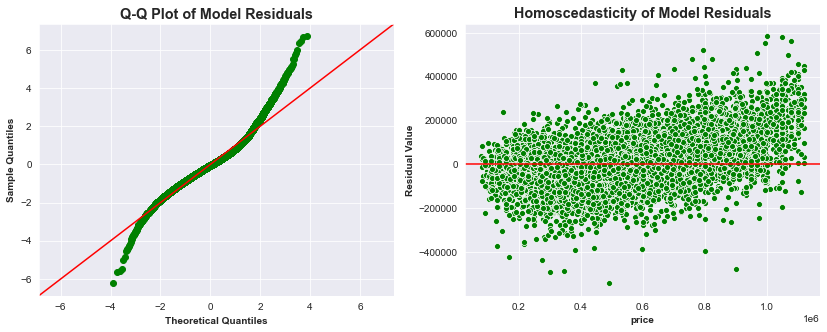

In [142]:
check_ols_assumptions(final_model, data_IQR, 'price', fig_filepath=fig_filepath, model_name='Final Model')

In [143]:
find_nonsig_features(final_model)

C(zipcode)[T.98002]   0.396
C(zipcode)[T.98003]   0.373
C(zipcode)[T.98030]   0.372
C(zipcode)[T.98031]   0.403
C(zipcode)[T.98032]   0.100
C(zipcode)[T.98042]   0.783
C(zipcode)[T.98058]   0.083
C(zipcode)[T.98188]   0.163
dtype: float64

> - All the predictors included in the model are significant (only 8 of the 70 zipcodes are non-significant, so the overall zipcode predictor can be retained).
- The residuals appear to be relatively homoscedastic, and the model residuals do not deviate terribly from a normal distribution.

This final model performs better than all previous models, with an R-squared of 0.824 (the next highest R-squared was 0.808). The addition of predictors that were removed from initial models due to high correlations in the full dataset led to this increase in performance. 

For predictors that were included in initial models, their respective model parameters showed trends similar to those in the previous models. In other words, variables that were consistently associated with increased (or decreased) home prices in earlier models were still associated with increased (or decreased) home prices in this final model. 

All the included features are significant predictors of price, except for 8 zipcodes out of the total 70. Since the vast majority of zipcodes are useful for predicting home price (some are associated with higher prices and some with decreased prices), this variable is kept in the model.

### Checking Multicollinearity

In [144]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [145]:
data_IQR.head()

id        date      price  bedrooms  bathrooms  ...  basement  dec_renovated  dec_reno_cat_unk  dec_reno_cat_fill0  renovated
0  7129300520  10/13/2014 221900.000         3      1.000  ...         0          0.000             0.000               0.000          0
1  6414100192   12/9/2014 538000.000         3      2.250  ...         1       1990.000          1990.000            1990.000          1
2  5631500400   2/25/2015 180000.000         2      1.000  ...         0            nan           Unknown               0.000          0
3  2487200875   12/9/2014 604000.000         4      3.000  ...         1          0.000             0.000               0.000          0
4  1954400510   2/18/2015 510000.000         3      2.000  ...         0          0.000             0.000               0.000          0

[5 rows x 30 columns]

In [146]:
## change zipcode to numeric so it can be included in VIF analysis
data_IQR['zipcode'] = data_IQR['zipcode'].astype('int64')

## slice out a df that contains only the predictors used in IQR Model 4
predictors = ['sqft_living', 'est_sqft_basement',
             'age', 'lat', 'grade', 'sqft_living15',
             'bedrooms', 'floors', 'bathrooms', 'waterfront', 
             'condition', 'renovated', 'zipcode']
X = data_IQR[predictors]
X = sm.add_constant(X)

## check the VIFs for each predictor
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_results = pd.Series(dict(zip(X.columns, vif)))

vif_results

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


const               4320487.047
sqft_living               5.138
est_sqft_basement         1.814
age                       2.322
lat                       1.161
grade                     2.769
sqft_living15             2.701
bedrooms                  1.700
floors                    2.041
bathrooms                 3.031
waterfront                1.011
condition                 1.237
renovated                 1.105
zipcode                   1.334
dtype: float64

Even though variables which were originally excluded from the inital model due to high correlation are included in the current model, none of the variables introduce extreme multicollinearity (VIF >= 6). All predictors will be kept in the final model.

In [147]:
## change zipcode back to string
data_IQR['zipcode'] = data_IQR['zipcode'].astype(str)

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Checking Transformations

In [148]:
data_IQR['log_price'] = np.log(data_IQR['price'])
target = 'log_price'
numerical = ['sqft_living', 'est_sqft_basement',
             'age', 'lat', 'grade', 'sqft_living15',
             'bedrooms', 'floors', 'bathrooms']
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

final_model_log_price = build_model(target, numerical, categorical, data_IQR)
final_model_log_price.summary()

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     1197.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:27   Log-Likelihood:                 5910.8
No. Observations:               20268   AIC:                        -1.165e+04
Df Residuals:                   20183   BIC:                        -1.098e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -13.3192      3.474     -3.833      0.000     -20.129      -6.509
C(waterfront)[T.1]      0.5249      0.026     19.871      0.000       0.473       0.577
C(condition)[T.2]       0.1559      0.038      4.121      0.000       0.082       0.230
C(condition)[T.3]       0.2840      0.035      8.084      0.000       0.215       0.353
C(condition)[T.4]       0.3302      0.035      9.394      0.000       0.261       0.399
C(condition)[T.5]       0.3856      0.035     10.905      0.000       0.316       0.455
C(renovated)[T.1]       0.0637      0.008      8.139      0.000       0.048       0.079
C(zipcode)[T.98002]    -0.0452      0.016     -2.802      0.005      -0.077      -0.014
C(zipcode)[T.98003]     0.0068      0.015      0.467      0.641      -0.022       0.035
C(zipcode)[T.98004]     0.8494      0.028     29.966      0.000       0.794       0.905
C(zipcode)[T.98005]     0.5415      0.028     19.162      0.000       0.486       0.597
C(zipcode)[T.98006]     0.4785      0.023     21.079      0.000       0.434       0.523
C(zipcode)[T.98007]     0.4660      0.029     16.204      0.000       0.410       0.522
C(zipcode)[T.98008]     0.4720      0.027     17.599      0.000       0.419       0.525
C(zipcode)[T.98010]     0.2462      0.021     11.904      0.000       0.206       0.287
C(zipcode)[T.98011]     0.1980      0.037      5.424      0.000       0.126       0.270
C(zipcode)[T.98014]     0.1581      0.033      4.814      0.000       0.094       0.223
C(zipcode)[T.98019]     0.1113      0.035      3.143      0.002       0.042       0.181
C(zipcode)[T.98022]     0.1495      0.017      8.852      0.000       0.116       0.183
C(zipcode)[T.98023]    -0.0430      0.013     -3.408      0.001      -0.068      -0.018
C(zipcode)[T.98024]     0.3244      0.030     10.941      0.000       0.266       0.383
C(zipcode)[T.98027]     0.3838      0.020     18.753      0.000       0.344       0.424
C(zipcode)[T.98028]     0.1726      0.036      4.821      0.000       0.102       0.243
C(zipcode)[T.98029]     0.4478      0.023     19.301      0.000       0.402       0.493
C(zipcode)[T.98030]     0.0149      0.016      0.960      0.337      -0.016       0.045
C(zipcode)[T.98031]     0.0093      0.016      0.572      0.567      -0.022       0.041
C(zipcode)[T.98032]    -0.0736      0.020     -3.764      0.000      -0.112      -0.035
C(zipcode)[T.98033]     0.5418      0.030     17.785      0.000       0.482       0.601
C(zipcode)[T.98034]     0.2987      0.033      9.132      0.000       0.235       0.363
C(zipcode)[T.98038]     0.1312      0.013     10.075      0.000       0.106       0.157
C(zipcode)[T.98039]     1.0478      0.085     12.331      0.000       0.881       1.214
C(zipcode)[T.98040]     0.6793      0.025     26.822      0.000       0.630       0.729
C(z

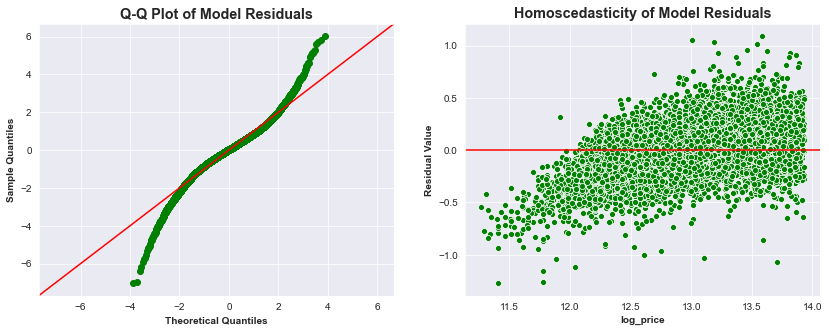

In [149]:
check_ols_assumptions(final_model_log_price, data_IQR, 'log_price')

In [150]:
find_nonsig_features(final_model_log_price)

C(zipcode)[T.98003]   0.641
C(zipcode)[T.98030]   0.337
C(zipcode)[T.98031]   0.567
C(zipcode)[T.98042]   0.090
C(zipcode)[T.98188]   0.680
bedrooms              0.125
dtype: float64

> - Log transforming the target variable marginally improved the R-squared of the model from 0.824 to 0.833.
- Log transforming price did not improve the normality of model residuals and actually increased the degree of heteroscedasticity.
- Bedrooms is no longer a significant predictor in this model.

In [151]:
data_IQR['log_sqft_living'] = np.log(data_IQR['sqft_living'])
data_IQR['log_sqft_living15'] = np.log(data_IQR['sqft_living15'])

target = 'price'
numerical = ['log_sqft_living', 'est_sqft_basement',
             'age', 'lat', 'grade', 'log_sqft_living15',
             'bedrooms', 'floors', 'bathrooms']
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

final_model_log_preds = build_model(target, numerical, categorical, data_IQR)
final_model_log_preds.summary()

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1036.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:34:28   Log-Likelihood:            -2.5997e+05
No. Observations:               20268   AIC:                         5.201e+05
Df Residuals:                   20183   BIC:                         5.208e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -7.692e+06   1.73e+06     -4.446      0.000   -1.11e+07    -4.3e+06
C(waterfront)[T.1]   2.546e+05   1.32e+04     19.353      0.000    2.29e+05     2.8e+05
C(condition)[T.2]    4.461e+04   1.88e+04      2.368      0.018    7686.169    8.15e+04
C(condition)[T.3]    5.389e+04   1.75e+04      3.080      0.002    1.96e+04    8.82e+04
C(condition)[T.4]    6.982e+04   1.75e+04      3.989      0.000    3.55e+04    1.04e+05
C(condition)[T.5]    1.016e+05   1.76e+04      5.767      0.000     6.7e+04    1.36e+05
C(renovated)[T.1]    3.025e+04   3899.673      7.758      0.000    2.26e+04    3.79e+04
C(zipcode)[T.98002]  1.421e+04   8037.297      1.768      0.077   -1542.047       3e+04
C(zipcode)[T.98003] -7673.8063   7242.136     -1.060      0.289   -2.19e+04    6521.371
C(zipcode)[T.98004]  4.519e+05   1.41e+04     32.013      0.000    4.24e+05     4.8e+05
C(zipcode)[T.98005]  2.798e+05   1.41e+04     19.884      0.000    2.52e+05    3.07e+05
C(zipcode)[T.98006]  2.397e+05   1.13e+04     21.207      0.000    2.18e+05    2.62e+05
C(zipcode)[T.98007]  2.076e+05   1.43e+04     14.490      0.000    1.79e+05    2.36e+05
C(zipcode)[T.98008]  1.992e+05   1.34e+04     14.915      0.000    1.73e+05    2.25e+05
C(zipcode)[T.98010]  1.032e+05   1.03e+04     10.022      0.000     8.3e+04    1.23e+05
C(zipcode)[T.98011]  8.362e+04   1.82e+04      4.599      0.000     4.8e+04    1.19e+05
C(zipcode)[T.98014]  1.002e+05   1.64e+04      6.127      0.000    6.81e+04    1.32e+05
C(zipcode)[T.98019]  5.548e+04   1.76e+04      3.148      0.002    2.09e+04       9e+04
C(zipcode)[T.98022]  4.246e+04   8410.190      5.048      0.000     2.6e+04    5.89e+04
C(zipcode)[T.98023] -2.682e+04   6285.691     -4.268      0.000   -3.91e+04   -1.45e+04
C(zipcode)[T.98024]  1.508e+05   1.48e+04     10.217      0.000    1.22e+05     1.8e+05
C(zipcode)[T.98027]  1.671e+05   1.02e+04     16.397      0.000    1.47e+05    1.87e+05
C(zipcode)[T.98028]  7.513e+04   1.78e+04      4.215      0.000    4.02e+04     1.1e+05
C(zipcode)[T.98029]  1.869e+05   1.16e+04     16.177      0.000    1.64e+05     2.1e+05
C(zipcode)[T.98030] -9470.4396   7729.282     -1.225      0.220   -2.46e+04    5679.584
C(zipcode)[T.98031] -8543.8506   8056.694     -1.060      0.289   -2.43e+04    7247.926
C(zipcode)[T.98032] -1.137e+04   9742.431     -1.167      0.243   -3.05e+04    7728.532
C(zipcode)[T.98033]  2.727e+05   1.52e+04     17.974      0.000    2.43e+05    3.02e+05
C(zipcode)[T.98034]  1.334e+05   1.63e+04      8.187      0.000    1.01e+05    1.65e+05
C(zipcode)[T.98038]  3.143e+04   6484.812      4.846      0.000    1.87e+04    4.41e+04
C(zipcode)[T.98039]  5.738e+05   4.23e+04     13.559      0.000    4.91e+05    6.57e+05
C(zipcode)[T.98040]  3.739e+05   1.26e+04     29.656      0.000    3.49e+05    3.99e+05
C(z

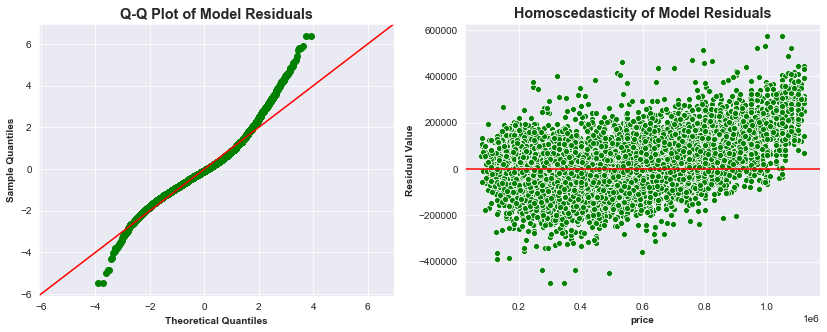

In [152]:
check_ols_assumptions(final_model_log_preds, data_IQR, 'price')

In [153]:
find_nonsig_features(final_model_log_preds)

C(zipcode)[T.98002]   0.077
C(zipcode)[T.98003]   0.289
C(zipcode)[T.98030]   0.220
C(zipcode)[T.98031]   0.289
C(zipcode)[T.98032]   0.243
C(zipcode)[T.98042]   0.491
C(zipcode)[T.98058]   0.054
C(zipcode)[T.98092]   0.057
dtype: float64

> - The normality of model residuals were not improved by log transforming 2 of the most non-normally distributed predictors (sqft_living and sqft_living15).
- Model performance was slightly reduced in that R-squared dropped from 0.824 to 0.812.

### Final Model Validation

In [154]:
## Import model validation functions
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [155]:
## Create a training and test set
data_train, data_test = train_test_split(data, test_size=0.25, 
                                         shuffle=True,
                                         random_state=321)
data_train.shape, data_test.shape

((16065, 30), (5355, 30))

In [156]:
## Train Model using only the training data
target = 'price'
numerical = ['sqft_living', 'est_sqft_basement',
             'age', 'lat', 'grade', 'sqft_living15',
             'bedrooms', 'floors', 'bathrooms']
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

cat_features = [f'C({feat})' for feat in categorical]
num_features = numerical
feature_sum = '+'.join(num_features) + '+' + '+'.join(cat_features) 
formula = target + '~' + feature_sum


model = smf.ols(formula=formula, data=data_train).fit()

## Get Model Predictions and Calculate Training R2
r2_train = r2_score(data_train['price'], model.predict(data_train))
print(f'Train R-Squared = {round(r2_train,3)}')

## Get Model Predictions and Calculate Training R2
r2_test = r2_score(data_test['price'], model.predict(data_test))
print(f'Test R-Squared = {round(r2_test,3)}')

Train R-Squared = 0.797
Test R-Squared = 0.799


> - The model performed very similarly and well for both the training data and the test data.
- The R-squared values are likely less than that found for the final model (0.824) because the train-test split was performed on the full dataset without outliers removed. The final model was fit to the IQR-cleaned data.

# INTERPRET

The final model was fit to the IQR cleaned dataset. This dataset was created by removing outliers for the price variable only. Observations were considered outliers if they fell 1.5 times the interquartile range (Q3 - Q1) above Q3 or below Q1. This method of outlier removal removed 1,152 of the total 21,420 observations (5.38%) and did not change the minimum value for price (or any other variable) in the dataset compared to the full dataset (minimum price = \\$78,000). However, removing outliers with this method did change the maximum values for price and a few other variables, and this should be taken into consideration when interpreting the final model. 

The final model is best used to predict the price of houses between a range of \\$78,000 and \\$1.12 million, which represents nearly 95% of houses sold in King County between May 2014 and May 2015 (the full dataset before outlier removal contained houses that sold for a maximum of $7.7 million). The final model also applies best to houses with a maximum of 7,480 square feet of living area (as opposed to 13,540 sq ft in the full dataset), a maximum above ground square footage of 5,710 (compared to 7,320 sq ft), and maximum number of bathrooms of 7.5 (as opposed to 8 in the full dataset). It is also worth noting that none of the houses in this price range attained the highest grade of 13 (grades range from 3 to 12 for the final model).

The final model included the following significant predictors of home price:
* **sqft_living**: the total square footage of the home (above and below ground)
* **sqft_living15**: the square footage of interior living space for the nearest 15 neighbors
* **est_sqft_basement**: the square footage of the basement, calculated by subtracting above ground square footage from total square footage
* **bedrooms**: the number of bedrooms in the house
* **floors**: the number of floors (levels) in the house
* **bathrooms**: the number of bathrooms in the house
* **age**: the age of the home when it was sold (all homes were sold between 2014 and 2015)
* **latitude**: the latitude coordinate of the home
* **grade**: a score assigned to the home by King County (based on design, construction, workmanship, and square footage (<a href="https://www.kingcounty.gov/depts/assessor/Reports/area-reports/2017/residential-westcentral/~/media/depts/assessor/documents/AreaReports/2017/Residential/013.ashx">King County Assessments</a>)
* **condition**: a score assigned to the home by King County (relative to age and grade (<a href="https://www.kingcounty.gov/depts/assessor/Reports/area-reports/2017/residential-westcentral/~/media/depts/assessor/documents/AreaReports/2017/Residential/013.ashx">King County Assessments</a>)
* **waterfront**: whether or not the home has a waterfront view
* **renovated**: whether or not the home has ever been renovated
* **zipcode**: the postal code/ region within the county

**Most of the predictors are associated with increasing home price, but a few of the predictors appear to have a negative impact on price:**

**Negative**: The zip codes 98023 and 98092 are significant predictors associated with lower home prices compared to the reference zip code 98001 (98003, 98030, 98031, 98032, and 98042 have negative coefficients as well, but they are non-significant predictors). The area of the basement in square feet is also associated with a very slight decrease in home price of \\$38.68 per additional square foot. Increasing the number of bedrooms by 1 is associated with a \\$6,872.75 decrease in price and increasing the number of floors by 1 is associated with a \\$16,156.13 drop in price.

**Positive**: Features associated with increased home prices which the owners cannot control are age,  and aspects of location such as zip code, latitude, and whether or not the property is on the water. Older homes tend to sell for slightly more money (one year older increases home price by \\$630). Homes at higher latitudes (further north) tend to sell for substantially more money (an increase of 1 degree of latitude is associated with a \\$135,200 increase in price). Additionally, homes in most of the zip codes sell for more money than the reference zipcode 98001. Homes with a waterfront view tend to sell for higher prices than properties off the water (a roughly \\$255,100 difference).
    
Aspects of homes which owners can attempt to change in an effort to increase home price include renovating the home, condition, grade, the number of bathrooms, and the square footage of interior living area. Homes that have been renovated tend to command higher prices. The model projects a difference in price of roughly $35,220 between homes that have been renovated compared to those that have not. Homes that are in better condition relative to their age tend to sell for more money. Homes with higher grades also command significantly higher prices (increasing grade by 1 is associated with a \\$45,410 increase in home price). Increasing the number of bathrooms by 1 is associated with a \\$14,760 increase in price. Additionally, an increase in living area of 1 square foot increases selling price by \\$113. Another factor that can change, but is not directly under the homeowner's control, is the average square footage of the 15 closest homes. The increase is not as great as increasing the square footage of the house itself, but for every 1 square foot increase in the average area of the 15 closest homes, price increases by \\$44.73.

# Conclusions/Recommendations

Overall, the model indicates that a substantial proportion of the variation in home price in King County is explained by aspects of location such as zip code ([Figure 1](#Figure-1---Effect-of-Zip-Code-on-Price)) and latitude ([Figure 2](#Figure-2---Effect-of-Latitude-on-Price)). However, the model also shows that homeowners can potentially increase their selling price through renovations ([Figure 3](#Figure-3---Effect-of-Renovation-on-Price)). Of course, the increase in selling price and thus the return on investment will vary depending on the quality and type of renovations. The results and insights from my final model support the following recommendations regarding the best ways to invest in maximizing the price of a home in King County:
* If the home has received a condition score from the county of less than 3, efforts should be made to make whatever repairs are necessary to bring the score up to a 3 ([Figure 4](#Figure-4---Effect-of-Condition-on-Price)). The repairs needed will be relative to the age of the home, and the homeowner may be able to contact county officials to determine the types of repairs needed. If the condition score is already 3 or greater, money should instead be invested in the renovations outlined below to maximize selling price.
* The final model indicates that, when all other variables are held constant, increasing grade by 1 is associated with a \\$45,410 increase in selling price ([Figure 5](#Figure-5---Effect-of-Grade-on-Price)). It may be possible to increase the grade assigned to the home by increasing the interior square footage of the home, replacing finishes with higher quality materials, making improvements to architectural design, or other improvements mentioned in documentation provided by the county (<a href="https://www.kingcounty.gov/depts/assessor/Reports/area-reports/2017/residential-westcentral/~/media/depts/assessor/documents/AreaReports/2017/Residential/013.ashx">King County Assessments</a>).
* Aside from potentially increasing a home's grade, adding square footage to the total interior living area can also increase selling price ([Figure 6](#Figure-6---Effect-of-Interior-Living-Area-on-Price)). According to the final model, an increase of 1 square foot tends to increase selling price by $113. Additionally, if the opportunity arises to influence the development or construction of neighboring houses, homeowners would benefit from an increase in the average square footage of their neighbors' homes.
* Homeowners can increase the price of their home by adding bathrooms ([Figure 7](#Figure-7---Effect-of-Number-of-Bathrooms-on-Price)). On average, increasing the number of bathrooms by 1 is associated with a \\$14,760 increase in price.
* Homeowners should not invest money in adding additional bedrooms or floors to their house. There appears to be no real benefit to doing so ([Figure 8](#Figure-8---Effect-of-Bedrooms-and-Floors-on-Price)). The model actually predicts a decrease in selling price when either of these factors is increased, all else being equal.

## Figure 1 - Effect of Zip Code on Price

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


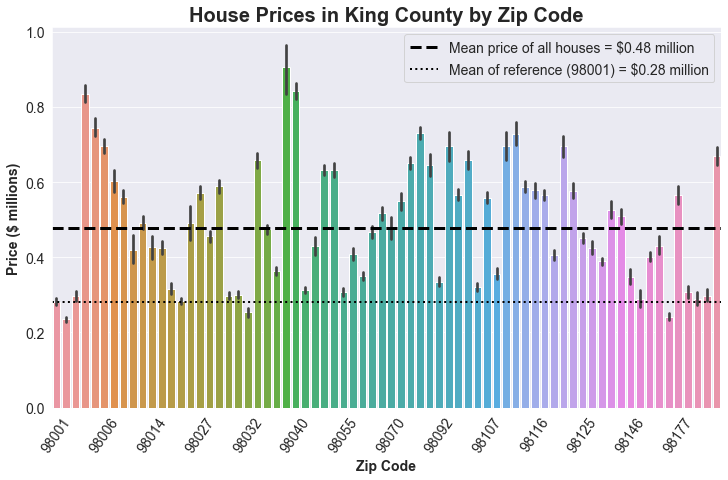

In [157]:
## create a column of price in units of millions of dollars
data_IQR['price_mil'] = data_IQR['price'] / 1000000

## create a barplot that shows house prices by zipcode
plt.figure(figsize=(12,7))
ax = sns.barplot(x='zipcode', y='price_mil',
                data=data_IQR)

## plot a horizontal line for the mean price of all movies in the IQR cleaned data
ax.axhline(y=data_IQR['price_mil'].mean(),
           ls='--', c='k', linewidth=3,
           label='Mean price of all houses = ${} million'.format(round(data_IQR['price_mil'].mean(), 2)))

## plot a horizontal line for the mean price of reference zip 98001 IQR cleaned data
ax.axhline(y=data_IQR.groupby('zipcode').mean()['price_mil'][0],
           ls=':', c='k', linewidth=2,
           label='Mean of reference (98001) = ${} million'.format(
               round(data_IQR.groupby('zipcode').mean()['price_mil'][0], 2)))

## adjust xtick labels and remove all but every 5th xtick label for legibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, fontsize=14)
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 5 != 0:
        label.set_visible(False)
        
ax.set_yticklabels(ax.get_yticks().round(1), fontsize=14)
        
ax.set_xlabel('Zip Code', fontsize=14, weight='bold')
ax.set_ylabel('Price ($ millions)', fontsize=14, weight='bold')
ax.set_title('House Prices in King County by Zip Code', fontsize=20, weight='bold')

plt.legend(fontsize=14)

plt.savefig(fig_filepath+'House Prices in King County by Zip Code')
plt.show()

## Figure 2 - Effect of Latitude on Price

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


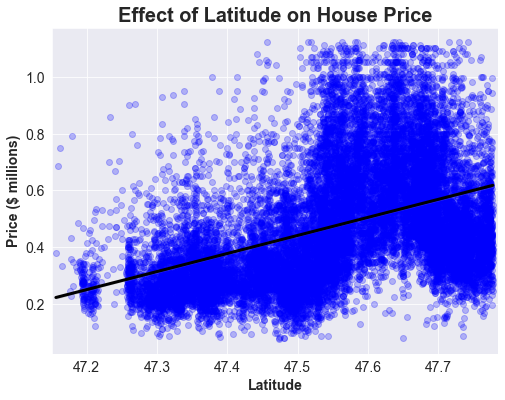

In [158]:
## create a regression plot that shows the change in price with changing latitude
plt.figure(figsize=(8,6))
ax = sns.regplot(x='lat', y='price_mil',
                data=data_IQR,
                line_kws={'color': 'k', 'linewidth': 3},
                scatter_kws={'color': 'b', 'alpha': 0.25})  
ax.set(xlim=(47.15, 47.785))
ax.set_xlabel('Latitude', fontsize=14, weight='bold')
ax.set_ylabel('Price ($ millions)', fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticks().round(1), fontsize=14)
ax.set_yticklabels(ax.get_yticks().round(1), fontsize=14)
ax.set_title('Effect of Latitude on House Price', fontsize=20, weight='bold')

plt.savefig(fig_filepath+'Effect of Latitude on House Price')
plt.show()

## Figure 3 - Effect of Renovation on Price

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


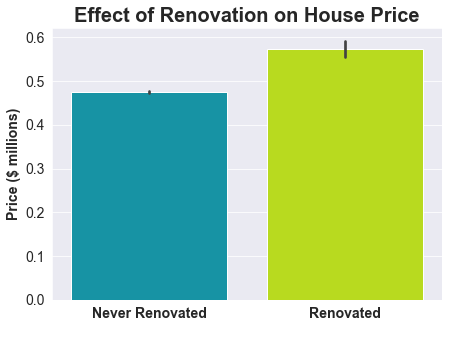

In [159]:
## create a barplot that shows difference in price between houses that were renovated and those that weren't
plt.figure(figsize=(7,5))
ax = sns.barplot(x='renovated', y='price_mil',
                 palette='nipy_spectral',
                 data=data_IQR)

ax.set_xticklabels(['Never Renovated', 'Renovated'], fontsize=14, weight='bold')
ax.set_yticklabels(ax.get_yticks().round(1), fontsize=14)
        
ax.set_xlabel(' ')
ax.set_ylabel('Price ($ millions)', fontsize=14, weight='bold')
ax.set_title('Effect of Renovation on House Price', fontsize=20, weight='bold')

plt.savefig(fig_filepath+'Effect of Renovation on House Price')
plt.show()

## Figure 4 - Effect of Condition on Price

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


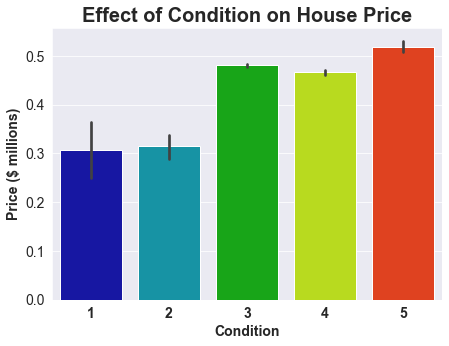

In [160]:
## create a barplot that shows difference in price based on condition
plt.figure(figsize=(7,5))
ax = sns.barplot(x='condition', y='price_mil',
                 palette='nipy_spectral',
                 data=data_IQR)

ax.set_xticklabels([1,2,3,4,5], fontsize=14, weight='bold')
ax.set_yticklabels(ax.get_yticks().round(1), fontsize=14)
        
ax.set_xlabel('Condition', fontsize=14, weight='bold')
ax.set_ylabel('Price ($ millions)', fontsize=14, weight='bold')
ax.set_title('Effect of Condition on House Price', fontsize=20, weight='bold')

plt.savefig(fig_filepath+'Effect of Condition on House Price')
plt.show()

## Figure 5 - Effect of Grade on Price

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


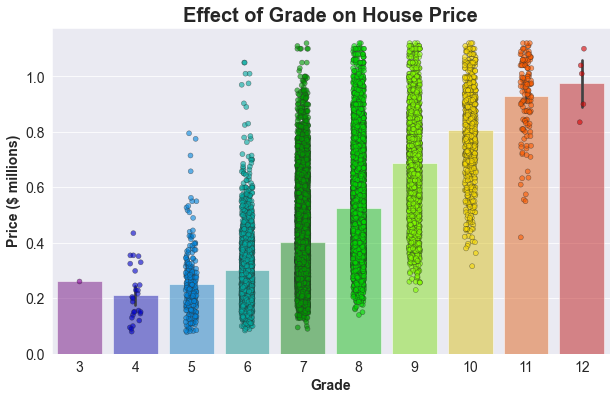

In [161]:
## make a bar plot showing the effect of grade on price
plt.figure(figsize=(10,6))
ax = sns.barplot(x='grade', y='price_mil',
                 data=data_IQR,
                 palette='nipy_spectral',
                 linewidth=1, alpha=0.5)

## plot a strip plot of the same data on top of the bar plot
ax = sns.stripplot(x='grade', y='price_mil',
                   data=data_IQR,
                   palette='nipy_spectral',
                   linewidth=0.5, alpha=0.6)

# ax.set(xlim=(2,13))
ax.set_xlabel('Grade', fontsize=14, weight='bold')
ax.set_ylabel('Price ($ millions)', fontsize=14, weight='bold')
ax.set_xticklabels(list(range(3,13)), fontsize=14)
ax.set_yticklabels(ax.get_yticks().round(1), fontsize=14)
ax.set_title('Effect of Grade on House Price', fontsize=20, weight='bold')

plt.savefig(fig_filepath+'Effect of Grade on House Price')
plt.show()

## Figure 6 - Effect of Interior Living Area on Price

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


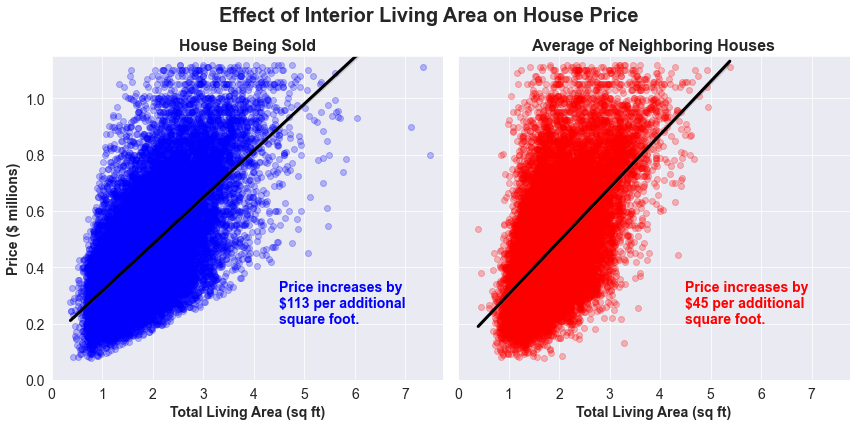

In [162]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6), sharey=True)

ax1 = axes[0]
ax2 = axes[1]

sns.regplot(x='sqft_living', y='price_mil',
                data=data_IQR,
                line_kws={'color': 'k', 'linewidth': 3},
                scatter_kws={'color': 'b', 'alpha': 0.25},
                ax=ax1)  
ax1.set(xlim=(0, 7750), ylim=(0, 1.15))
ax1.set_xlabel('Total Living Area (sq ft)', fontsize=14, weight='bold')
ax1.set_ylabel('Price ($ millions)', fontsize=14, weight='bold')
ax1.set_xticklabels(ax.get_xticks().round(1), fontsize=14)
ax1.set_yticklabels(ax.get_yticks().round(1), fontsize=14)
ax1.set_title('House Being Sold', fontsize=16, weight='bold')

ax1.text(4500, 0.2, 'Price increases by\n$113 per additional\nsquare foot.',
         fontsize=14, weight='bold', color='b')


sns.regplot(x='sqft_living15', y='price_mil',
                data=data_IQR,
                line_kws={'color': 'k', 'linewidth': 3},
                scatter_kws={'color': 'r', 'alpha': 0.25},
                ax=ax2)  

ax2.set(xlim=(0, 7750), ylim=(0, 1.15))
ax2.set_xlabel('Total Living Area (sq ft)', fontsize=14, weight='bold')
ax2.set_ylabel('')
ax2.set_xticklabels(ax.get_xticks().round(1), fontsize=14)
ax2.set_yticklabels(ax.get_yticks().round(1), fontsize=14)
ax2.set_title('Average of Neighboring Houses', fontsize=16, weight='bold')
ax2.text(4500, 0.2, 'Price increases by\n$45 per additional\nsquare foot.',
         fontsize=14, weight='bold', color='r')

fig.suptitle('Effect of Interior Living Area on House Price', fontsize=20, weight='bold')
plt.tight_layout()

plt.savefig(fig_filepath+'Effect of Interior Living Area on House Price')
plt.show()

## Figure 7 - Effect of Number of Bathrooms on Price

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


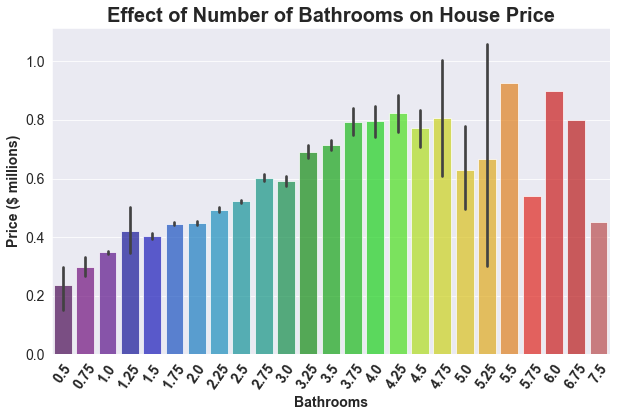

In [163]:
## create a barplot that shows difference in price based on number of bathrooms
plt.figure(figsize=(10,6))
ax = sns.barplot(x='bathrooms', y='price_mil',
                 palette='nipy_spectral',
                 data=data_IQR, alpha=0.7)

ax.set_xticklabels(sorted(list(data_IQR['bathrooms'].unique())), fontsize=14, weight='bold', rotation=55)        
ax.set_yticklabels(ax.get_yticks().round(1), fontsize=14)
        
ax.set_xlabel('Bathrooms', fontsize=14, weight='bold')
ax.set_ylabel('Price ($ millions)', fontsize=14, weight='bold')
ax.set_title('Effect of Number of Bathrooms on House Price', fontsize=20, weight='bold')

plt.savefig(fig_filepath+'Effect of Number of Bathrooms on House Price')
plt.show()

## Figure 8 - Effect of Bedrooms and Floors on Price

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


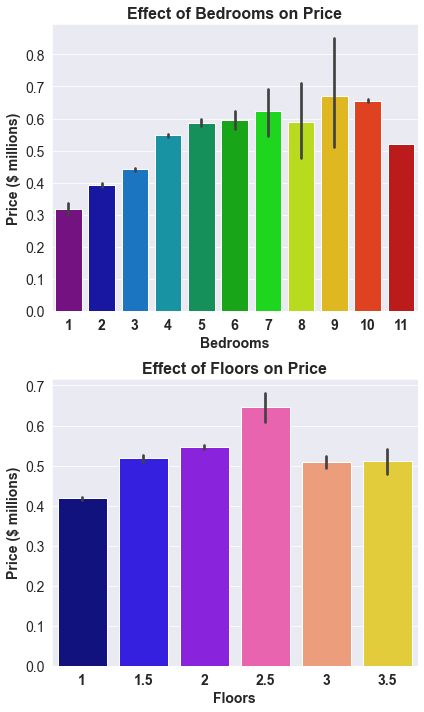

In [164]:
fig, axes = plt.subplots(nrows=2, figsize=(6,10))

ax1 = axes[0]
ax2 = axes[1]

## create a barplot that shows difference in price based on number of bedrooms
sns.barplot(x='bedrooms', y='price_mil',
                 palette='nipy_spectral',
                 data=data_IQR, ax=ax1)

ax1.set_xticklabels(list(range(1,12)), fontsize=14, weight='bold')
ax1.set_yticklabels(ax1.get_yticks().round(1), fontsize=14)
        
ax1.set_xlabel('Bedrooms', fontsize=14, weight='bold')
ax1.set_ylabel('Price ($ millions)', fontsize=14, weight='bold')
ax1.set_title('Effect of Bedrooms on Price', fontsize=16, weight='bold')

## create a barplot that shows difference in price based on number of floors
sns.barplot(x='floors', y='price_mil',
                 palette='gnuplot2',
                 data=data_IQR, ax=ax2)

ax2.set_xticklabels([1,1.5,2,2.5,3,3.5], fontsize=14, weight='bold')
ax2.set_yticklabels(ax1.get_yticks().round(1), fontsize=14)

ax2.set_xlabel('Floors', fontsize=14, weight='bold')
ax2.set_ylabel('Price ($ millions)', fontsize=14, weight='bold')
ax2.set_title('Effect of Floors on Price', fontsize=16, weight='bold')

plt.tight_layout()

plt.savefig(fig_filepath+'Effect of Number of Bedrooms and Floors on House Price')
plt.show()

In [165]:
final_full_df = data.copy()
final_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  21420 non-null  int64   
 1   date                21420 non-null  object  
 2   price               21420 non-null  float64 
 3   bedrooms            21420 non-null  int64   
 4   bathrooms           21420 non-null  float64 
 5   sqft_living         21420 non-null  int64   
 6   sqft_lot            21420 non-null  int64   
 7   floors              21420 non-null  float64 
 8   waterfront          21420 non-null  int64   
 9   condition           21420 non-null  int64   
 10  grade               21420 non-null  int64   
 11  sqft_above          21420 non-null  int64   
 12  sqft_basement       21420 non-null  object  
 13  yr_built            21420 non-null  int64   
 14  yr_renovated        17640 non-null  float64 
 15  zipcode             21420 non-null  

In [166]:
final_model_data = data_IQR.copy()
final_model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20268 entries, 0 to 21596
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  20268 non-null  int64   
 1   date                20268 non-null  object  
 2   price               20268 non-null  float64 
 3   bedrooms            20268 non-null  int64   
 4   bathrooms           20268 non-null  float64 
 5   sqft_living         20268 non-null  int64   
 6   sqft_lot            20268 non-null  int64   
 7   floors              20268 non-null  float64 
 8   waterfront          20268 non-null  int64   
 9   condition           20268 non-null  int64   
 10  grade               20268 non-null  int64   
 11  sqft_above          20268 non-null  int64   
 12  sqft_basement       20268 non-null  object  
 13  yr_built            20268 non-null  int64   
 14  yr_renovated        16702 non-null  float64 
 15  zipcode             20268 non-null  

In [167]:
folder = %pwd
data_filepath = folder+'/Data/'

In [168]:
# save final DataFrames
final_full_df.to_csv(data_filepath+'final_full_df.csv')
final_model_data.to_csv(data_filepath+'final_model_data.csv')